In [14]:
import numpy as np
from keras.src.layers import Dropout
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

In [15]:
dst_path = "/Users/sosen/UniProjects/eng-thesis/data/old/temp/CROPPED/NON-STED"

# Define parameters
batch_size = 32

img_height = 260
img_width = 260

In [16]:
# Load the Data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dst_path,
    labels='inferred',
    subset="both",
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    seed=123,
)
class_names = train_ds.class_names
num_classes = len(class_names)

Found 2921 files belonging to 6 classes.
Using 2337 files for training.
Using 584 files for validation.


In [17]:
def copy_red_to_green_and_blue(image,label):
    """
    This function takes an image and replaces the green and blue channels 
    with the values from the red channel.
    """
    # Repeat the red channel across the RGB channels
    # image[..., 0] is the red channel of the image
    red_channel = image[..., 0:1]  # Extract only the red channel, shape (H, W, 1)
    new_image = tf.concat([red_channel, red_channel, red_channel], axis=-1)
    return new_image, label

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.map(copy_red_to_green_and_blue)
val_ds = val_ds.map(copy_red_to_green_and_blue)

In [19]:
from tensorflow.keras import backend as K


def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        '''
        Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        '''
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def recall(y_true, y_pred):
        '''
        Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        '''
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    y_pred = K.round(y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [20]:
def normalize(x):
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    mean = [0.24155269834305526,0.24155269834305526,0.24155269834305526]
    std = [0.2809975193618667, 0.2809975193618667, 0.2809975193618667]
    # mean = tf.constant([61.59593603488316, 61.59593603488316, 61.59593603488316])
    # std = tf.constant([71.65436657360661, 71.65436657360661, 71.65436657360661])
    return (x - mean) / std

In [21]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Lambda(copy_red_to_green_and_blue),
    # tf.keras.layers.Rescaling(1. / 255),  # Scale images to [0, 1]
    # tf.keras.layers.Lambda(normalize),  # Normalize images
    # tf.keras.layers.Rescaling(scale=2, offset=-1),  # Scale images to [-1, 1]
    # You can add more augmentations if needed
    # tf.keras.layers.RandomZoom(0.15),
    # tf.keras.layers.RandomWidth(0.1),
    # tf.keras.layers.RandomHeight(0.1),
    # tf.keras.layers.RandomContrast(0.05),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical")
], name="data_augmentation")

In [22]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)

model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_tensor=x, pooling=None, include_preprocessing=True)
model.trainable = False

AVG_POOL_TOP = True
if AVG_POOL_TOP:
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
else:
    x = Flatten()(model.output)
    x = Dense(1000, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])

print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 260, 260, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 260, 260, 3)          0         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 260, 260, 3)          0         ['data_augmentation[0][0]']   
                                                                                                  
 normalization_1 (Normaliza  (None, 260, 260, 3)          0         ['rescaling_1[0][0]

In [23]:
# Count occurrences of each class in the training dataset
labels = np.concatenate([y for x, y in train_ds], axis=0)
label_indices = np.argmax(labels, axis=1)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_indices),
    y=label_indices
)

train_class_weights = dict(enumerate(class_weights))

early_stopping = EarlyStopping(
    monitor='f1',  # specify the F1 score for early stopping
    patience=4,
    mode='max',  #
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    class_weight=train_class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20


2024-12-09 09:35:47.146086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:47.146721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 10:01 - loss: 2.0427 - accuracy: 0.3438 - f1: 0.3043

2024-12-09 09:35:51.211062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:51.211068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 29s - loss: 2.1918 - accuracy: 0.2396 - f1: 0.1949

2024-12-09 09:35:51.864726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:51.864849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:52.028605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:52.028605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 23s - loss: 2.0119 - accuracy: 0.2578 - f1: 0.1887

2024-12-09 09:35:52.214473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:52.214549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 20s - loss: 1.9661 - accuracy: 0.2656 - f1: 0.1927

2024-12-09 09:35:52.497848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:52.497909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:52.688425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:52.689753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 17s - loss: 1.8350 - accuracy: 0.2812 - f1: 0.2080

2024-12-09 09:35:52.890178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:52.890182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:53.098166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:53.098209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 16s - loss: 1.8045 - accuracy: 0.3094 - f1: 0.2275

2024-12-09 09:35:53.312988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:53.313007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:53.510617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:53.510624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 15s - loss: 1.7692 - accuracy: 0.3182 - f1: 0.2359

2024-12-09 09:35:53.736168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:53.736187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 15s - loss: 1.7246 - accuracy: 0.3245 - f1: 0.2398

2024-12-09 09:35:53.956080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:53.956070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:54.155738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:54.155773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 14s - loss: 1.7037 - accuracy: 0.3281 - f1: 0.2442

2024-12-09 09:35:54.375810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:54.375829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 13s - loss: 1.6975 - accuracy: 0.3320 - f1: 0.2497

2024-12-09 09:35:54.593087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:54.593124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:54.800038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:54.800047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 13s - loss: 1.6608 - accuracy: 0.3346 - f1: 0.2518

2024-12-09 09:35:55.012346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:55.012417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 13s - loss: 1.6362 - accuracy: 0.3420 - f1: 0.2592

2024-12-09 09:35:55.221018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:55.221536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 12s - loss: 1.6123 - accuracy: 0.3453 - f1: 0.2682

2024-12-09 09:35:55.433715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:55.434157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:55.643569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:55.644284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 12s - loss: 1.5789 - accuracy: 0.3497 - f1: 0.2759

2024-12-09 09:35:55.851364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:55.851436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 11s - loss: 1.6228 - accuracy: 0.3505 - f1: 0.2801

2024-12-09 09:35:56.063998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:56.064011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 11s - loss: 1.6047 - accuracy: 0.3542 - f1: 0.2863

2024-12-09 09:35:56.266008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:56.266008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:56.467489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:56.467596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 11s - loss: 1.5912 - accuracy: 0.3575 - f1: 0.2933

2024-12-09 09:35:56.693179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:56.693682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 10s - loss: 1.5934 - accuracy: 0.3570 - f1: 0.2928

2024-12-09 09:35:56.913789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:56.913938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 10s - loss: 1.5561 - accuracy: 0.3661 - f1: 0.3003

2024-12-09 09:35:57.125578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:57.128596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:57.331806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:57.331958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 10s - loss: 1.5339 - accuracy: 0.3728 - f1: 0.3088

2024-12-09 09:35:57.541031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:57.541052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 9s - loss: 1.5266 - accuracy: 0.3740 - f1: 0.3105 

2024-12-09 09:35:57.750336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:57.750378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 9s - loss: 1.5235 - accuracy: 0.3770 - f1: 0.3154

2024-12-09 09:35:57.964227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:57.964247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 9s - loss: 1.5113 - accuracy: 0.3789 - f1: 0.3192

2024-12-09 09:35:58.178866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:58.179479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 9s - loss: 1.4919 - accuracy: 0.3826 - f1: 0.3237

2024-12-09 09:35:58.406198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:58.406643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 1.4617 - accuracy: 0.3964 - f1: 0.3367

2024-12-09 09:35:58.652452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:58.652699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:58.860202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:58.861122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 1.4614 - accuracy: 0.4019 - f1: 0.3459

2024-12-09 09:35:59.093499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:59.093558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 8s - loss: 1.4532 - accuracy: 0.4071 - f1: 0.3523

2024-12-09 09:35:59.333678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:59.335326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 8s - loss: 1.4430 - accuracy: 0.4079 - f1: 0.3537

2024-12-09 09:35:59.564369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:59.564421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 1.4360 - accuracy: 0.4095 - f1: 0.3572

2024-12-09 09:35:59.805849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:35:59.805930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 7s - loss: 1.4113 - accuracy: 0.4223 - f1: 0.3700

2024-12-09 09:36:00.032022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:00.032248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:00.228295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:00.228319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 1.4177 - accuracy: 0.4222 - f1: 0.3705

2024-12-09 09:36:00.447148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:00.447182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:00.648453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:00.648802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 1.4130 - accuracy: 0.4247 - f1: 0.3750

2024-12-09 09:36:00.855954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:00.856067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 6s - loss: 1.3997 - accuracy: 0.4334 - f1: 0.3848

2024-12-09 09:36:01.075797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.075789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.279881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.279910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 1.3869 - accuracy: 0.4414 - f1: 0.3941

2024-12-09 09:36:01.490494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.490632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.639508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.639532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 5s - loss: 1.3672 - accuracy: 0.4462 - f1: 0.4020

2024-12-09 09:36:01.783014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.783083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.953844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:01.953852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 5s - loss: 1.3669 - accuracy: 0.4473 - f1: 0.4048

2024-12-09 09:36:02.089059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:02.089256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 1.3797 - accuracy: 0.4483 - f1: 0.4068

2024-12-09 09:36:02.363803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:02.363827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 1.3667 - accuracy: 0.4511 - f1: 0.4094

2024-12-09 09:36:02.604846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:02.605025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 4s - loss: 1.3518 - accuracy: 0.4545 - f1: 0.4151

2024-12-09 09:36:02.819153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:02.819159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:03.019029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:03.019041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 1.3349 - accuracy: 0.4545 - f1: 0.4163

2024-12-09 09:36:03.229673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:03.230275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:03.436257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:03.436398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 3s - loss: 1.3396 - accuracy: 0.4558 - f1: 0.4145

2024-12-09 09:36:03.680408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:03.680402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 3s - loss: 1.3246 - accuracy: 0.4599 - f1: 0.4194

2024-12-09 09:36:03.912937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:03.913080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.108605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.108649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 1.3109 - accuracy: 0.4602 - f1: 0.4212

2024-12-09 09:36:04.288954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.288954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.484107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.484215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 2s - loss: 1.3033 - accuracy: 0.4624 - f1: 0.4251

2024-12-09 09:36:04.690612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.690680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.870738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:04.870738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 1.2854 - accuracy: 0.4678 - f1: 0.4317

2024-12-09 09:36:05.006614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.006733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.161638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.161717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 1.2708 - accuracy: 0.4706 - f1: 0.4343

2024-12-09 09:36:05.309775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.309772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.489305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.489477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 1.2666 - accuracy: 0.4719 - f1: 0.4357

2024-12-09 09:36:05.737528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.738207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 1.2545 - accuracy: 0.4758 - f1: 0.4401

2024-12-09 09:36:05.957906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:05.957816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:06.155462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:06.155526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 1.2457 - accuracy: 0.4799 - f1: 0.4461

2024-12-09 09:36:06.356914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:06.356994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:06.552416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:06.552421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 31s 312ms/step - loss: 1.2454 - accuracy: 0.4801 - f1: 0.4401 - val_loss: 1.1367 - val_accuracy: 0.6216 - val_f1: 0.2843
Epoch 2/20


2024-12-09 09:36:13.985795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:13.985827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 1:04 - loss: 0.5592 - accuracy: 0.6875 - f1: 0.6800

2024-12-09 09:36:14.897084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:14.897518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.6901 - accuracy: 0.6667 - f1: 0.6417

2024-12-09 09:36:15.107255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:15.107270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:15.290843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:15.290869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 14s - loss: 0.7681 - accuracy: 0.6562 - f1: 0.6352

2024-12-09 09:36:15.487211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:15.487238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:15.674567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:15.674575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 13s - loss: 0.7497 - accuracy: 0.6384 - f1: 0.6138

2024-12-09 09:36:15.850685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:15.850803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.033177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.033215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 12s - loss: 0.7954 - accuracy: 0.6458 - f1: 0.6226

2024-12-09 09:36:16.209898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.210163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.392926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.393066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 11s - loss: 0.8877 - accuracy: 0.6420 - f1: 0.6163

2024-12-09 09:36:16.575162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.575305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.760104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.760213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 11s - loss: 0.8858 - accuracy: 0.6370 - f1: 0.6114

2024-12-09 09:36:16.956661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:16.957043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.152674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.152725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 11s - loss: 0.9368 - accuracy: 0.6292 - f1: 0.6060

2024-12-09 09:36:17.347289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.347362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.534507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.534825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 10s - loss: 0.9771 - accuracy: 0.6287 - f1: 0.6088

2024-12-09 09:36:17.731736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.731959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.868387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:17.868604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 10s - loss: 0.9475 - accuracy: 0.6299 - f1: 0.6110

2024-12-09 09:36:18.016687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:18.017007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:18.184902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:18.186739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 10s - loss: 0.9588 - accuracy: 0.6281 - f1: 0.6046

2024-12-09 09:36:18.410141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:18.426845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 9s - loss: 0.9656 - accuracy: 0.6236 - f1: 0.5992 

2024-12-09 09:36:18.642984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:18.643234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 9s - loss: 0.9586 - accuracy: 0.6223 - f1: 0.5953

2024-12-09 09:36:18.852296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:18.852257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 9s - loss: 0.9476 - accuracy: 0.6224 - f1: 0.5972

2024-12-09 09:36:19.060906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:19.061193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 9s - loss: 0.9450 - accuracy: 0.6288 - f1: 0.6048

2024-12-09 09:36:19.272471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:19.272528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:19.477656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:19.479590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.9419 - accuracy: 0.6250 - f1: 0.6029

2024-12-09 09:36:19.694676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:19.694760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:19.883752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:19.883891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 8s - loss: 0.9349 - accuracy: 0.6272 - f1: 0.6029

2024-12-09 09:36:20.080724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:20.080894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.9216 - accuracy: 0.6271 - f1: 0.6062

2024-12-09 09:36:20.299976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:20.299976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:20.504513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:20.505867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.9144 - accuracy: 0.6240 - f1: 0.6061

2024-12-09 09:36:20.721678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:20.723543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.9167 - accuracy: 0.6231 - f1: 0.6049

2024-12-09 09:36:20.948310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:20.948402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:21.128742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:21.128846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 7s - loss: 0.9042 - accuracy: 0.6232 - f1: 0.6054

2024-12-09 09:36:21.370223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:21.371183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.9243 - accuracy: 0.6207 - f1: 0.6045

2024-12-09 09:36:21.658584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:21.659664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.9421 - accuracy: 0.6208 - f1: 0.6026

2024-12-09 09:36:21.918858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:21.918879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:22.109835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:22.111158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.9469 - accuracy: 0.6184 - f1: 0.6008

2024-12-09 09:36:22.387842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:22.391922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.9432 - accuracy: 0.6186 - f1: 0.6010

2024-12-09 09:36:22.639676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:22.644402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.9440 - accuracy: 0.6195 - f1: 0.6023

2024-12-09 09:36:22.917312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:22.917853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.9524 - accuracy: 0.6174 - f1: 0.5999

2024-12-09 09:36:23.171222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:23.171471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.9579 - accuracy: 0.6183 - f1: 0.5995

2024-12-09 09:36:23.435211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:23.436452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.9451 - accuracy: 0.6200 - f1: 0.6047

2024-12-09 09:36:23.687948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:23.688425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.9420 - accuracy: 0.6201 - f1: 0.6056

2024-12-09 09:36:23.901758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:23.902223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.108408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.108472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.9387 - accuracy: 0.6184 - f1: 0.6025

2024-12-09 09:36:24.321906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.324953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.513792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.514184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.9311 - accuracy: 0.6186 - f1: 0.6025

2024-12-09 09:36:24.716527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.716547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.912317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:24.912386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 5s - loss: 0.9283 - accuracy: 0.6206 - f1: 0.6019

2024-12-09 09:36:25.105576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:25.105652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.9366 - accuracy: 0.6202 - f1: 0.6006

2024-12-09 09:36:25.312632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:25.313316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:25.511963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:25.511965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.9370 - accuracy: 0.6191 - f1: 0.6006

2024-12-09 09:36:25.725948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:25.725983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.9344 - accuracy: 0.6187 - f1: 0.6008

2024-12-09 09:36:25.933787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:25.934325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.9270 - accuracy: 0.6211 - f1: 0.6030

2024-12-09 09:36:26.138942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:26.139858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:26.344154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:26.344178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 3s - loss: 0.9205 - accuracy: 0.6234 - f1: 0.6058

2024-12-09 09:36:26.551314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:26.551357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:26.749716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:26.750078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.9117 - accuracy: 0.6245 - f1: 0.6080

2024-12-09 09:36:26.941285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:26.941275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:27.124285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:27.124371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.9190 - accuracy: 0.6250 - f1: 0.6075

2024-12-09 09:36:27.338027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:27.338018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:27.534033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:27.534090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.9149 - accuracy: 0.6265 - f1: 0.6077

2024-12-09 09:36:27.739939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:27.739940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.9115 - accuracy: 0.6245 - f1: 0.6041

2024-12-09 09:36:27.945049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:27.945063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.117176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.117205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.9031 - accuracy: 0.6255 - f1: 0.6047

2024-12-09 09:36:28.280439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.280456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.436098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.436188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.8956 - accuracy: 0.6264 - f1: 0.6063

2024-12-09 09:36:28.610959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.611206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.770980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.771032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.8905 - accuracy: 0.6276 - f1: 0.6075

2024-12-09 09:36:28.946993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:28.947253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:29.121940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:29.122215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.8824 - accuracy: 0.6314 - f1: 0.6113

2024-12-09 09:36:29.308267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:29.308312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:29.486615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:29.486727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 19s 246ms/step - loss: 0.8828 - accuracy: 0.6312 - f1: 0.6030 - val_loss: 0.9471 - val_accuracy: 0.7397 - val_f1: 0.5139
Epoch 3/20


2024-12-09 09:36:32.841844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:32.841844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 47s - loss: 0.5712 - accuracy: 0.7188 - f1: 0.7143

2024-12-09 09:36:33.494780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:33.494905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 16s - loss: 0.7264 - accuracy: 0.6771 - f1: 0.6578

2024-12-09 09:36:33.737742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:33.739146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:33.941557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:33.941549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 15s - loss: 0.7515 - accuracy: 0.6641 - f1: 0.6544

2024-12-09 09:36:34.153725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:34.154579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.7009 - accuracy: 0.6927 - f1: 0.6758

2024-12-09 09:36:34.371758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:34.371932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:34.569637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:34.569750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 13s - loss: 0.7602 - accuracy: 0.6641 - f1: 0.6452

2024-12-09 09:36:34.769885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:34.770058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:34.951449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:34.951558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 13s - loss: 0.7496 - accuracy: 0.6594 - f1: 0.6451

2024-12-09 09:36:35.136740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:35.136739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:35.332878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 12s - loss: 0.7486 - accuracy: 0.6648 - f1: 0.6416

2024-12-09 09:36:35.339163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:35.535998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:35.536005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.7612 - accuracy: 0.6615 - f1: 0.6370

2024-12-09 09:36:35.729265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:35.729894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.7648 - accuracy: 0.6607 - f1: 0.6428

2024-12-09 09:36:35.950474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:35.950490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.7495 - accuracy: 0.6604 - f1: 0.6428

2024-12-09 09:36:36.152358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:36.152410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:36.341705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:36.345349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.7691 - accuracy: 0.6526 - f1: 0.6363

2024-12-09 09:36:36.545246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:36.545267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.7669 - accuracy: 0.6510 - f1: 0.6327

2024-12-09 09:36:36.748591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:36.749784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:36.953043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:36.953014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.7877 - accuracy: 0.6464 - f1: 0.6294

2024-12-09 09:36:37.157532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:37.157588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 10s - loss: 0.7890 - accuracy: 0.6384 - f1: 0.6201

2024-12-09 09:36:37.373149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:37.373188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:37.577316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:37.577737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.7770 - accuracy: 0.6481 - f1: 0.6261

2024-12-09 09:36:37.787743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:37.787945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:37.940161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:37.940716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 9s - loss: 0.7599 - accuracy: 0.6550 - f1: 0.6345 

2024-12-09 09:36:38.094623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:38.097199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:38.278281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:38.280211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 9s - loss: 0.7539 - accuracy: 0.6526 - f1: 0.6329

2024-12-09 09:36:38.557387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:38.557496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.7525 - accuracy: 0.6551 - f1: 0.6341

2024-12-09 09:36:38.785904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:38.786090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:38.979928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:38.981578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.7586 - accuracy: 0.6531 - f1: 0.6295

2024-12-09 09:36:39.184731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:39.185882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.7591 - accuracy: 0.6542 - f1: 0.6322

2024-12-09 09:36:39.399937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:39.400060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:39.606277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:39.606499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.7533 - accuracy: 0.6619 - f1: 0.6408

2024-12-09 09:36:39.829829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:39.829877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:40.030647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:40.030701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.7583 - accuracy: 0.6599 - f1: 0.6399

2024-12-09 09:36:40.229774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:40.229800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.7533 - accuracy: 0.6623 - f1: 0.6406

2024-12-09 09:36:40.445994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:40.446900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:40.641120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:40.641534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.7518 - accuracy: 0.6612 - f1: 0.6407

2024-12-09 09:36:40.862790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:40.862809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.067843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.068741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.7502 - accuracy: 0.6594 - f1: 0.6402

2024-12-09 09:36:41.219132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.219242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.381685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.381680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.7605 - accuracy: 0.6600 - f1: 0.6398

2024-12-09 09:36:41.524745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.524882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.663626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.664231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.7619 - accuracy: 0.6606 - f1: 0.6418

2024-12-09 09:36:41.849107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:41.850015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.7650 - accuracy: 0.6639 - f1: 0.6426

2024-12-09 09:36:42.110939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:42.110953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:42.327116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:42.335191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.7732 - accuracy: 0.6656 - f1: 0.6440

2024-12-09 09:36:42.556865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:42.558693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:42.747858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:42.755315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.7657 - accuracy: 0.6684 - f1: 0.6469

2024-12-09 09:36:42.946723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:42.947727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:43.131539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:43.131747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.7646 - accuracy: 0.6648 - f1: 0.6440

2024-12-09 09:36:43.327453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:43.327689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:43.530902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:43.530875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.7729 - accuracy: 0.6645 - f1: 0.6447

2024-12-09 09:36:43.822754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:43.822846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.038333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.038396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.7656 - accuracy: 0.6648 - f1: 0.6441

2024-12-09 09:36:44.291914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.292043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.484130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.484272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.7664 - accuracy: 0.6634 - f1: 0.6434

2024-12-09 09:36:44.663899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.665051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.847267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:44.847412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.7587 - accuracy: 0.6679 - f1: 0.6472

2024-12-09 09:36:45.027087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.027112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.214309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.214287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.7553 - accuracy: 0.6675 - f1: 0.6457

2024-12-09 09:36:45.390103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.390448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.562372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.562483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.7505 - accuracy: 0.6687 - f1: 0.6469

2024-12-09 09:36:45.748425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.748607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.933678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:45.933854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.7434 - accuracy: 0.6716 - f1: 0.6481

2024-12-09 09:36:46.124035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:46.124226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:46.313653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:46.313653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.7422 - accuracy: 0.6693 - f1: 0.6457

2024-12-09 09:36:46.497441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:46.497460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:46.675785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:46.675898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.7425 - accuracy: 0.6685 - f1: 0.6455

2024-12-09 09:36:46.861606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:46.861607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:47.035845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:47.035922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.7443 - accuracy: 0.6690 - f1: 0.6455

2024-12-09 09:36:47.211445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:47.211510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.7411 - accuracy: 0.6688 - f1: 0.6461

2024-12-09 09:36:47.417860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:47.417872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:47.603072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:47.603072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.6688 - f1: 0.6389

2024-12-09 09:36:47.784433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:47.784481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 18s 239ms/step - loss: 0.7394 - accuracy: 0.6688 - f1: 0.6389 - val_loss: 0.8220 - val_accuracy: 0.7723 - val_f1: 0.6341
Epoch 4/20


2024-12-09 09:36:50.915821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:50.915820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 56s - loss: 0.4431 - accuracy: 0.8125 - f1: 0.7778

2024-12-09 09:36:51.746329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:51.747025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 22s - loss: 0.4583 - accuracy: 0.7812 - f1: 0.7682

2024-12-09 09:36:52.008009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:52.008419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 18s - loss: 0.4684 - accuracy: 0.7604 - f1: 0.7494

2024-12-09 09:36:52.216347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:52.216446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 16s - loss: 0.4917 - accuracy: 0.7188 - f1: 0.7163

2024-12-09 09:36:52.461973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:52.462397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:52.647321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:52.647344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 14s - loss: 0.5778 - accuracy: 0.7009 - f1: 0.6858

2024-12-09 09:36:52.828342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:52.828347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.007167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.007254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.5530 - accuracy: 0.7222 - f1: 0.7016

2024-12-09 09:36:53.185233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.185253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.374843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.374978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 13s - loss: 0.5937 - accuracy: 0.7131 - f1: 0.6942

2024-12-09 09:36:53.558211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.560225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.771129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.771387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 12s - loss: 0.6403 - accuracy: 0.6923 - f1: 0.6734

2024-12-09 09:36:53.991692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:53.991857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:54.201695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:54.203512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.6496 - accuracy: 0.6854 - f1: 0.6654

2024-12-09 09:36:54.466901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:54.468530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:54.664440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:54.664744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 12s - loss: 0.6336 - accuracy: 0.6934 - f1: 0.6771

2024-12-09 09:36:54.863912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:54.865749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 12s - loss: 0.6286 - accuracy: 0.7022 - f1: 0.6844

2024-12-09 09:36:55.073196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:55.073196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.6290 - accuracy: 0.7039 - f1: 0.6850

2024-12-09 09:36:55.299300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:55.299400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:55.492750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:55.497767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 11s - loss: 0.6324 - accuracy: 0.7063 - f1: 0.6891

2024-12-09 09:36:55.720294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:55.720368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 10s - loss: 0.6217 - accuracy: 0.7060 - f1: 0.6934

2024-12-09 09:36:55.934793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:55.934863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:56.129968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:56.130961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 10s - loss: 0.6354 - accuracy: 0.7109 - f1: 0.6930

2024-12-09 09:36:56.465497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:56.475797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:56.668463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:56.668839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 10s - loss: 0.6864 - accuracy: 0.7019 - f1: 0.6843

2024-12-09 09:36:56.834144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:56.834437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:57.019532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:57.019628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.6896 - accuracy: 0.7014 - f1: 0.6823 

2024-12-09 09:36:57.228998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:57.234937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.6843 - accuracy: 0.7020 - f1: 0.6835

2024-12-09 09:36:57.475226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:57.475226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.6888 - accuracy: 0.6994 - f1: 0.6825

2024-12-09 09:36:57.692932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:57.693297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 9s - loss: 0.6873 - accuracy: 0.6990 - f1: 0.6835

2024-12-09 09:36:57.906887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:57.907239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 9s - loss: 0.6798 - accuracy: 0.6986 - f1: 0.6840

2024-12-09 09:36:58.122181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:58.122310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.6728 - accuracy: 0.7002 - f1: 0.6857

2024-12-09 09:36:58.335291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:58.335400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.6700 - accuracy: 0.7008 - f1: 0.6865

2024-12-09 09:36:58.556862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:58.557293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.6696 - accuracy: 0.6976 - f1: 0.6853

2024-12-09 09:36:58.769191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:58.769518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.6688 - accuracy: 0.6964 - f1: 0.6848

2024-12-09 09:36:58.992086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:58.992228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 0.6709 - accuracy: 0.6988 - f1: 0.6852

2024-12-09 09:36:59.403467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:59.403495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.6728 - accuracy: 0.7007 - f1: 0.6889

2024-12-09 09:36:59.618771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:59.621569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.6717 - accuracy: 0.7003 - f1: 0.6888

2024-12-09 09:36:59.827480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:59.827521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:59.986596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:36:59.987827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6966 - f1: 0.6858

2024-12-09 09:37:00.185852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:00.185875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:00.319997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:00.320133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.6611 - accuracy: 0.6999 - f1: 0.6890

2024-12-09 09:37:00.453223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:00.453954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:00.638975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:00.646255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.6573 - accuracy: 0.7010 - f1: 0.6925

2024-12-09 09:37:00.932437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:00.936135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.6540 - accuracy: 0.7021 - f1: 0.6942

2024-12-09 09:37:01.176954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:01.179020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 6s - loss: 0.6507 - accuracy: 0.7018 - f1: 0.6939

2024-12-09 09:37:01.388114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:01.388229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.6714 - accuracy: 0.7001 - f1: 0.6919

2024-12-09 09:37:01.599625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:01.599888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 0.6706 - accuracy: 0.7005 - f1: 0.6930

2024-12-09 09:37:01.836549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:01.837068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 5s - loss: 0.6694 - accuracy: 0.7019 - f1: 0.6939

2024-12-09 09:37:02.045728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:02.045841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:02.222779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:02.222753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.6642 - accuracy: 0.7019 - f1: 0.6943

2024-12-09 09:37:02.410964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:02.410984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:02.598863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:02.598928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.6872 - accuracy: 0.7005 - f1: 0.6925

2024-12-09 09:37:02.790848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:02.791222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.7006 - f1: 0.6923

2024-12-09 09:37:03.004204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.004304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.191021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.191047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.6886 - accuracy: 0.6996 - f1: 0.6905

2024-12-09 09:37:03.408212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.408282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.597276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.597272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.6837 - accuracy: 0.6992 - f1: 0.6913

2024-12-09 09:37:03.793082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.793100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.976617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:03.976920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.6795 - accuracy: 0.6998 - f1: 0.6910

2024-12-09 09:37:04.163186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:04.163168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:04.348906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:04.348913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.6781 - accuracy: 0.7014 - f1: 0.6915

2024-12-09 09:37:04.527990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:04.527995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:04.703819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:04.703921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.6765 - accuracy: 0.7000 - f1: 0.6904

2024-12-09 09:37:04.880747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:04.880773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.052137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.052340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.6794 - accuracy: 0.6964 - f1: 0.6869

2024-12-09 09:37:05.230840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.230888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.402222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.402435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.6754 - accuracy: 0.6970 - f1: 0.6878

2024-12-09 09:37:05.565113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.565199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.733173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.733191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.6681 - accuracy: 0.6985 - f1: 0.6897

2024-12-09 09:37:05.928259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:05.928280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:06.104620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:06.104750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.6806 - accuracy: 0.6969 - f1: 0.6883

2024-12-09 09:37:06.276341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:06.276521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:06.458964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:06.459264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 19s 245ms/step - loss: 0.6805 - accuracy: 0.6970 - f1: 0.6790 - val_loss: 0.7547 - val_accuracy: 0.7568 - val_f1: 0.6950
Epoch 5/20


2024-12-09 09:37:09.581715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:09.581741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 46s - loss: 0.5785 - accuracy: 0.6250 - f1: 0.5862

2024-12-09 09:37:10.230041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:10.230044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 18s - loss: 0.8741 - accuracy: 0.7188 - f1: 0.6829

2024-12-09 09:37:10.488569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:10.488660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 16s - loss: 0.7077 - accuracy: 0.6719 - f1: 0.6722

2024-12-09 09:37:10.725973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:10.726016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:10.920304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:10.920299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6927 - f1: 0.6812

2024-12-09 09:37:11.098383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:11.098441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:11.298290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:11.298394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 13s - loss: 0.6402 - accuracy: 0.6992 - f1: 0.6806

2024-12-09 09:37:11.496670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:11.496721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:11.678345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:11.678374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6969 - f1: 0.6833

2024-12-09 09:37:11.870094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:11.870148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:12.065617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:12.065637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 12s - loss: 0.6877 - accuracy: 0.6932 - f1: 0.6777

2024-12-09 09:37:12.275327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:12.275331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.6665 - accuracy: 0.7031 - f1: 0.6878

2024-12-09 09:37:12.483858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:12.484232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.6995 - accuracy: 0.6964 - f1: 0.6801

2024-12-09 09:37:12.710620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:12.710763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.6782 - accuracy: 0.7000 - f1: 0.6881

2024-12-09 09:37:12.918624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:12.918801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6992 - f1: 0.6860

2024-12-09 09:37:13.128507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:13.130273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.6645 - accuracy: 0.7022 - f1: 0.6874

2024-12-09 09:37:13.333601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:13.333812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:13.533761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:13.534605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.6397 - accuracy: 0.7122 - f1: 0.6939

2024-12-09 09:37:13.733442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:13.733502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:13.922051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:13.923062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 10s - loss: 0.6257 - accuracy: 0.7277 - f1: 0.7013

2024-12-09 09:37:14.114648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:14.114839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:14.304683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:14.304767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.6656 - accuracy: 0.7120 - f1: 0.6885

2024-12-09 09:37:14.498347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:14.501041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:14.696869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:14.697056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 9s - loss: 0.6497 - accuracy: 0.7075 - f1: 0.6882 

2024-12-09 09:37:14.897255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:14.897263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:15.089373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:15.089456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6968 - f1: 0.6797

2024-12-09 09:37:15.244755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:15.245429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:15.414135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:15.414220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6975 - f1: 0.6804

2024-12-09 09:37:15.581646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:15.593713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6972 - f1: 0.6787

2024-12-09 09:37:15.862021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:15.862376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.6824 - accuracy: 0.6927 - f1: 0.6753

2024-12-09 09:37:16.084366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:16.084524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6982 - f1: 0.6811

2024-12-09 09:37:16.298704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:16.299557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:16.506331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:16.506380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.6646 - accuracy: 0.6949 - f1: 0.6784

2024-12-09 09:37:16.722165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:16.722847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:16.921550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:16.922629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.6681 - accuracy: 0.6910 - f1: 0.6755

2024-12-09 09:37:17.133545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:17.134039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:17.325319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:17.325441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6917 - f1: 0.6768

2024-12-09 09:37:17.529211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:17.529716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.6687 - accuracy: 0.6971 - f1: 0.6809

2024-12-09 09:37:17.742071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:17.742146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.6748 - accuracy: 0.6977 - f1: 0.6817

2024-12-09 09:37:17.951806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:17.951910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.6752 - accuracy: 0.6974 - f1: 0.6816

2024-12-09 09:37:18.158503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:18.158871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:18.307207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:18.307424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.6770 - accuracy: 0.6977 - f1: 0.6841

2024-12-09 09:37:18.467945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:18.468654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:18.627099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:18.627214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 5s - loss: 0.6729 - accuracy: 0.6967 - f1: 0.6845

2024-12-09 09:37:18.828181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:18.828452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.6728 - accuracy: 0.6979 - f1: 0.6856

2024-12-09 09:37:19.097812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:19.097812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.6691 - accuracy: 0.7004 - f1: 0.6879

2024-12-09 09:37:19.370443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:19.372667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.6786 - accuracy: 0.6988 - f1: 0.6868

2024-12-09 09:37:19.599254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:19.599457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.6663 - accuracy: 0.7041 - f1: 0.6927

2024-12-09 09:37:19.810878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:19.814569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:20.007785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:20.007769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.6615 - accuracy: 0.7053 - f1: 0.6942

2024-12-09 09:37:20.184830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:20.188738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.6635 - accuracy: 0.7037 - f1: 0.6923

2024-12-09 09:37:20.389787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:20.392371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:20.584806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:20.585330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.6633 - accuracy: 0.7022 - f1: 0.6899

2024-12-09 09:37:20.785934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:20.791113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.6619 - accuracy: 0.7025 - f1: 0.6913

2024-12-09 09:37:21.003008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:21.003034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.6649 - accuracy: 0.7011 - f1: 0.6906

2024-12-09 09:37:21.287210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:21.298937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.6602 - accuracy: 0.7023 - f1: 0.6921

2024-12-09 09:37:21.593872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:21.595045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:21.772993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:21.773490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.6557 - accuracy: 0.7013 - f1: 0.6914

2024-12-09 09:37:21.939645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:21.940717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.130653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.130799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.6484 - accuracy: 0.7008 - f1: 0.6919

2024-12-09 09:37:22.310906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.311123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.492875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.492935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.6462 - accuracy: 0.6989 - f1: 0.6910

2024-12-09 09:37:22.670466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.670542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.844358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:22.844704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.6468 - accuracy: 0.6981 - f1: 0.6907

2024-12-09 09:37:23.021740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.021820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.208467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.208905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6954 - f1: 0.6880

2024-12-09 09:37:23.390102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.390346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.583299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.583313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.6434 - accuracy: 0.6975 - f1: 0.6914

2024-12-09 09:37:23.776418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.776499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.970728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:23.970915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.6347 - accuracy: 0.7003 - f1: 0.6942

2024-12-09 09:37:24.159314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:24.159439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:24.342378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:24.342602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.6310 - accuracy: 0.7021 - f1: 0.6963

2024-12-09 09:37:24.532501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:24.532641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:24.712560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:24.717289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 18s 242ms/step - loss: 0.6309 - accuracy: 0.7022 - f1: 0.6869 - val_loss: 0.6744 - val_accuracy: 0.7723 - val_f1: 0.7399
Epoch 6/20


2024-12-09 09:37:27.865891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:27.865906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 37s - loss: 0.5662 - accuracy: 0.8125 - f1: 0.7273

2024-12-09 09:37:28.393539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:28.393539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 14s - loss: 0.4778 - accuracy: 0.7292 - f1: 0.7098

2024-12-09 09:37:28.623213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:28.624000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:28.802242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:28.802272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 13s - loss: 0.5403 - accuracy: 0.7312 - f1: 0.7077

2024-12-09 09:37:28.977532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:28.977614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.156800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.156829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 12s - loss: 0.5189 - accuracy: 0.7232 - f1: 0.7053

2024-12-09 09:37:29.324228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.324293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.493958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.494143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 11s - loss: 0.5071 - accuracy: 0.7222 - f1: 0.7020

2024-12-09 09:37:29.665727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.665750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.843780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:29.843973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 11s - loss: 0.4893 - accuracy: 0.7301 - f1: 0.7138

2024-12-09 09:37:30.019854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.020032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.202117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.202265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 11s - loss: 0.5115 - accuracy: 0.7332 - f1: 0.7135

2024-12-09 09:37:30.411150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.411257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.601998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.602610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 10s - loss: 0.5777 - accuracy: 0.7250 - f1: 0.7097

2024-12-09 09:37:30.791125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.793295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.979135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:30.980969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 10s - loss: 0.5786 - accuracy: 0.7109 - f1: 0.6966

2024-12-09 09:37:31.197883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:31.199000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 10s - loss: 0.5812 - accuracy: 0.7118 - f1: 0.6983

2024-12-09 09:37:31.419728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:31.420213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:31.630028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:31.630077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 10s - loss: 0.5862 - accuracy: 0.7094 - f1: 0.6963

2024-12-09 09:37:31.841655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:31.842079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.033303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.033367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 9s - loss: 0.5920 - accuracy: 0.7074 - f1: 0.6982 

2024-12-09 09:37:32.226600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.228173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.423490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.424829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 9s - loss: 0.5985 - accuracy: 0.7122 - f1: 0.7006

2024-12-09 09:37:32.618784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.619963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.811557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:32.811957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 9s - loss: 0.6016 - accuracy: 0.7127 - f1: 0.7011

2024-12-09 09:37:33.002690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.004243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.200972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.200990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 8s - loss: 0.5904 - accuracy: 0.7143 - f1: 0.7035

2024-12-09 09:37:33.346830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.346871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.511402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.512206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.5888 - accuracy: 0.7156 - f1: 0.7045

2024-12-09 09:37:33.707234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.707290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.5839 - accuracy: 0.7137 - f1: 0.7044

2024-12-09 09:37:33.932082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:33.932350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.151148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.151132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 7s - loss: 0.5870 - accuracy: 0.7083 - f1: 0.7005

2024-12-09 09:37:34.378407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.380247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.583625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.585362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 7s - loss: 0.5917 - accuracy: 0.7089 - f1: 0.7025

2024-12-09 09:37:34.792083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.792140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.978357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:34.978357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.5932 - accuracy: 0.7103 - f1: 0.7028

2024-12-09 09:37:35.185833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:35.187161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.5904 - accuracy: 0.7105 - f1: 0.7036

2024-12-09 09:37:35.403048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:35.403622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:35.599601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:35.602412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.6004 - accuracy: 0.7086 - f1: 0.6976

2024-12-09 09:37:35.817253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:35.817563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.011955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.012526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.6017 - accuracy: 0.7068 - f1: 0.6988

2024-12-09 09:37:36.214008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.214065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.403282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.403386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 5s - loss: 0.6048 - accuracy: 0.7038 - f1: 0.6965

2024-12-09 09:37:36.547365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.547854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.708406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.708430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.6072 - accuracy: 0.7058 - f1: 0.6989

2024-12-09 09:37:36.891730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:36.892174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:37.039905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:37.042628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.6035 - accuracy: 0.7081 - f1: 0.7007

2024-12-09 09:37:37.316012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:37.316510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 0.6191 - accuracy: 0.7070 - f1: 0.6993

2024-12-09 09:37:37.562950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:37.563023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 4s - loss: 0.6123 - accuracy: 0.7085 - f1: 0.7018

2024-12-09 09:37:37.788394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:37.789348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.6142 - accuracy: 0.7059 - f1: 0.7009

2024-12-09 09:37:38.017694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:38.018203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:38.227823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:38.227972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.6081 - accuracy: 0.7070 - f1: 0.7030

2024-12-09 09:37:38.446045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:38.446245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:38.642576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:38.642584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.6079 - accuracy: 0.7080 - f1: 0.7044

2024-12-09 09:37:38.823119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:38.824994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:39.021385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:39.022531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.6108 - accuracy: 0.7111 - f1: 0.7072

2024-12-09 09:37:39.212140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:39.213712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:39.412292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:39.412363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.6050 - accuracy: 0.7119 - f1: 0.7088

2024-12-09 09:37:39.639429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:39.639473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.6042 - accuracy: 0.7115 - f1: 0.7072

2024-12-09 09:37:39.843591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:39.843618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.028275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.028312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.6032 - accuracy: 0.7117 - f1: 0.7082

2024-12-09 09:37:40.207132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.207266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.394551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.394731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.6038 - accuracy: 0.7085 - f1: 0.7053

2024-12-09 09:37:40.586744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.586774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.771099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.771101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.6195 - accuracy: 0.7079 - f1: 0.7030

2024-12-09 09:37:40.957790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:40.958737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:41.151978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:41.152066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.6202 - accuracy: 0.7076 - f1: 0.7029

2024-12-09 09:37:41.359444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:41.359438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.6178 - accuracy: 0.7096 - f1: 0.7049

2024-12-09 09:37:41.578273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:41.578516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.6114 - accuracy: 0.7129 - f1: 0.7073

2024-12-09 09:37:41.785731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:41.785753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.6109 - accuracy: 0.7117 - f1: 0.7059

2024-12-09 09:37:41.989043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:41.989358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:42.171504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:42.171502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.7115 - f1: 0.7051

2024-12-09 09:37:42.354228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:42.354477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:42.533779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:42.533842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 18s 237ms/step - loss: 0.6172 - accuracy: 0.7112 - f1: 0.6956 - val_loss: 0.6548 - val_accuracy: 0.7688 - val_f1: 0.7453
Epoch 7/20


2024-12-09 09:37:45.705555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:45.705521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 35s - loss: 0.3390 - accuracy: 0.7500 - f1: 0.7719

2024-12-09 09:37:46.200081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:46.201172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 18s - loss: 0.4371 - accuracy: 0.7083 - f1: 0.7401

2024-12-09 09:37:46.513066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:46.513473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:46.708835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:46.708919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 15s - loss: 0.5125 - accuracy: 0.7312 - f1: 0.7374

2024-12-09 09:37:46.897436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:46.897496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.075573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.075637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 13s - loss: 0.4979 - accuracy: 0.7321 - f1: 0.7253

2024-12-09 09:37:47.250595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.250932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.422237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.422342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 12s - loss: 0.5858 - accuracy: 0.7118 - f1: 0.7043

2024-12-09 09:37:47.605776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.605843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.782716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.782832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 12s - loss: 0.6060 - accuracy: 0.7017 - f1: 0.6924

2024-12-09 09:37:47.965528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:47.965764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.161481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.161481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 11s - loss: 0.6080 - accuracy: 0.7043 - f1: 0.6936

2024-12-09 09:37:48.361392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.361537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.547558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.547887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 11s - loss: 0.6087 - accuracy: 0.7042 - f1: 0.6959

2024-12-09 09:37:48.737506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.737716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.944681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:48.944786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 11s - loss: 0.6128 - accuracy: 0.7031 - f1: 0.6971

2024-12-09 09:37:49.191632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:49.191829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.6049 - accuracy: 0.7077 - f1: 0.7000

2024-12-09 09:37:49.426390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:49.426746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.5911 - accuracy: 0.7155 - f1: 0.7018

2024-12-09 09:37:49.648111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:49.650475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:49.847667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:49.850721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 10s - loss: 0.5944 - accuracy: 0.7098 - f1: 0.6949

2024-12-09 09:37:50.059830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:50.059894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:50.260554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:50.261174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 10s - loss: 0.5874 - accuracy: 0.7159 - f1: 0.7012

2024-12-09 09:37:50.471110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:50.471419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.5805 - accuracy: 0.7215 - f1: 0.7086

2024-12-09 09:37:50.691206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:50.691243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 10s - loss: 0.5924 - accuracy: 0.7214 - f1: 0.7096

2024-12-09 09:37:50.907711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:50.907998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 9s - loss: 0.5799 - accuracy: 0.7224 - f1: 0.7118 

2024-12-09 09:37:51.121659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:51.122274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.5761 - accuracy: 0.7269 - f1: 0.7158

2024-12-09 09:37:51.353171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:51.353477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:51.506240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:51.506335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.5761 - accuracy: 0.7274 - f1: 0.7158

2024-12-09 09:37:51.663642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:51.664001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:51.840014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:51.840020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.5743 - accuracy: 0.7260 - f1: 0.7146

2024-12-09 09:37:52.109521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:52.111369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.5770 - accuracy: 0.7227 - f1: 0.7126

2024-12-09 09:37:52.358070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:52.358103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:52.567039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:52.568326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.5773 - accuracy: 0.7225 - f1: 0.7109

2024-12-09 09:37:52.792485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:52.792748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.5712 - accuracy: 0.7259 - f1: 0.7102

2024-12-09 09:37:52.999637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:52.999645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:53.205485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:53.206168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.5783 - accuracy: 0.7264 - f1: 0.7112

2024-12-09 09:37:53.427139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:53.427653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:53.617190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:53.617605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.5866 - accuracy: 0.7244 - f1: 0.7089

2024-12-09 09:37:53.829851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:53.830621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.030605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.030759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.5868 - accuracy: 0.7234 - f1: 0.7078

2024-12-09 09:37:54.229721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.229718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.5786 - accuracy: 0.7247 - f1: 0.7104

2024-12-09 09:37:54.454992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.455129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.596852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.597891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5732 - accuracy: 0.7273 - f1: 0.7139

2024-12-09 09:37:54.739650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.742427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.937857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:54.938291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.5711 - accuracy: 0.7257 - f1: 0.7134

2024-12-09 09:37:55.140373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:55.140491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.5686 - accuracy: 0.7301 - f1: 0.7178

2024-12-09 09:37:55.417955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:55.422646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:55.621898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 0.5678 - accuracy: 0.7292 - f1: 0.7182

2024-12-09 09:37:55.625121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.5654 - accuracy: 0.7290 - f1: 0.7178

2024-12-09 09:37:55.848049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:55.848033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.037396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.037561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.5675 - accuracy: 0.7273 - f1: 0.7186

2024-12-09 09:37:56.231293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.231692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.420495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.420495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.5649 - accuracy: 0.7258 - f1: 0.7185

2024-12-09 09:37:56.598579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.598601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.799759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:56.799761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5651 - accuracy: 0.7280 - f1: 0.7207

2024-12-09 09:37:57.166091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:57.166124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.5635 - accuracy: 0.7278 - f1: 0.7207

2024-12-09 09:37:57.388362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:57.392228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.5642 - accuracy: 0.7266 - f1: 0.7197

2024-12-09 09:37:57.624278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:57.624301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5627 - accuracy: 0.7259 - f1: 0.7194

2024-12-09 09:37:57.865215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:57.866948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.5630 - accuracy: 0.7246 - f1: 0.7181

2024-12-09 09:37:58.084865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:58.084907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.5600 - accuracy: 0.7255 - f1: 0.7201

2024-12-09 09:37:58.300566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:58.300617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5614 - accuracy: 0.7244 - f1: 0.7194

2024-12-09 09:37:58.506342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:58.506406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:58.688641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:58.688604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5615 - accuracy: 0.7212 - f1: 0.7163

2024-12-09 09:37:58.871448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:58.871662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:59.057767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:59.057769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5639 - accuracy: 0.7226 - f1: 0.7166

2024-12-09 09:37:59.248415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:59.248571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:59.444755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:59.445079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5664 - accuracy: 0.7221 - f1: 0.7160

2024-12-09 09:37:59.625204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:59.625400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.5641 - accuracy: 0.7224 - f1: 0.7172

2024-12-09 09:37:59.884858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:37:59.884915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:00.082931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:00.083164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5602 - accuracy: 0.7219 - f1: 0.7171

2024-12-09 09:38:00.308121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:00.308142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5565 - accuracy: 0.7227 - f1: 0.7183

2024-12-09 09:38:00.509149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:00.509152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:00.680910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:00.681352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5537 - accuracy: 0.7243 - f1: 0.7195

2024-12-09 09:38:00.860552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:00.860552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:01.038534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:01.038679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 19s 247ms/step - loss: 0.5543 - accuracy: 0.7240 - f1: 0.7098 - val_loss: 0.6343 - val_accuracy: 0.7774 - val_f1: 0.7653
Epoch 8/20


2024-12-09 09:38:04.327831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:04.329650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 16s - loss: 0.4705 - accuracy: 0.8281 - f1: 0.8226

2024-12-09 09:38:04.992531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:04.993675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:05.205843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:05.210165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 14s - loss: 0.5749 - accuracy: 0.7422 - f1: 0.7458

2024-12-09 09:38:05.419465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:05.419429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:05.617773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:05.617789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.5468 - accuracy: 0.7396 - f1: 0.7377

2024-12-09 09:38:05.817914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:05.817985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:06.014597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:06.014597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 13s - loss: 0.4987 - accuracy: 0.7461 - f1: 0.7456

2024-12-09 09:38:06.207251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:06.207256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:06.404753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:06.404754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.4872 - accuracy: 0.7431 - f1: 0.7407

2024-12-09 09:38:06.597749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:06.598437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 13s - loss: 0.4690 - accuracy: 0.7563 - f1: 0.7514

2024-12-09 09:38:06.824361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:06.825598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 13s - loss: 0.4532 - accuracy: 0.7614 - f1: 0.7552

2024-12-09 09:38:07.062423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:07.062685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 13s - loss: 0.4688 - accuracy: 0.7578 - f1: 0.7514

2024-12-09 09:38:07.307887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:07.307885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 13s - loss: 0.4606 - accuracy: 0.7572 - f1: 0.7557

2024-12-09 09:38:07.549321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:07.549531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.4646 - accuracy: 0.7478 - f1: 0.7461

2024-12-09 09:38:07.767659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:07.769204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.4843 - accuracy: 0.7417 - f1: 0.7393

2024-12-09 09:38:08.002045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:08.004949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 12s - loss: 0.4725 - accuracy: 0.7520 - f1: 0.7504

2024-12-09 09:38:08.230414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:08.230836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 12s - loss: 0.5349 - accuracy: 0.7518 - f1: 0.7502

2024-12-09 09:38:08.454160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:08.454184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 12s - loss: 0.5324 - accuracy: 0.7483 - f1: 0.7449

2024-12-09 09:38:08.679143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:08.682904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 11s - loss: 0.5265 - accuracy: 0.7563 - f1: 0.7506

2024-12-09 09:38:08.904053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:08.908165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.5452 - accuracy: 0.7530 - f1: 0.7471

2024-12-09 09:38:09.124882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:09.125711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 11s - loss: 0.5420 - accuracy: 0.7557 - f1: 0.7476

2024-12-09 09:38:09.327448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:09.327529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:09.511505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:09.511529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.5377 - accuracy: 0.7568 - f1: 0.7496

2024-12-09 09:38:09.725342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:09.726213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 10s - loss: 0.5428 - accuracy: 0.7500 - f1: 0.7438

2024-12-09 09:38:09.953215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:09.953691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 10s - loss: 0.5613 - accuracy: 0.7487 - f1: 0.7434

2024-12-09 09:38:10.173282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:10.173827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 10s - loss: 0.5528 - accuracy: 0.7548 - f1: 0.7480

2024-12-09 09:38:10.407937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:10.408095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.5831 - accuracy: 0.7533 - f1: 0.7456 

2024-12-09 09:38:10.632681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:10.632692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:10.794619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:10.795367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 9s - loss: 0.5712 - accuracy: 0.7573 - f1: 0.7479

2024-12-09 09:38:10.961751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:10.964047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:11.142615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:11.148032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 9s - loss: 0.5743 - accuracy: 0.7550 - f1: 0.7456

2024-12-09 09:38:11.525085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:11.526054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 9s - loss: 0.5660 - accuracy: 0.7549 - f1: 0.7467

2024-12-09 09:38:11.762509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:11.763517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.5718 - accuracy: 0.7509 - f1: 0.7436

2024-12-09 09:38:12.006175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:12.006253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.5722 - accuracy: 0.7482 - f1: 0.7400

2024-12-09 09:38:12.261443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:12.261443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.5746 - accuracy: 0.7482 - f1: 0.7413

2024-12-09 09:38:12.544544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:12.544648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 0.5694 - accuracy: 0.7500 - f1: 0.7417

2024-12-09 09:38:12.848334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:12.848556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 8s - loss: 0.5879 - accuracy: 0.7442 - f1: 0.7346

2024-12-09 09:38:13.082526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:13.082590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:13.284621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:13.284929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.5940 - accuracy: 0.7461 - f1: 0.7354

2024-12-09 09:38:13.514703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:13.514716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:13.711568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:13.715591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 7s - loss: 0.5911 - accuracy: 0.7470 - f1: 0.7377

2024-12-09 09:38:13.927716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:13.927797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.102725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.103004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5961 - accuracy: 0.7493 - f1: 0.7406

2024-12-09 09:38:14.256061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.256230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.437200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.437289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 6s - loss: 0.5963 - accuracy: 0.7473 - f1: 0.7391

2024-12-09 09:38:14.564212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.564679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.730382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.730535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 0.5892 - accuracy: 0.7487 - f1: 0.7398

2024-12-09 09:38:14.903653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:14.904652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.046411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.047005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 5s - loss: 0.5830 - accuracy: 0.7513 - f1: 0.7418

2024-12-09 09:38:15.168677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.170204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.286302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.286631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.5807 - accuracy: 0.7500 - f1: 0.7411

2024-12-09 09:38:15.399699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.400158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.512277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.512282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5802 - accuracy: 0.7477 - f1: 0.7389

2024-12-09 09:38:15.635913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.636094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.784689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.784953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.5804 - accuracy: 0.7478 - f1: 0.7390

2024-12-09 09:38:15.905573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:15.905732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.021771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.021803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 3s - loss: 0.5770 - accuracy: 0.7468 - f1: 0.7394

2024-12-09 09:38:16.148256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.148860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.273733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.273762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.5757 - accuracy: 0.7458 - f1: 0.7391

2024-12-09 09:38:16.396835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.396949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.511404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.511402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5742 - accuracy: 0.7444 - f1: 0.7385

2024-12-09 09:38:16.629307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.629478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5759 - accuracy: 0.7426 - f1: 0.7370

2024-12-09 09:38:16.837553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:16.837593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.040889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.040896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5751 - accuracy: 0.7423 - f1: 0.7371

2024-12-09 09:38:17.255843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.256384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.451303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.451609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5702 - accuracy: 0.7439 - f1: 0.7379

2024-12-09 09:38:17.631802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.631814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.814273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.814302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.5623 - accuracy: 0.7455 - f1: 0.7403

2024-12-09 09:38:17.986906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:17.986900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.157231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.157351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5554 - accuracy: 0.7465 - f1: 0.7415

2024-12-09 09:38:18.341544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.341545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.518765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.518898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5540 - accuracy: 0.7449 - f1: 0.7405

2024-12-09 09:38:18.702849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.702928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.882245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:18.882262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 17s 222ms/step - loss: 0.5544 - accuracy: 0.7445 - f1: 0.7305 - val_loss: 0.6063 - val_accuracy: 0.7894 - val_f1: 0.7635
Epoch 9/20


2024-12-09 09:38:21.214683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:21.214684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 14s - loss: 0.6035 - accuracy: 0.7812 - f1: 0.7377

2024-12-09 09:38:21.853247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:21.853372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.045324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.045431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 10s - loss: 0.6122 - accuracy: 0.7969 - f1: 0.7783

2024-12-09 09:38:22.189469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.189642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.311326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.311356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 9s - loss: 0.5333 - accuracy: 0.7865 - f1: 0.7593 

2024-12-09 09:38:22.431235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.432209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.545387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.545485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 8s - loss: 0.4970 - accuracy: 0.7812 - f1: 0.7606

2024-12-09 09:38:22.663784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.663887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.785729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.786288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 8s - loss: 0.4787 - accuracy: 0.7750 - f1: 0.7643

2024-12-09 09:38:22.908714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:22.908704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.036604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.037167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 8s - loss: 0.5025 - accuracy: 0.7656 - f1: 0.7508

2024-12-09 09:38:23.184778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.185419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.323073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.323072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 8s - loss: 0.5148 - accuracy: 0.7612 - f1: 0.7516

2024-12-09 09:38:23.451327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.451571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.580679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.580699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 7s - loss: 0.5055 - accuracy: 0.7578 - f1: 0.7487

2024-12-09 09:38:23.704462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.704787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.826889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.826922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 7s - loss: 0.4997 - accuracy: 0.7604 - f1: 0.7512

2024-12-09 09:38:23.949678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:23.949734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.079664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.079818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 7s - loss: 0.4811 - accuracy: 0.7641 - f1: 0.7538

2024-12-09 09:38:24.206161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.206749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.325190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.325200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 6s - loss: 0.4992 - accuracy: 0.7557 - f1: 0.7478

2024-12-09 09:38:24.447907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.448659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.567974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.567989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 6s - loss: 0.4986 - accuracy: 0.7565 - f1: 0.7492

2024-12-09 09:38:24.692829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.693263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.815458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.817334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 6s - loss: 0.5210 - accuracy: 0.7500 - f1: 0.7438

2024-12-09 09:38:24.937747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:24.940532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.063708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.063807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 6s - loss: 0.5185 - accuracy: 0.7511 - f1: 0.7441

2024-12-09 09:38:25.218462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.218443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.404565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.404615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 5s - loss: 0.5251 - accuracy: 0.7531 - f1: 0.7438

2024-12-09 09:38:25.608770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.608770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.794919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.795521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 5s - loss: 0.5158 - accuracy: 0.7529 - f1: 0.7447

2024-12-09 09:38:25.948054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:25.948198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.096451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.097258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 5s - loss: 0.5177 - accuracy: 0.7491 - f1: 0.7400

2024-12-09 09:38:26.241221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.241251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.375917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.375948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 5s - loss: 0.5184 - accuracy: 0.7491 - f1: 0.7393

2024-12-09 09:38:26.534387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.534429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.683026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.683209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 4s - loss: 0.5210 - accuracy: 0.7484 - f1: 0.7393

2024-12-09 09:38:26.810971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.811084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.939487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:26.939484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 4s - loss: 0.5376 - accuracy: 0.7414 - f1: 0.7326

2024-12-09 09:38:27.061817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.061843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.191730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.192362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 4s - loss: 0.5508 - accuracy: 0.7431 - f1: 0.7343

2024-12-09 09:38:27.379653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.429880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 4s - loss: 0.5543 - accuracy: 0.7435 - f1: 0.7341

2024-12-09 09:38:27.673311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.673444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.826912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.827022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 4s - loss: 0.5504 - accuracy: 0.7444 - f1: 0.7357

2024-12-09 09:38:27.970380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:27.970398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.133835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.134655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 3s - loss: 0.5538 - accuracy: 0.7427 - f1: 0.7345

2024-12-09 09:38:28.291260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.291463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.442841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.442853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 3s - loss: 0.5519 - accuracy: 0.7449 - f1: 0.7369

2024-12-09 09:38:28.632279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.632488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.826070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:28.826439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 3s - loss: 0.5503 - accuracy: 0.7451 - f1: 0.7369

2024-12-09 09:38:29.023638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.023672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.223227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.223328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.5666 - accuracy: 0.7447 - f1: 0.7382

2024-12-09 09:38:29.388961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.390222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.583475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.583480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 2s - loss: 0.5695 - accuracy: 0.7432 - f1: 0.7365

2024-12-09 09:38:29.757802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.757839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.949633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:29.950431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 2s - loss: 0.5673 - accuracy: 0.7444 - f1: 0.7374

2024-12-09 09:38:30.131773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:30.131797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 2s - loss: 0.5676 - accuracy: 0.7452 - f1: 0.7384

2024-12-09 09:38:30.341446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:30.341669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.5667 - accuracy: 0.7463 - f1: 0.7390

2024-12-09 09:38:30.545537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:30.545563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.5637 - accuracy: 0.7469 - f1: 0.7391

2024-12-09 09:38:30.747020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:30.747074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5608 - accuracy: 0.7469 - f1: 0.7397

2024-12-09 09:38:30.949711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:30.949886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:31.156133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:31.156130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 1s - loss: 0.5584 - accuracy: 0.7475 - f1: 0.7396

2024-12-09 09:38:31.363613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:31.363678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.5621 - accuracy: 0.7456 - f1: 0.7371

2024-12-09 09:38:31.564870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:31.564959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:31.783247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:31.783776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5677 - accuracy: 0.7433 - f1: 0.7349

2024-12-09 09:38:32.014610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:32.014630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5808 - accuracy: 0.7415 - f1: 0.7340

2024-12-09 09:38:32.233881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:32.233917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 0s - loss: 0.5775 - accuracy: 0.7417 - f1: 0.7354

2024-12-09 09:38:32.469905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:32.469907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.5774 - accuracy: 0.7409 - f1: 0.7346

2024-12-09 09:38:32.674098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:32.674889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5796 - accuracy: 0.7393 - f1: 0.7330

2024-12-09 09:38:32.878010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:32.878642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:33.071924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:33.071938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.5747 - accuracy: 0.7405 - f1: 0.7335

2024-12-09 09:38:33.275177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:33.275190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5718 - accuracy: 0.7410 - f1: 0.7343

2024-12-09 09:38:33.476113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:33.476146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:33.674263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:33.674313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 15s 203ms/step - loss: 0.5723 - accuracy: 0.7407 - f1: 0.7244 - val_loss: 0.6917 - val_accuracy: 0.7620 - val_f1: 0.7495
Epoch 10/20


2024-12-09 09:38:36.638619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:36.638682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 15s - loss: 0.5120 - accuracy: 0.7812 - f1: 0.7833

2024-12-09 09:38:37.154209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:37.154985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 14s - loss: 0.4527 - accuracy: 0.7917 - f1: 0.7954

2024-12-09 09:38:37.375760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:37.377618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:37.554236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:37.554239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 14s - loss: 0.4582 - accuracy: 0.7750 - f1: 0.7755

2024-12-09 09:38:37.788850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:37.789251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.4754 - accuracy: 0.7552 - f1: 0.7612

2024-12-09 09:38:37.996751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:37.996775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:38.187108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:38.187117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 14s - loss: 0.4909 - accuracy: 0.7500 - f1: 0.7527

2024-12-09 09:38:38.403811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:38.403833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.4757 - accuracy: 0.7569 - f1: 0.7536

2024-12-09 09:38:38.617941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:38.618001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:38.811611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:38.811611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 13s - loss: 0.4659 - accuracy: 0.7614 - f1: 0.7572

2024-12-09 09:38:39.002582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:39.003704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.4884 - accuracy: 0.7474 - f1: 0.7418

2024-12-09 09:38:39.208276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:39.210440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:39.418962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:39.418964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.4796 - accuracy: 0.7433 - f1: 0.7427

2024-12-09 09:38:39.637723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:39.637886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:39.833729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:39.837441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.4646 - accuracy: 0.7500 - f1: 0.7496

2024-12-09 09:38:40.031976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:40.032481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 11s - loss: 0.4736 - accuracy: 0.7422 - f1: 0.7424

2024-12-09 09:38:40.240443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:40.240506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.5005 - accuracy: 0.7361 - f1: 0.7394

2024-12-09 09:38:40.480417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:40.480580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.4935 - accuracy: 0.7401 - f1: 0.7422

2024-12-09 09:38:40.684130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:40.684397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:40.888701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:40.888850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.4903 - accuracy: 0.7440 - f1: 0.7454

2024-12-09 09:38:41.101446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:41.101444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:41.302102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:41.302123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.4863 - accuracy: 0.7418 - f1: 0.7425

2024-12-09 09:38:41.522430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:41.524816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:41.716002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:41.716206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 10s - loss: 0.4876 - accuracy: 0.7387 - f1: 0.7395

2024-12-09 09:38:41.914429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:41.917077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.116253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.116446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.5014 - accuracy: 0.7396 - f1: 0.7386

2024-12-09 09:38:42.324262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.324373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.515110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.515134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.4991 - accuracy: 0.7381 - f1: 0.7375

2024-12-09 09:38:42.710500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.710650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.909882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:42.910087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 9s - loss: 0.5043 - accuracy: 0.7385 - f1: 0.7374

2024-12-09 09:38:43.100253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:43.100853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.4992 - accuracy: 0.7399 - f1: 0.7394

2024-12-09 09:38:43.338220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:43.338485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.5033 - accuracy: 0.7367 - f1: 0.7343

2024-12-09 09:38:43.564171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:43.564922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.4999 - accuracy: 0.7381 - f1: 0.7354

2024-12-09 09:38:43.774853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:43.774955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:43.916088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:43.916117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.5074 - accuracy: 0.7352 - f1: 0.7361

2024-12-09 09:38:44.073822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.073957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.243838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.246754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.5115 - accuracy: 0.7385 - f1: 0.7390

2024-12-09 09:38:44.425358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.425450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.565184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.565297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.5091 - accuracy: 0.7430 - f1: 0.7391

2024-12-09 09:38:44.702495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.702498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.838833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.838915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.5159 - accuracy: 0.7426 - f1: 0.7386

2024-12-09 09:38:44.974348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:44.974346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.099180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.099206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 5s - loss: 0.5061 - accuracy: 0.7479 - f1: 0.7434

2024-12-09 09:38:45.224460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.225333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.358567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.358712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.5027 - accuracy: 0.7500 - f1: 0.7450

2024-12-09 09:38:45.489076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.489118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.613755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.613780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 4s - loss: 0.5206 - accuracy: 0.7493 - f1: 0.7436

2024-12-09 09:38:45.735687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.735820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.854890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.854916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.5183 - accuracy: 0.7487 - f1: 0.7430

2024-12-09 09:38:45.973987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:45.974027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:46.107481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:46.107912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.5181 - accuracy: 0.7524 - f1: 0.7449

2024-12-09 09:38:46.299589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:46.299589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.5193 - accuracy: 0.7529 - f1: 0.7441

2024-12-09 09:38:46.508430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:46.508430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:46.647059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:46.647062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.5144 - accuracy: 0.7551 - f1: 0.7456

2024-12-09 09:38:46.874569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:46.875358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.028579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.028964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5068 - accuracy: 0.7566 - f1: 0.7471

2024-12-09 09:38:47.172914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.173035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.302952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.302997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.5010 - accuracy: 0.7595 - f1: 0.7502

2024-12-09 09:38:47.436810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.436899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.558337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.558362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5032 - accuracy: 0.7577 - f1: 0.7491

2024-12-09 09:38:47.674850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.674923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.855087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:47.855206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5043 - accuracy: 0.7571 - f1: 0.7496

2024-12-09 09:38:48.065056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:48.065177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.5024 - accuracy: 0.7559 - f1: 0.7489

2024-12-09 09:38:48.276512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:48.276670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:48.454857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:48.455024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5018 - accuracy: 0.7552 - f1: 0.7488

2024-12-09 09:38:48.650893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:48.651026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:48.828697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:48.828707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.4989 - accuracy: 0.7555 - f1: 0.7498

2024-12-09 09:38:49.028654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:49.028710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:49.208589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:49.208635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.4997 - accuracy: 0.7549 - f1: 0.7492

2024-12-09 09:38:49.398704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:49.398734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5005 - accuracy: 0.7531 - f1: 0.7478

2024-12-09 09:38:49.602384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:49.602402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:49.797452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:49.797548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.7487 - f1: 0.7441

2024-12-09 09:38:50.007148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:50.007148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:50.201117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:50.201281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 16s 214ms/step - loss: 0.5017 - accuracy: 0.7484 - f1: 0.7340 - val_loss: 0.6440 - val_accuracy: 0.7723 - val_f1: 0.7623
Epoch 11/20


2024-12-09 09:38:52.797074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:52.797078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 47s - loss: 0.4726 - accuracy: 0.6875 - f1: 0.7241

2024-12-09 09:38:53.451287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:53.451391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 16s - loss: 0.5591 - accuracy: 0.6875 - f1: 0.6817

2024-12-09 09:38:53.709171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:53.709252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 15s - loss: 0.5098 - accuracy: 0.7266 - f1: 0.7209

2024-12-09 09:38:53.914856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:53.914916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:54.089116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:54.089364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 13s - loss: 0.5318 - accuracy: 0.7188 - f1: 0.7172

2024-12-09 09:38:54.268830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:54.269027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:54.446881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:54.447204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 13s - loss: 0.5013 - accuracy: 0.7366 - f1: 0.7365

2024-12-09 09:38:54.639141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:54.639106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 13s - loss: 0.6278 - accuracy: 0.7344 - f1: 0.7331

2024-12-09 09:38:54.853725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:54.854112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.5952 - accuracy: 0.7396 - f1: 0.7308

2024-12-09 09:38:55.072098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:55.072101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 13s - loss: 0.5818 - accuracy: 0.7469 - f1: 0.7364

2024-12-09 09:38:55.306956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:55.307025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 13s - loss: 0.5571 - accuracy: 0.7578 - f1: 0.7470

2024-12-09 09:38:55.551575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:55.553256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 12s - loss: 0.5540 - accuracy: 0.7572 - f1: 0.7466

2024-12-09 09:38:55.764608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:55.764786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:55.944106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:55.946294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.5204 - accuracy: 0.7667 - f1: 0.7569

2024-12-09 09:38:56.125751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:56.125876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:56.319695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:56.319728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.5315 - accuracy: 0.7665 - f1: 0.7534

2024-12-09 09:38:56.506447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:56.506601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:56.702838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:56.703934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.5181 - accuracy: 0.7681 - f1: 0.7558

2024-12-09 09:38:56.898337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:56.900371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.101119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.101076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 10s - loss: 0.5371 - accuracy: 0.7619 - f1: 0.7531

2024-12-09 09:38:57.286731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.287719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.479880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.481461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.5211 - accuracy: 0.7636 - f1: 0.7561

2024-12-09 09:38:57.659586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.659602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.846667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:57.847280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 9s - loss: 0.5317 - accuracy: 0.7525 - f1: 0.7444

2024-12-09 09:38:58.032499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:58.032577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:58.222978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:58.224045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.5481 - accuracy: 0.7523 - f1: 0.7416

2024-12-09 09:38:58.415040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:58.416212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:58.605469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:58.605615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 8s - loss: 0.5534 - accuracy: 0.7468 - f1: 0.7380

2024-12-09 09:38:58.812079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:58.812756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:59.011886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.5466 - accuracy: 0.7479 - f1: 0.7392

2024-12-09 09:38:59.016109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.5442 - accuracy: 0.7490 - f1: 0.7404

2024-12-09 09:38:59.227076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:59.235826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:59.425929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:59.426089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.5411 - accuracy: 0.7461 - f1: 0.7385

2024-12-09 09:38:59.618783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:59.619632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.5365 - accuracy: 0.7472 - f1: 0.7395

2024-12-09 09:38:59.850091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:38:59.850133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.5356 - accuracy: 0.7472 - f1: 0.7398

2024-12-09 09:39:00.084268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:00.089501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 7s - loss: 0.5348 - accuracy: 0.7491 - f1: 0.7412

2024-12-09 09:39:00.319815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:00.320136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.5373 - accuracy: 0.7483 - f1: 0.7397

2024-12-09 09:39:00.568141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:00.568260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.5544 - accuracy: 0.7475 - f1: 0.7398

2024-12-09 09:39:00.798033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:00.798269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:01.001412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:01.001676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.5509 - accuracy: 0.7500 - f1: 0.7427

2024-12-09 09:39:01.227900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:01.228061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.5467 - accuracy: 0.7492 - f1: 0.7428

2024-12-09 09:39:01.542205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:01.543045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:01.736239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:01.736251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.5456 - accuracy: 0.7493 - f1: 0.7418

2024-12-09 09:39:01.919649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:01.919687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:02.107611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:02.108908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.5387 - accuracy: 0.7514 - f1: 0.7430

2024-12-09 09:39:02.298117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:02.299333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.5342 - accuracy: 0.7534 - f1: 0.7438

2024-12-09 09:39:02.505988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:02.506167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:02.707184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.5354 - accuracy: 0.7527 - f1: 0.7437

2024-12-09 09:39:02.716703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:02.907935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:02.910739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.5322 - accuracy: 0.7570 - f1: 0.7480

2024-12-09 09:39:03.102839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:03.103176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:03.302029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:03.302932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.5273 - accuracy: 0.7594 - f1: 0.7503

2024-12-09 09:39:03.507746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:03.507786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.5302 - accuracy: 0.7578 - f1: 0.7494

2024-12-09 09:39:03.734510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:03.734533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:03.934149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:03.935690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5272 - accuracy: 0.7587 - f1: 0.7499

2024-12-09 09:39:04.158533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:04.158553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.5298 - accuracy: 0.7557 - f1: 0.7482

2024-12-09 09:39:04.371718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:04.371929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:04.599093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:04.608832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.5285 - accuracy: 0.7561 - f1: 0.7489

2024-12-09 09:39:04.846782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:04.846785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5283 - accuracy: 0.7560 - f1: 0.7478

2024-12-09 09:39:05.068409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:05.068414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.5209 - accuracy: 0.7579 - f1: 0.7492

2024-12-09 09:39:05.289138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:05.289156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:05.505473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:05.505521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5204 - accuracy: 0.7551 - f1: 0.7471

2024-12-09 09:39:05.730734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:05.731060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:05.929634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:05.929709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5181 - accuracy: 0.7550 - f1: 0.7472

2024-12-09 09:39:06.125309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:06.125496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5196 - accuracy: 0.7550 - f1: 0.7475

2024-12-09 09:39:06.335388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:06.335436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 2s - loss: 0.5160 - accuracy: 0.7563 - f1: 0.7480

2024-12-09 09:39:06.541301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:06.541750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5288 - accuracy: 0.7562 - f1: 0.7480

2024-12-09 09:39:06.747247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:06.747257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:06.941422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:06.941688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.5260 - accuracy: 0.7574 - f1: 0.7491

2024-12-09 09:39:07.144538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:07.144672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:07.327543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:07.327610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5190 - accuracy: 0.7594 - f1: 0.7511

2024-12-09 09:39:07.512873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:07.512951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5215 - accuracy: 0.7588 - f1: 0.7502

2024-12-09 09:39:07.717219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:07.717316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:07.900437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:07.900537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5191 - accuracy: 0.7616 - f1: 0.7524

2024-12-09 09:39:08.042594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:08.043326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:08.188039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:08.188177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 19s 253ms/step - loss: 0.5310 - accuracy: 0.7612 - f1: 0.7422 - val_loss: 0.6115 - val_accuracy: 0.7860 - val_f1: 0.7666
Epoch 12/20


2024-12-09 09:39:11.911542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:11.911543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 14s - loss: 0.5907 - accuracy: 0.6406 - f1: 0.6554

2024-12-09 09:39:12.417872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:12.417905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:12.634894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:12.637455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.6250 - accuracy: 0.6771 - f1: 0.6803

2024-12-09 09:39:12.929849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:12.930593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 20s - loss: 0.5398 - accuracy: 0.7000 - f1: 0.6948

2024-12-09 09:39:13.406515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:13.407849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:13.603535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:13.605048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 17s - loss: 0.5385 - accuracy: 0.7188 - f1: 0.7086

2024-12-09 09:39:13.790307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:13.790356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:13.964224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:13.964221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 15s - loss: 0.5261 - accuracy: 0.7292 - f1: 0.7139

2024-12-09 09:39:14.118790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:14.119262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:14.317322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:14.317398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 14s - loss: 0.5109 - accuracy: 0.7344 - f1: 0.7225

2024-12-09 09:39:14.512820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:14.513012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 14s - loss: 0.5492 - accuracy: 0.7244 - f1: 0.7126

2024-12-09 09:39:14.734172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:14.734182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 13s - loss: 0.5502 - accuracy: 0.7236 - f1: 0.7183

2024-12-09 09:39:14.953341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:14.953886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:15.156191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:15.156322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 13s - loss: 0.5311 - accuracy: 0.7333 - f1: 0.7278

2024-12-09 09:39:15.375189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:15.376491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:15.591288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:15.591361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 13s - loss: 0.5395 - accuracy: 0.7344 - f1: 0.7289

2024-12-09 09:39:15.946101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:15.946788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 13s - loss: 0.5370 - accuracy: 0.7371 - f1: 0.7308

2024-12-09 09:39:16.192265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:16.197347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 13s - loss: 0.5236 - accuracy: 0.7396 - f1: 0.7339

2024-12-09 09:39:16.437619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:16.437874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 12s - loss: 0.5325 - accuracy: 0.7368 - f1: 0.7316

2024-12-09 09:39:16.666580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:16.667350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 12s - loss: 0.5387 - accuracy: 0.7336 - f1: 0.7286

2024-12-09 09:39:16.891130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:16.891539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:17.108044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:17.145605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 12s - loss: 0.5405 - accuracy: 0.7287 - f1: 0.7232

2024-12-09 09:39:17.422494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:17.422655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 12s - loss: 0.5366 - accuracy: 0.7310 - f1: 0.7227

2024-12-09 09:39:17.660465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:17.662572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 11s - loss: 0.5371 - accuracy: 0.7344 - f1: 0.7265

2024-12-09 09:39:17.874659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:17.875289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 11s - loss: 0.5299 - accuracy: 0.7332 - f1: 0.7291

2024-12-09 09:39:18.098452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:18.098765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 10s - loss: 0.5251 - accuracy: 0.7338 - f1: 0.7291

2024-12-09 09:39:18.307581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:18.308170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:18.509824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:18.511095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 10s - loss: 0.5300 - accuracy: 0.7355 - f1: 0.7277

2024-12-09 09:39:18.768436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:18.773637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 10s - loss: 0.5288 - accuracy: 0.7392 - f1: 0.7306

2024-12-09 09:39:19.017028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:19.017469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 10s - loss: 0.5549 - accuracy: 0.7396 - f1: 0.7307

2024-12-09 09:39:19.249953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:19.250029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 10s - loss: 0.5515 - accuracy: 0.7399 - f1: 0.7311

2024-12-09 09:39:19.503853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:19.503912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 9s - loss: 0.5516 - accuracy: 0.7373 - f1: 0.7294 

2024-12-09 09:39:19.738170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:19.739882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 9s - loss: 0.5472 - accuracy: 0.7399 - f1: 0.7339

2024-12-09 09:39:19.958896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:19.960848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:20.169901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:20.169936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 9s - loss: 0.5420 - accuracy: 0.7446 - f1: 0.7379

2024-12-09 09:39:20.395321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:20.398376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 0.5559 - accuracy: 0.7439 - f1: 0.7380

2024-12-09 09:39:20.618855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:20.619084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 8s - loss: 0.5459 - accuracy: 0.7466 - f1: 0.7413

2024-12-09 09:39:20.846780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:20.849609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 8s - loss: 0.5560 - accuracy: 0.7442 - f1: 0.7381

2024-12-09 09:39:21.065023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:21.065304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 8s - loss: 0.5534 - accuracy: 0.7452 - f1: 0.7395

2024-12-09 09:39:21.349719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:21.349901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.5535 - accuracy: 0.7437 - f1: 0.7377

2024-12-09 09:39:21.572149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:21.572198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 7s - loss: 0.5494 - accuracy: 0.7388 - f1: 0.7341

2024-12-09 09:39:21.801210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:21.804401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:22.007860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:22.008107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 7s - loss: 0.5542 - accuracy: 0.7347 - f1: 0.7297

2024-12-09 09:39:22.223660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:22.223738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5512 - accuracy: 0.7351 - f1: 0.7302

2024-12-09 09:39:22.440682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:22.440684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.5508 - accuracy: 0.7333 - f1: 0.7298

2024-12-09 09:39:22.657269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:22.657281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 6s - loss: 0.5452 - accuracy: 0.7340 - f1: 0.7310

2024-12-09 09:39:22.871257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:22.871550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:23.070824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:23.074396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 6s - loss: 0.5697 - accuracy: 0.7318 - f1: 0.7290

2024-12-09 09:39:23.303228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:23.303293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.5733 - accuracy: 0.7290 - f1: 0.7265

2024-12-09 09:39:23.513798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:23.515331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 5s - loss: 0.5697 - accuracy: 0.7300 - f1: 0.7280

2024-12-09 09:39:23.726789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:23.727806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 5s - loss: 0.5690 - accuracy: 0.7304 - f1: 0.7287

2024-12-09 09:39:23.951095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:23.952249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 5s - loss: 0.5659 - accuracy: 0.7314 - f1: 0.7299

2024-12-09 09:39:24.168612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:24.168656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5568 - accuracy: 0.7355 - f1: 0.7348

2024-12-09 09:39:24.404075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:24.404713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:24.605393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:24.606087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 4s - loss: 0.5577 - accuracy: 0.7352 - f1: 0.7331

2024-12-09 09:39:24.832993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:24.833462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5621 - accuracy: 0.7314 - f1: 0.7295

2024-12-09 09:39:25.047205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:25.047269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:25.221111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:25.221176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.5634 - accuracy: 0.7304 - f1: 0.7292

2024-12-09 09:39:25.454182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:25.454371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:25.654787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:25.654819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5596 - accuracy: 0.7295 - f1: 0.7293

2024-12-09 09:39:25.848525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:25.848677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5599 - accuracy: 0.7288 - f1: 0.7293

2024-12-09 09:39:26.049216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.061078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.249330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.249530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 2s - loss: 0.5583 - accuracy: 0.7295 - f1: 0.7294

2024-12-09 09:39:26.432830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.432858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.600519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.600519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5524 - accuracy: 0.7301 - f1: 0.7306

2024-12-09 09:39:26.777417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.777461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.959848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:26.960046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.5596 - accuracy: 0.7256 - f1: 0.7273

2024-12-09 09:39:27.131286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:27.131584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:27.313833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:27.313934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5559 - accuracy: 0.7277 - f1: 0.7296

2024-12-09 09:39:27.527677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:27.528019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5528 - accuracy: 0.7276 - f1: 0.7291

2024-12-09 09:39:27.729579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:27.729581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:27.929840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:27.929840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.5511 - accuracy: 0.7270 - f1: 0.7288

2024-12-09 09:39:28.179459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:28.179633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.7287 - f1: 0.7210

2024-12-09 09:39:28.396818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:28.396846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 20s 261ms/step - loss: 0.5496 - accuracy: 0.7287 - f1: 0.7210 - val_loss: 0.5916 - val_accuracy: 0.7962 - val_f1: 0.7852
Epoch 13/20


2024-12-09 09:39:31.479033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:31.479129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 35s - loss: 0.2871 - accuracy: 0.8750 - f1: 0.8525

2024-12-09 09:39:31.980789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:31.980870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 22s - loss: 0.3456 - accuracy: 0.7969 - f1: 0.7929

2024-12-09 09:39:32.274572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:32.274590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 16s - loss: 0.3407 - accuracy: 0.7891 - f1: 0.7787

2024-12-09 09:39:32.485573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:32.485580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:32.674342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:32.674353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 15s - loss: 0.4236 - accuracy: 0.7688 - f1: 0.7563

2024-12-09 09:39:32.867577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:32.868136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 14s - loss: 0.4191 - accuracy: 0.7857 - f1: 0.7738

2024-12-09 09:39:33.077321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.077321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.264529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.264608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.4708 - accuracy: 0.7812 - f1: 0.7722

2024-12-09 09:39:33.463148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.463163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.591222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.591396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 12s - loss: 0.4681 - accuracy: 0.7784 - f1: 0.7682

2024-12-09 09:39:33.743226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.743231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.897133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:33.897338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 11s - loss: 0.4784 - accuracy: 0.7682 - f1: 0.7597

2024-12-09 09:39:34.097489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:34.099124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 12s - loss: 0.4914 - accuracy: 0.7572 - f1: 0.7517

2024-12-09 09:39:34.400655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:34.401018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.4860 - accuracy: 0.7500 - f1: 0.7416

2024-12-09 09:39:34.634657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:34.635046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.4937 - accuracy: 0.7583 - f1: 0.7500

2024-12-09 09:39:34.849747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:34.850077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 11s - loss: 0.4881 - accuracy: 0.7578 - f1: 0.7507

2024-12-09 09:39:35.068632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:35.068818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.4781 - accuracy: 0.7592 - f1: 0.7524

2024-12-09 09:39:35.284727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:35.284767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.4877 - accuracy: 0.7552 - f1: 0.7502

2024-12-09 09:39:35.497101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:35.497245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.4903 - accuracy: 0.7516 - f1: 0.7446

2024-12-09 09:39:35.712257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:35.712838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.4702 - accuracy: 0.7574 - f1: 0.7530

2024-12-09 09:39:35.930855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:35.935502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 10s - loss: 0.4725 - accuracy: 0.7543 - f1: 0.7486

2024-12-09 09:39:36.137561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:36.139615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:36.342997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:36.343116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.4796 - accuracy: 0.7500 - f1: 0.7450

2024-12-09 09:39:36.555956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:36.555973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 10s - loss: 0.4669 - accuracy: 0.7552 - f1: 0.7497

2024-12-09 09:39:36.770667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:36.772830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 10s - loss: 0.4674 - accuracy: 0.7588 - f1: 0.7527

2024-12-09 09:39:36.981892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:36.982465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 10s - loss: 0.4689 - accuracy: 0.7608 - f1: 0.7558

2024-12-09 09:39:37.208326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:37.208356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.4708 - accuracy: 0.7558 - f1: 0.7517 

2024-12-09 09:39:37.427035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:37.427622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.4692 - accuracy: 0.7556 - f1: 0.7534

2024-12-09 09:39:37.653636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:37.653845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.4732 - accuracy: 0.7522 - f1: 0.7492

2024-12-09 09:39:37.884692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:37.886008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 9s - loss: 0.4662 - accuracy: 0.7573 - f1: 0.7538

2024-12-09 09:39:38.102511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:38.102575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 9s - loss: 0.4688 - accuracy: 0.7571 - f1: 0.7539

2024-12-09 09:39:38.316896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:38.316896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.4692 - accuracy: 0.7549 - f1: 0.7518

2024-12-09 09:39:38.541143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:38.541259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.4747 - accuracy: 0.7518 - f1: 0.7481

2024-12-09 09:39:38.772737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:38.773012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.4760 - accuracy: 0.7518 - f1: 0.7483

2024-12-09 09:39:39.005319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.005380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 0.4799 - accuracy: 0.7491 - f1: 0.7460

2024-12-09 09:39:39.214485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.214547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.405074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.406435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.4827 - accuracy: 0.7516 - f1: 0.7491

2024-12-09 09:39:39.591283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.591345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.773843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.774969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.4946 - accuracy: 0.7523 - f1: 0.7497

2024-12-09 09:39:39.963932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:39.963957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:40.148652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:40.150776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.4889 - accuracy: 0.7560 - f1: 0.7531

2024-12-09 09:39:40.348919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:40.348919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:40.548084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:40.548140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.4898 - accuracy: 0.7565 - f1: 0.7536

2024-12-09 09:39:40.758738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:40.758825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.5082 - accuracy: 0.7569 - f1: 0.7551

2024-12-09 09:39:40.988962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:40.989013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.5050 - accuracy: 0.7582 - f1: 0.7556

2024-12-09 09:39:41.196816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:41.198009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:41.388130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:41.388277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 0.4993 - accuracy: 0.7565 - f1: 0.7552

2024-12-09 09:39:41.595538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:41.595708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:41.792490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:41.792794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.4962 - accuracy: 0.7575 - f1: 0.7549

2024-12-09 09:39:41.975577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:41.975783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:42.160514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:42.161410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.4990 - accuracy: 0.7548 - f1: 0.7530

2024-12-09 09:39:42.352724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:42.353974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:42.553911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.4995 - accuracy: 0.7553 - f1: 0.7537

2024-12-09 09:39:42.554613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:42.755076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:42.755169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.5076 - accuracy: 0.7517 - f1: 0.7498

2024-12-09 09:39:42.953569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:42.953581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.146499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.146875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5124 - accuracy: 0.7495 - f1: 0.7476

2024-12-09 09:39:43.347455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.347455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.537442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.537547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.5104 - accuracy: 0.7511 - f1: 0.7498

2024-12-09 09:39:43.732211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.732537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.931682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:43.931699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5189 - accuracy: 0.7490 - f1: 0.7482

2024-12-09 09:39:44.126424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:44.126542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:44.317916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:44.317922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5144 - accuracy: 0.7480 - f1: 0.7470

2024-12-09 09:39:44.514373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:44.514363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:44.700814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:44.700854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5173 - accuracy: 0.7462 - f1: 0.7452

2024-12-09 09:39:44.882702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:44.882745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.065150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.065829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5182 - accuracy: 0.7463 - f1: 0.7461

2024-12-09 09:39:45.246730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.246946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.444801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.444812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.5152 - accuracy: 0.7441 - f1: 0.7442

2024-12-09 09:39:45.629048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.629698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.818577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:45.818671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5141 - accuracy: 0.7438 - f1: 0.7432

2024-12-09 09:39:46.000191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:46.000401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:46.184454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:46.184445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7440 - f1: 0.7432

2024-12-09 09:39:46.371819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:46.371930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:46.559918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:46.559904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 18s 240ms/step - loss: 0.5147 - accuracy: 0.7437 - f1: 0.7331 - val_loss: 0.5856 - val_accuracy: 0.7979 - val_f1: 0.7886
Epoch 14/20


2024-12-09 09:39:49.501841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:49.501867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 14s - loss: 0.4067 - accuracy: 0.7188 - f1: 0.7059

2024-12-09 09:39:49.920481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:49.920927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:50.139046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:50.139069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 17s - loss: 0.4164 - accuracy: 0.7292 - f1: 0.7179

2024-12-09 09:39:50.422127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:50.425080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 17s - loss: 0.4010 - accuracy: 0.7422 - f1: 0.7249

2024-12-09 09:39:50.670986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:50.671138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 15s - loss: 0.4210 - accuracy: 0.7292 - f1: 0.7163

2024-12-09 09:39:50.879327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:50.879444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.077168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.077251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 15s - loss: 0.4373 - accuracy: 0.7344 - f1: 0.7273

2024-12-09 09:39:51.359382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.361337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.545043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.545202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 14s - loss: 0.4244 - accuracy: 0.7375 - f1: 0.7340

2024-12-09 09:39:51.758312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.758320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.940748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:51.940806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 14s - loss: 0.4289 - accuracy: 0.7301 - f1: 0.7299

2024-12-09 09:39:52.152087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:52.152126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 13s - loss: 0.4585 - accuracy: 0.7188 - f1: 0.7195

2024-12-09 09:39:52.369395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:52.369829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:52.557299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:52.559468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 13s - loss: 0.4722 - accuracy: 0.7277 - f1: 0.7257

2024-12-09 09:39:52.772060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:52.772051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 12s - loss: 0.4602 - accuracy: 0.7363 - f1: 0.7316

2024-12-09 09:39:52.997389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.001542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.159538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.159646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.4882 - accuracy: 0.7344 - f1: 0.7282

2024-12-09 09:39:53.319878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.319872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.513290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.513455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 11s - loss: 0.5084 - accuracy: 0.7359 - f1: 0.7268

2024-12-09 09:39:53.721127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.724261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.952730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:53.952794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.5008 - accuracy: 0.7426 - f1: 0.7330

2024-12-09 09:39:54.248872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:54.314367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 11s - loss: 0.4860 - accuracy: 0.7500 - f1: 0.7415

2024-12-09 09:39:54.596660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:54.600961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 11s - loss: 0.4815 - accuracy: 0.7541 - f1: 0.7432

2024-12-09 09:39:54.854919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:54.856742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 10s - loss: 0.4808 - accuracy: 0.7538 - f1: 0.7410

2024-12-09 09:39:55.083958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:55.083979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:55.292546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:55.292545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 10s - loss: 0.4849 - accuracy: 0.7548 - f1: 0.7412

2024-12-09 09:39:55.505146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:55.505290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 10s - loss: 0.4911 - accuracy: 0.7589 - f1: 0.7449

2024-12-09 09:39:55.714574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:55.716238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:55.914972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:55.915256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.5091 - accuracy: 0.7500 - f1: 0.7377 

2024-12-09 09:39:56.125036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:56.125218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 9s - loss: 0.5131 - accuracy: 0.7458 - f1: 0.7328

2024-12-09 09:39:56.342643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:56.343151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 9s - loss: 0.5113 - accuracy: 0.7470 - f1: 0.7338

2024-12-09 09:39:56.568896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:56.570117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 9s - loss: 0.5108 - accuracy: 0.7461 - f1: 0.7330

2024-12-09 09:39:56.782483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:56.782500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 9s - loss: 0.5053 - accuracy: 0.7491 - f1: 0.7372

2024-12-09 09:39:57.003708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.003791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.5012 - accuracy: 0.7518 - f1: 0.7397

2024-12-09 09:39:57.216990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.217220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.398953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.399013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 8s - loss: 0.5032 - accuracy: 0.7483 - f1: 0.7381

2024-12-09 09:39:57.576208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.577075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.753446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.753783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.4943 - accuracy: 0.7508 - f1: 0.7410

2024-12-09 09:39:57.925123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:57.925227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:58.099433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:58.100665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 7s - loss: 0.4974 - accuracy: 0.7515 - f1: 0.7432

2024-12-09 09:39:58.293985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:58.296068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:58.494431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:58.494697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.5224 - accuracy: 0.7515 - f1: 0.7423

2024-12-09 09:39:58.696878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:58.697443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5205 - accuracy: 0.7514 - f1: 0.7421

2024-12-09 09:39:58.898757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:58.899133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.5147 - accuracy: 0.7514 - f1: 0.7437

2024-12-09 09:39:59.109537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:59.113339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:59.309219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:59.309205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.5146 - accuracy: 0.7520 - f1: 0.7450

2024-12-09 09:39:59.515231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:59.515317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:59.708327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:59.708335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.5233 - accuracy: 0.7500 - f1: 0.7445

2024-12-09 09:39:59.906766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:39:59.906960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:00.099053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:00.099761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.5264 - accuracy: 0.7494 - f1: 0.7444

2024-12-09 09:40:00.345225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:00.345232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.5269 - accuracy: 0.7500 - f1: 0.7450

2024-12-09 09:40:00.555135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:00.555165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:00.756464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:00.756876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.5280 - accuracy: 0.7506 - f1: 0.7455

2024-12-09 09:40:00.973387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:00.973871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5286 - accuracy: 0.7483 - f1: 0.7424

2024-12-09 09:40:01.188987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:01.188996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.5217 - accuracy: 0.7494 - f1: 0.7433

2024-12-09 09:40:01.436646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:01.436881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5230 - accuracy: 0.7484 - f1: 0.7423

2024-12-09 09:40:01.640955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:01.641836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 3s - loss: 0.5171 - accuracy: 0.7505 - f1: 0.7448

2024-12-09 09:40:01.846074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:01.846214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:02.032790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:02.033252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.5176 - accuracy: 0.7464 - f1: 0.7411

2024-12-09 09:40:02.231307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:02.231438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:02.439000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:02.439231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5163 - accuracy: 0.7454 - f1: 0.7401

2024-12-09 09:40:02.667240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:02.667345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5159 - accuracy: 0.7455 - f1: 0.7400

2024-12-09 09:40:02.891757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:02.891758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5109 - accuracy: 0.7475 - f1: 0.7421

2024-12-09 09:40:03.109003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:03.109055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5106 - accuracy: 0.7495 - f1: 0.7440

2024-12-09 09:40:03.340514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:03.340489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:03.546397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:03.546749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5093 - accuracy: 0.7486 - f1: 0.7442

2024-12-09 09:40:03.768122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:03.768183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.5082 - accuracy: 0.7482 - f1: 0.7444

2024-12-09 09:40:03.971794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:03.971949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.5094 - accuracy: 0.7473 - f1: 0.7434

2024-12-09 09:40:04.187900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:04.188127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:04.392622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:04.392642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5068 - accuracy: 0.7487 - f1: 0.7435

2024-12-09 09:40:04.628029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:04.628029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5161 - accuracy: 0.7482 - f1: 0.7429

2024-12-09 09:40:04.855286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:04.855500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.5145 - accuracy: 0.7478 - f1: 0.7429

2024-12-09 09:40:05.082756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:05.082776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5110 - accuracy: 0.7491 - f1: 0.7446

2024-12-09 09:40:05.338260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:05.340518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 19s 257ms/step - loss: 0.5113 - accuracy: 0.7488 - f1: 0.7346 - val_loss: 0.5956 - val_accuracy: 0.7911 - val_f1: 0.7899
Epoch 15/20


2024-12-09 09:40:08.675976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:08.676001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 1:04 - loss: 0.2679 - accuracy: 0.8125 - f1: 0.7869

2024-12-09 09:40:09.572269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:09.572362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.3564 - accuracy: 0.7708 - f1: 0.7792

2024-12-09 09:40:09.808364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:09.808507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:09.993094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:09.993159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 13s - loss: 0.4126 - accuracy: 0.7563 - f1: 0.7604

2024-12-09 09:40:10.176878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:10.177139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:10.316478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:10.316490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 11s - loss: 0.3938 - accuracy: 0.7768 - f1: 0.7628

2024-12-09 09:40:10.486020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:10.486199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:10.625839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:10.626306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 12s - loss: 0.3823 - accuracy: 0.7891 - f1: 0.7740

2024-12-09 09:40:10.864964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:10.865131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 12s - loss: 0.4835 - accuracy: 0.7656 - f1: 0.7579

2024-12-09 09:40:11.083865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:11.083931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:11.300498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:11.305247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 12s - loss: 0.4685 - accuracy: 0.7756 - f1: 0.7691

2024-12-09 09:40:11.557804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:11.559209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.4661 - accuracy: 0.7630 - f1: 0.7586

2024-12-09 09:40:11.802279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:11.802418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 12s - loss: 0.4415 - accuracy: 0.7764 - f1: 0.7735

2024-12-09 09:40:12.027794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:12.029557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.4428 - accuracy: 0.7790 - f1: 0.7772

2024-12-09 09:40:12.243835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:12.244045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.4664 - accuracy: 0.7750 - f1: 0.7741

2024-12-09 09:40:12.462650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:12.462826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.4783 - accuracy: 0.7647 - f1: 0.7628

2024-12-09 09:40:12.682036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:12.683622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:12.893312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:12.893961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.4898 - accuracy: 0.7552 - f1: 0.7545

2024-12-09 09:40:13.113726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:13.113743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 11s - loss: 0.4903 - accuracy: 0.7547 - f1: 0.7536

2024-12-09 09:40:13.339389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:13.339467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:13.524370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.4940 - accuracy: 0.7530 - f1: 0.7516

2024-12-09 09:40:13.583737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:13.750467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:13.750491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.5041 - accuracy: 0.7459 - f1: 0.7428

2024-12-09 09:40:13.923638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:13.923659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.075925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.077339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 9s - loss: 0.5062 - accuracy: 0.7513 - f1: 0.7456 

2024-12-09 09:40:14.206835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.206834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.339282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.339298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.5030 - accuracy: 0.7535 - f1: 0.7486

2024-12-09 09:40:14.490869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.492957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.641812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.641815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 8s - loss: 0.5005 - accuracy: 0.7543 - f1: 0.7517

2024-12-09 09:40:14.783382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.783839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.931530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:14.931916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.4984 - accuracy: 0.7510 - f1: 0.7492

2024-12-09 09:40:15.165126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:15.165484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.4945 - accuracy: 0.7510 - f1: 0.7490

2024-12-09 09:40:15.490455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:15.490570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.4899 - accuracy: 0.7509 - f1: 0.7492

2024-12-09 09:40:15.761428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:15.761452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:15.914058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:15.914881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 7s - loss: 0.4873 - accuracy: 0.7509 - f1: 0.7488

2024-12-09 09:40:16.038600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.038690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.163113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.166792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.4833 - accuracy: 0.7559 - f1: 0.7503

2024-12-09 09:40:16.301240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.301677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.450952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.450993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 6s - loss: 0.4749 - accuracy: 0.7588 - f1: 0.7539

2024-12-09 09:40:16.616428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.619063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.750727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.752783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.4791 - accuracy: 0.7569 - f1: 0.7531

2024-12-09 09:40:16.884319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:16.885302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.019316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.019359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 5s - loss: 0.4969 - accuracy: 0.7609 - f1: 0.7569

2024-12-09 09:40:17.156781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.163259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.302028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.302066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.4985 - accuracy: 0.7611 - f1: 0.7581

2024-12-09 09:40:17.469352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.470210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.650370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.653782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 4s - loss: 0.4973 - accuracy: 0.7586 - f1: 0.7567

2024-12-09 09:40:17.873017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:17.873017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.062723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.062959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 4s - loss: 0.4898 - accuracy: 0.7628 - f1: 0.7606

2024-12-09 09:40:18.276832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.277055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.465142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.465151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.4887 - accuracy: 0.7635 - f1: 0.7622

2024-12-09 09:40:18.653032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.653024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.845310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:18.845331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.4973 - accuracy: 0.7647 - f1: 0.7638

2024-12-09 09:40:19.030193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.030207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.212320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.212327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.4958 - accuracy: 0.7665 - f1: 0.7643

2024-12-09 09:40:19.400050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.400308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.584707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.584749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.4893 - accuracy: 0.7697 - f1: 0.7662

2024-12-09 09:40:19.776264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.776536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.954674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:19.954723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.4853 - accuracy: 0.7701 - f1: 0.7673

2024-12-09 09:40:20.138641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.138713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.325855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.325839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.4837 - accuracy: 0.7695 - f1: 0.7673

2024-12-09 09:40:20.517078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.517189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.631324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.631669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.4805 - accuracy: 0.7713 - f1: 0.7684

2024-12-09 09:40:20.742853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.742960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.856264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.856491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.4814 - accuracy: 0.7683 - f1: 0.7665

2024-12-09 09:40:20.968565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:20.968654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.088424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.088423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.4788 - accuracy: 0.7696 - f1: 0.7676

2024-12-09 09:40:21.260838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.260924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.422604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.422784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.4769 - accuracy: 0.7695 - f1: 0.7670

2024-12-09 09:40:21.546434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.547426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.668636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.668717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.4764 - accuracy: 0.7685 - f1: 0.7663

2024-12-09 09:40:21.790149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.790163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.919692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:21.919697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.7658 - f1: 0.7626

2024-12-09 09:40:22.036192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:22.036529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:22.156846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:22.156929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 16s 203ms/step - loss: 0.4916 - accuracy: 0.7655 - f1: 0.7523 - val_loss: 0.5461 - val_accuracy: 0.8134 - val_f1: 0.8064
Epoch 16/20


2024-12-09 09:40:24.345910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:24.345964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 13s - loss: 0.3259 - accuracy: 0.8125 - f1: 0.8098

2024-12-09 09:40:24.853509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:24.853570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.042534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.042687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 11s - loss: 0.3890 - accuracy: 0.7734 - f1: 0.7706

2024-12-09 09:40:25.200265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.200297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.335027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.335152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 10s - loss: 0.4088 - accuracy: 0.7760 - f1: 0.7791

2024-12-09 09:40:25.457597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.457658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.593572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.593680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 9s - loss: 0.3901 - accuracy: 0.7734 - f1: 0.7692

2024-12-09 09:40:25.720162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.720164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.839441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.839518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 8s - loss: 0.4331 - accuracy: 0.7563 - f1: 0.7576

2024-12-09 09:40:25.962919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:25.962973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.089695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.089701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 8s - loss: 0.4769 - accuracy: 0.7448 - f1: 0.7458

2024-12-09 09:40:26.229778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.230505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.379859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.380050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 8s - loss: 0.4467 - accuracy: 0.7589 - f1: 0.7644

2024-12-09 09:40:26.563642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.563676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.743288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.745360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 8s - loss: 0.4556 - accuracy: 0.7539 - f1: 0.7597

2024-12-09 09:40:26.898170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:26.899790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.066773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.066997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 8s - loss: 0.4594 - accuracy: 0.7483 - f1: 0.7547

2024-12-09 09:40:27.243091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.244711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 8s - loss: 0.4657 - accuracy: 0.7451 - f1: 0.7489

2024-12-09 09:40:27.455419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.455319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.643668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.643732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 8s - loss: 0.4759 - accuracy: 0.7426 - f1: 0.7437

2024-12-09 09:40:27.821970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.822473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.980594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:27.982520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 8s - loss: 0.4915 - accuracy: 0.7418 - f1: 0.7397

2024-12-09 09:40:28.134817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.134862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.315210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.315989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 7s - loss: 0.4797 - accuracy: 0.7462 - f1: 0.7448

2024-12-09 09:40:28.448977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.449218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.588781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.588883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 7s - loss: 0.4742 - accuracy: 0.7488 - f1: 0.7480

2024-12-09 09:40:28.734021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.734111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 7s - loss: 0.4699 - accuracy: 0.7567 - f1: 0.7550

2024-12-09 09:40:28.962182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:28.962207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:29.130146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:29.130183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 7s - loss: 0.4673 - accuracy: 0.7511 - f1: 0.7512

2024-12-09 09:40:29.526799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:29.527034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 7s - loss: 0.4687 - accuracy: 0.7530 - f1: 0.7531

2024-12-09 09:40:29.764313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:29.768752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:29.932136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:29.932432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 6s - loss: 0.4636 - accuracy: 0.7557 - f1: 0.7567

2024-12-09 09:40:30.088305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:30.088929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 6s - loss: 0.4626 - accuracy: 0.7592 - f1: 0.7597

2024-12-09 09:40:30.296852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:30.296984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:30.498273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 6s - loss: 0.4722 - accuracy: 0.7518 - f1: 0.7538

2024-12-09 09:40:30.509261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:30.697037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:30.697071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 6s - loss: 0.4807 - accuracy: 0.7483 - f1: 0.7519

2024-12-09 09:40:30.853044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:30.853928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.048053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.048946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 6s - loss: 0.4889 - accuracy: 0.7476 - f1: 0.7508

2024-12-09 09:40:31.199436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.199466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.371182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.371263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 5s - loss: 0.4872 - accuracy: 0.7508 - f1: 0.7539

2024-12-09 09:40:31.562914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.562932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.734381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.734775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 5s - loss: 0.4929 - accuracy: 0.7485 - f1: 0.7520

2024-12-09 09:40:31.919512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:31.919579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.072711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.074611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 4s - loss: 0.4932 - accuracy: 0.7500 - f1: 0.7532

2024-12-09 09:40:32.221667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.221910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.385315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.385405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 4s - loss: 0.4869 - accuracy: 0.7513 - f1: 0.7550

2024-12-09 09:40:32.534682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.534721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.673480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.674380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 4s - loss: 0.4840 - accuracy: 0.7526 - f1: 0.7555

2024-12-09 09:40:32.818171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.818457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.945719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:32.945756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 3s - loss: 0.4857 - accuracy: 0.7518 - f1: 0.7549

2024-12-09 09:40:33.066921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.067092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.187436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.187440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.4966 - accuracy: 0.7512 - f1: 0.7532

2024-12-09 09:40:33.318855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.321346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.494643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.494792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.4930 - accuracy: 0.7506 - f1: 0.7541

2024-12-09 09:40:33.621652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.623176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.775837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.778565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 2s - loss: 0.4900 - accuracy: 0.7511 - f1: 0.7530

2024-12-09 09:40:33.906466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:33.906461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.050247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.050247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.4934 - accuracy: 0.7489 - f1: 0.7508

2024-12-09 09:40:34.197985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.199702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.363516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.363513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.4912 - accuracy: 0.7490 - f1: 0.7513

2024-12-09 09:40:34.496673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.496883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.643712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.644047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 1s - loss: 0.4917 - accuracy: 0.7465 - f1: 0.7485

2024-12-09 09:40:34.781605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.782300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.929665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:34.929686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.4905 - accuracy: 0.7442 - f1: 0.7459

2024-12-09 09:40:35.046608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.046608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.161954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.162093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.4892 - accuracy: 0.7416 - f1: 0.7432

2024-12-09 09:40:35.277798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.278016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.417343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.418634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.4874 - accuracy: 0.7432 - f1: 0.7448

2024-12-09 09:40:35.582275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.582313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.756258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.756378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.4863 - accuracy: 0.7438 - f1: 0.7461

2024-12-09 09:40:35.918362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:35.918466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:36.084130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:36.084375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.4904 - accuracy: 0.7437 - f1: 0.7356

2024-12-09 09:40:36.232240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:36.232269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:36.362998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:36.363029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 15s 194ms/step - loss: 0.4904 - accuracy: 0.7437 - f1: 0.7356 - val_loss: 0.5551 - val_accuracy: 0.8168 - val_f1: 0.8070
Epoch 17/20


2024-12-09 09:40:38.985397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:38.985428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 16s - loss: 0.4076 - accuracy: 0.7812 - f1: 0.7631

2024-12-09 09:40:39.596467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:39.596499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:39.813304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:39.813931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 16s - loss: 0.3744 - accuracy: 0.7917 - f1: 0.7865

2024-12-09 09:40:40.048956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:40.049146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 15s - loss: 0.3808 - accuracy: 0.7875 - f1: 0.7751

2024-12-09 09:40:40.267524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:40.267638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.4562 - accuracy: 0.7760 - f1: 0.7737

2024-12-09 09:40:40.473425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:40.473607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:40.648771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:40.648789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 13s - loss: 0.4372 - accuracy: 0.7857 - f1: 0.7811

2024-12-09 09:40:40.811098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:40.811170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.4702 - accuracy: 0.7569 - f1: 0.7519

2024-12-09 09:40:41.026083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.026407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.195942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.196028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 12s - loss: 0.4612 - accuracy: 0.7585 - f1: 0.7520

2024-12-09 09:40:41.370070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.380899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.4500 - accuracy: 0.7630 - f1: 0.7604

2024-12-09 09:40:41.582767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.583015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.769996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.770316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 11s - loss: 0.4473 - accuracy: 0.7723 - f1: 0.7656

2024-12-09 09:40:41.967863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:41.968568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.152984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.152985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 11s - loss: 0.4523 - accuracy: 0.7695 - f1: 0.7612

2024-12-09 09:40:42.357339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.358587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.535212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.535327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.4570 - accuracy: 0.7691 - f1: 0.7572

2024-12-09 09:40:42.729076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.731865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.921352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:42.922457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 10s - loss: 0.4544 - accuracy: 0.7719 - f1: 0.7605

2024-12-09 09:40:43.092818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:43.096308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 10s - loss: 0.4644 - accuracy: 0.7693 - f1: 0.7586

2024-12-09 09:40:43.300910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:43.300910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:43.479878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:43.480017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 9s - loss: 0.4691 - accuracy: 0.7690 - f1: 0.7598 

2024-12-09 09:40:43.685639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:43.685639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:43.875542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:43.876359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 9s - loss: 0.4848 - accuracy: 0.7650 - f1: 0.7559

2024-12-09 09:40:44.090390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:44.092287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:44.296221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:44.296221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 9s - loss: 0.4878 - accuracy: 0.7656 - f1: 0.7563

2024-12-09 09:40:44.519908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:44.524776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.4763 - accuracy: 0.7712 - f1: 0.7635

2024-12-09 09:40:44.753807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:44.754047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:44.961135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:44.961150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.4803 - accuracy: 0.7635 - f1: 0.7567

2024-12-09 09:40:45.136519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:45.136887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:45.331019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:45.331053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.5020 - accuracy: 0.7607 - f1: 0.7531

2024-12-09 09:40:45.516541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:45.516706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:45.715834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:45.717738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 7s - loss: 0.4990 - accuracy: 0.7592 - f1: 0.7529

2024-12-09 09:40:45.912626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:45.912717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.093510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.094193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.4917 - accuracy: 0.7587 - f1: 0.7529

2024-12-09 09:40:46.293692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.293957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.480948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.481003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.4927 - accuracy: 0.7623 - f1: 0.7565

2024-12-09 09:40:46.678663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.678678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.860592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:46.860663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.4864 - accuracy: 0.7617 - f1: 0.7559

2024-12-09 09:40:46.999266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.000353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.158554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.159664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.4793 - accuracy: 0.7664 - f1: 0.7590

2024-12-09 09:40:47.317570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.317579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.451016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.451563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 5s - loss: 0.4843 - accuracy: 0.7642 - f1: 0.7573

2024-12-09 09:40:47.585392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.585427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.733630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.734167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.4846 - accuracy: 0.7649 - f1: 0.7571

2024-12-09 09:40:47.879487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:47.879861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.007744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.012229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 4s - loss: 0.4856 - accuracy: 0.7669 - f1: 0.7590

2024-12-09 09:40:48.133040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.134085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.291747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.291823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.4866 - accuracy: 0.7688 - f1: 0.7596

2024-12-09 09:40:48.505904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.509849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.672883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.672895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.4871 - accuracy: 0.7674 - f1: 0.7591

2024-12-09 09:40:48.796660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.796815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.921385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:48.921441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 3s - loss: 0.4870 - accuracy: 0.7650 - f1: 0.7582

2024-12-09 09:40:49.043600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.043601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.199444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.200001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.4967 - accuracy: 0.7617 - f1: 0.7556

2024-12-09 09:40:49.397414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.398983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.590614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.591225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 2s - loss: 0.4883 - accuracy: 0.7624 - f1: 0.7575

2024-12-09 09:40:49.781295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.781340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.976350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:49.976377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.4874 - accuracy: 0.7641 - f1: 0.7598

2024-12-09 09:40:50.163829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.163867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.351182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.351190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.4880 - accuracy: 0.7616 - f1: 0.7570

2024-12-09 09:40:50.540528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.540554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.728670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.728682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.4822 - accuracy: 0.7651 - f1: 0.7598

2024-12-09 09:40:50.854801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.854897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.998091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:50.999393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.4849 - accuracy: 0.7637 - f1: 0.7587

2024-12-09 09:40:51.122066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.122097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.245638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.245651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.4829 - accuracy: 0.7642 - f1: 0.7592

2024-12-09 09:40:51.434569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.434705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.560040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.560110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.4852 - accuracy: 0.7638 - f1: 0.7577

2024-12-09 09:40:51.674476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.674641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.804014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.804283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.4807 - accuracy: 0.7643 - f1: 0.7578

2024-12-09 09:40:51.977106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:51.977176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:52.145579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:52.145762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.7647 - f1: 0.7482

2024-12-09 09:40:52.350079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:52.350131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 16s 218ms/step - loss: 0.4798 - accuracy: 0.7647 - f1: 0.7482 - val_loss: 0.5693 - val_accuracy: 0.8082 - val_f1: 0.8008
Epoch 18/20


2024-12-09 09:40:55.499685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:55.499713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 35s - loss: 0.3278 - accuracy: 0.8125 - f1: 0.7869

2024-12-09 09:40:55.986782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:55.988816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.3307 - accuracy: 0.8021 - f1: 0.7932

2024-12-09 09:40:56.218633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:56.218638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:56.401437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:56.401532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 13s - loss: 0.3305 - accuracy: 0.8000 - f1: 0.7932

2024-12-09 09:40:56.562331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:56.562607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:56.752916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:56.753123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 12s - loss: 0.3300 - accuracy: 0.7857 - f1: 0.7807

2024-12-09 09:40:56.929602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:56.929620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.109388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.110033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 11s - loss: 0.3697 - accuracy: 0.7882 - f1: 0.7807

2024-12-09 09:40:57.276729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.276799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.440452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.440459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 11s - loss: 0.3680 - accuracy: 0.7983 - f1: 0.7921

2024-12-09 09:40:57.610630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.611000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.804595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.804991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 11s - loss: 0.3701 - accuracy: 0.7957 - f1: 0.7853

2024-12-09 09:40:57.977429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:57.978792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.167602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.167653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 10s - loss: 0.4011 - accuracy: 0.7854 - f1: 0.7774

2024-12-09 09:40:58.372017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.372068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.546224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.559866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 10s - loss: 0.4045 - accuracy: 0.7812 - f1: 0.7760

2024-12-09 09:40:58.749410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.750110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.934718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:58.935720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 10s - loss: 0.4123 - accuracy: 0.7829 - f1: 0.7789

2024-12-09 09:40:59.112424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:59.112443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 10s - loss: 0.4160 - accuracy: 0.7828 - f1: 0.7786

2024-12-09 09:40:59.331417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:59.331546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:59.527701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:59.527888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 9s - loss: 0.4253 - accuracy: 0.7827 - f1: 0.7772

2024-12-09 09:40:59.728082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:59.728145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:59.924352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:40:59.924748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 9s - loss: 0.4096 - accuracy: 0.7904 - f1: 0.7850

2024-12-09 09:41:00.123938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:00.124006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:00.309437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:00.312442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 9s - loss: 0.4217 - accuracy: 0.7812 - f1: 0.7789

2024-12-09 09:41:00.511645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:00.511655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:00.698931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:00.698935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 8s - loss: 0.4131 - accuracy: 0.7857 - f1: 0.7818

2024-12-09 09:41:00.909252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:00.909252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:01.091303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:01.091303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.4199 - accuracy: 0.7844 - f1: 0.7806

2024-12-09 09:41:01.277921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:01.278110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.4201 - accuracy: 0.7833 - f1: 0.7800

2024-12-09 09:41:01.481264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:01.481558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:01.665253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:01.666365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 7s - loss: 0.4264 - accuracy: 0.7831 - f1: 0.7790

2024-12-09 09:41:01.849005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:01.849028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.032610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.032666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 7s - loss: 0.4247 - accuracy: 0.7821 - f1: 0.7782

2024-12-09 09:41:02.230350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.230371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.4262 - accuracy: 0.7821 - f1: 0.7772

2024-12-09 09:41:02.436141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.438105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.592000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.592488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 6s - loss: 0.4308 - accuracy: 0.7829 - f1: 0.7784

2024-12-09 09:41:02.750242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.750242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.910857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:02.918122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 6s - loss: 0.4324 - accuracy: 0.7804 - f1: 0.7779

2024-12-09 09:41:03.146686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:03.148608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.4312 - accuracy: 0.7812 - f1: 0.7781

2024-12-09 09:41:03.393683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:03.394500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.4373 - accuracy: 0.7812 - f1: 0.7772

2024-12-09 09:41:03.605781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:03.607586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:03.796826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:03.797440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 5s - loss: 0.4358 - accuracy: 0.7812 - f1: 0.7763

2024-12-09 09:41:03.998209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.002283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.193881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.193906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.4406 - accuracy: 0.7785 - f1: 0.7727

2024-12-09 09:41:04.395077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.396552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.4416 - accuracy: 0.7812 - f1: 0.7747

2024-12-09 09:41:04.599173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.603811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.759226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.759904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 4s - loss: 0.4473 - accuracy: 0.7832 - f1: 0.7766

2024-12-09 09:41:04.892476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:04.892654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.034589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.034826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.4466 - accuracy: 0.7825 - f1: 0.7765

2024-12-09 09:41:05.177707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.177746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.303835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.305568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.4582 - accuracy: 0.7807 - f1: 0.7746

2024-12-09 09:41:05.458566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.458877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.639655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.640276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.4544 - accuracy: 0.7841 - f1: 0.7769

2024-12-09 09:41:05.860271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:05.860416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.4546 - accuracy: 0.7829 - f1: 0.7763

2024-12-09 09:41:06.074438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.074459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.248962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.249497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 2s - loss: 0.4531 - accuracy: 0.7834 - f1: 0.7759

2024-12-09 09:41:06.438055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.438236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.615641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.615609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.4540 - accuracy: 0.7807 - f1: 0.7738

2024-12-09 09:41:06.785195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.785377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.949904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:06.950115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.4526 - accuracy: 0.7802 - f1: 0.7730

2024-12-09 09:41:07.108840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.108850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.283975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.284032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.4468 - accuracy: 0.7808 - f1: 0.7742

2024-12-09 09:41:07.458550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.458602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.623592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.623758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.4441 - accuracy: 0.7803 - f1: 0.7747

2024-12-09 09:41:07.800335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.800766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.964465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:07.964487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.4462 - accuracy: 0.7785 - f1: 0.7732

2024-12-09 09:41:08.139497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.139497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.305261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.305301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.4467 - accuracy: 0.7777 - f1: 0.7713

2024-12-09 09:41:08.462227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.462288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.633635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.633860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.4520 - accuracy: 0.7773 - f1: 0.7708

2024-12-09 09:41:08.800713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.801020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.978465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:08.978501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.7783 - f1: 0.7613

2024-12-09 09:41:09.150202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:09.150233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 17s 220ms/step - loss: 0.4505 - accuracy: 0.7783 - f1: 0.7613 - val_loss: 0.6150 - val_accuracy: 0.7945 - val_f1: 0.7863
Epoch 19/20


2024-12-09 09:41:12.087922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:12.087945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 35s - loss: 1.3328 - accuracy: 0.7188 - f1: 0.7213

2024-12-09 09:41:12.589330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:12.590270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.7133 - accuracy: 0.7708 - f1: 0.7627

2024-12-09 09:41:12.809465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:12.810174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:12.995670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:12.995777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 13s - loss: 0.5721 - accuracy: 0.8000 - f1: 0.8005

2024-12-09 09:41:13.166798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:13.166817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:13.323381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:13.323400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 12s - loss: 0.5501 - accuracy: 0.7946 - f1: 0.7935

2024-12-09 09:41:13.490088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:13.490304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:13.655487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:13.655496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 11s - loss: 0.5623 - accuracy: 0.7639 - f1: 0.7629

2024-12-09 09:41:13.818636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:13.818670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.000261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.000260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 11s - loss: 0.5482 - accuracy: 0.7699 - f1: 0.7684

2024-12-09 09:41:14.178741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.179141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.370493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.372275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 10s - loss: 0.5483 - accuracy: 0.7764 - f1: 0.7687

2024-12-09 09:41:14.549020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.549124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.720842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.721108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 10s - loss: 0.5193 - accuracy: 0.7875 - f1: 0.7814

2024-12-09 09:41:14.907644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:14.907666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:15.065800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:15.066213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 10s - loss: 0.5097 - accuracy: 0.7852 - f1: 0.7787

2024-12-09 09:41:15.232673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:15.233917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 10s - loss: 0.5097 - accuracy: 0.7865 - f1: 0.7785

2024-12-09 09:41:15.462481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:15.462470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:15.667164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 10s - loss: 0.5203 - accuracy: 0.7796 - f1: 0.7726

2024-12-09 09:41:15.668633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:15.860644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:15.860781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 9s - loss: 0.5224 - accuracy: 0.7723 - f1: 0.7683

2024-12-09 09:41:16.052788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.052834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 9s - loss: 0.5253 - accuracy: 0.7756 - f1: 0.7729

2024-12-09 09:41:16.254081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.254971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.448734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.448811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 9s - loss: 0.5180 - accuracy: 0.7721 - f1: 0.7683

2024-12-09 09:41:16.641002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.641151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.836963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.837080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 8s - loss: 0.5050 - accuracy: 0.7752 - f1: 0.7714

2024-12-09 09:41:16.998526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:16.998933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.136039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.136214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 8s - loss: 0.4986 - accuracy: 0.7779 - f1: 0.7757

2024-12-09 09:41:17.292117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.292198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.404530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.404542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 7s - loss: 0.4862 - accuracy: 0.7792 - f1: 0.7767

2024-12-09 09:41:17.561958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.562333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.735400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.735828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 7s - loss: 0.4871 - accuracy: 0.7773 - f1: 0.7741

2024-12-09 09:41:17.960967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:17.962670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.160245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.161956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 7s - loss: 0.5025 - accuracy: 0.7702 - f1: 0.7665

2024-12-09 09:41:18.351346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.351512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.515775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.515844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 6s - loss: 0.5007 - accuracy: 0.7700 - f1: 0.7658

2024-12-09 09:41:18.693486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.694338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.871013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:18.873153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 6s - loss: 0.4975 - accuracy: 0.7706 - f1: 0.7663

2024-12-09 09:41:19.066075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:19.066075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:19.266652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:19.266702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.4978 - accuracy: 0.7688 - f1: 0.7634

2024-12-09 09:41:19.479113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:19.479283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:19.671233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:19.671524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 5s - loss: 0.4907 - accuracy: 0.7686 - f1: 0.7651

2024-12-09 09:41:19.901540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:19.901858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.082216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.082368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 5s - loss: 0.4983 - accuracy: 0.7678 - f1: 0.7624

2024-12-09 09:41:20.286198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.286234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.470581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.470650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.4936 - accuracy: 0.7683 - f1: 0.7642

2024-12-09 09:41:20.662253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.662357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.857860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:20.859554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 4s - loss: 0.4931 - accuracy: 0.7682 - f1: 0.7649

2024-12-09 09:41:21.050360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.050989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.234330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.234878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.4921 - accuracy: 0.7700 - f1: 0.7667

2024-12-09 09:41:21.429975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.429989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.601153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.601178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.4974 - accuracy: 0.7674 - f1: 0.7635

2024-12-09 09:41:21.760325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.760389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.945842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:21.945918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 3s - loss: 0.4925 - accuracy: 0.7708 - f1: 0.7674

2024-12-09 09:41:22.117584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.117587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.280361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.280361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.5002 - accuracy: 0.7695 - f1: 0.7663

2024-12-09 09:41:22.477451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.477578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.637681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.637765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 2s - loss: 0.5040 - accuracy: 0.7683 - f1: 0.7640

2024-12-09 09:41:22.816739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.816803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.990018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:22.990241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.5014 - accuracy: 0.7677 - f1: 0.7633

2024-12-09 09:41:23.148448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.148448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.327324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.327430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5120 - accuracy: 0.7661 - f1: 0.7614

2024-12-09 09:41:23.493559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.493617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.671438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.671438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.5105 - accuracy: 0.7646 - f1: 0.7594

2024-12-09 09:41:23.830130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.830142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.993136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:23.993238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5066 - accuracy: 0.7628 - f1: 0.7577

2024-12-09 09:41:24.171515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:24.171946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:24.344117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:24.344244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.5048 - accuracy: 0.7587 - f1: 0.7532

2024-12-09 09:41:24.500778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:24.500789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:24.673062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:24.673132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.4954 - accuracy: 0.7638 - f1: 0.7576

2024-12-09 09:41:24.842392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:24.842490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:25.009250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:25.009274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.4947 - accuracy: 0.7635 - f1: 0.7581

2024-12-09 09:41:25.170138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:25.170133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:25.331883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:25.332364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7655 - f1: 0.7494

2024-12-09 09:41:25.506829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:25.506861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 16s 215ms/step - loss: 0.4956 - accuracy: 0.7655 - f1: 0.7494 - val_loss: 0.6720 - val_accuracy: 0.7603 - val_f1: 0.7503
Epoch 20/20


2024-12-09 09:41:28.278114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:28.278145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 33s - loss: 0.4166 - accuracy: 0.7812 - f1: 0.7937

2024-12-09 09:41:28.746004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:28.746002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 14s - loss: 0.4397 - accuracy: 0.8021 - f1: 0.8043

2024-12-09 09:41:28.958721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:28.958864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.154553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.154575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 11s - loss: 0.4205 - accuracy: 0.7625 - f1: 0.7395

2024-12-09 09:41:29.281486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.281577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.420032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.420198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 10s - loss: 0.4185 - accuracy: 0.7634 - f1: 0.7577

2024-12-09 09:41:29.537044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.537215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.682606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.683042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 11s - loss: 0.4209 - accuracy: 0.7604 - f1: 0.7563

2024-12-09 09:41:29.902160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:29.902553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 11s - loss: 0.4025 - accuracy: 0.7750 - f1: 0.7659

2024-12-09 09:41:30.109747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:30.111662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:30.295011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:30.295069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 10s - loss: 0.4067 - accuracy: 0.7865 - f1: 0.7725

2024-12-09 09:41:30.472163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:30.473322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:30.658953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:30.659454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 10s - loss: 0.3993 - accuracy: 0.7991 - f1: 0.7814

2024-12-09 09:41:30.837214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:30.837303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.028113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.028645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 10s - loss: 0.4065 - accuracy: 0.8008 - f1: 0.7839

2024-12-09 09:41:31.224691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.225483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.402567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.402737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 9s - loss: 0.4069 - accuracy: 0.7969 - f1: 0.7809 

2024-12-09 09:41:31.590606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.591956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.772573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.772699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 9s - loss: 0.4207 - accuracy: 0.7953 - f1: 0.7804

2024-12-09 09:41:31.969136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:31.969272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.149253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.149744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 9s - loss: 0.4332 - accuracy: 0.7898 - f1: 0.7761

2024-12-09 09:41:32.324252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.324348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.515443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.515509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 9s - loss: 0.4462 - accuracy: 0.7878 - f1: 0.7741

2024-12-09 09:41:32.695263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.695292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.887799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:32.887799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 8s - loss: 0.4428 - accuracy: 0.7837 - f1: 0.7685

2024-12-09 09:41:33.063665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.063788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.254514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.254903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 8s - loss: 0.4617 - accuracy: 0.7757 - f1: 0.7645

2024-12-09 09:41:33.434325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.435150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.602489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.603389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 7s - loss: 0.4592 - accuracy: 0.7729 - f1: 0.7650

2024-12-09 09:41:33.801262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.801336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.977005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:33.977195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 7s - loss: 0.4583 - accuracy: 0.7725 - f1: 0.7654

2024-12-09 09:41:34.173054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:34.173128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:34.348391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:34.348562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 7s - loss: 0.4508 - accuracy: 0.7748 - f1: 0.7676

2024-12-09 09:41:34.534236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:34.535472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:34.712466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:34.712589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 6s - loss: 0.4555 - accuracy: 0.7760 - f1: 0.7684

2024-12-09 09:41:34.903387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:34.904346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.079006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.079101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 6s - loss: 0.4508 - accuracy: 0.7796 - f1: 0.7709

2024-12-09 09:41:35.266252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.266290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.443644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.445107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 6s - loss: 0.4448 - accuracy: 0.7820 - f1: 0.7737

2024-12-09 09:41:35.637327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.637350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.813606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:35.813650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 5s - loss: 0.4548 - accuracy: 0.7842 - f1: 0.7754

2024-12-09 09:41:36.006800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.007221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.195651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.195712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 5s - loss: 0.4574 - accuracy: 0.7812 - f1: 0.7727

2024-12-09 09:41:36.371467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.371495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.4560 - accuracy: 0.7819 - f1: 0.7735

2024-12-09 09:41:36.574350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.574387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.760445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.760677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 4s - loss: 0.4497 - accuracy: 0.7852 - f1: 0.7769

2024-12-09 09:41:36.945518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:36.948950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.146436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.146538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 4s - loss: 0.4528 - accuracy: 0.7864 - f1: 0.7791

2024-12-09 09:41:37.332751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.333160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.520175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.520192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.4537 - accuracy: 0.7812 - f1: 0.7749

2024-12-09 09:41:37.688009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.688116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.871280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:37.871322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.4564 - accuracy: 0.7789 - f1: 0.7723

2024-12-09 09:41:38.042681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.043437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.220023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.220309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.4535 - accuracy: 0.7795 - f1: 0.7723

2024-12-09 09:41:38.384179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.385105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.569139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.569140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.4543 - accuracy: 0.7791 - f1: 0.7720

2024-12-09 09:41:38.743065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.743065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.933974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:38.933996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.4680 - accuracy: 0.7733 - f1: 0.7672

2024-12-09 09:41:39.105092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.105092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.236122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.236198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.4663 - accuracy: 0.7736 - f1: 0.7674

2024-12-09 09:41:39.373233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.373239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.505404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.505465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 1s - loss: 0.4673 - accuracy: 0.7758 - f1: 0.7695

2024-12-09 09:41:39.729509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.730090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.892288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:39.892317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.4672 - accuracy: 0.7736 - f1: 0.7675

2024-12-09 09:41:40.079983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:40.080000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:40.264153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:40.264210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.4650 - accuracy: 0.7757 - f1: 0.7690

2024-12-09 09:41:40.452759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:40.452760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:40.637848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:40.637955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.4626 - accuracy: 0.7771 - f1: 0.7707

2024-12-09 09:41:40.926609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:40.926654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.4723 - accuracy: 0.7763 - f1: 0.7699

2024-12-09 09:41:41.238159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:41.238197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.4698 - accuracy: 0.7768 - f1: 0.7700

2024-12-09 09:41:41.440374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:41.440406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:41.609967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:41.610176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.7757 - f1: 0.7690

2024-12-09 09:41:41.756752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:41.756826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:41.891414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:41:41.892076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 17s 224ms/step - loss: 0.4684 - accuracy: 0.7758 - f1: 0.7587 - val_loss: 0.5984 - val_accuracy: 0.7997 - val_f1: 0.7860


In [24]:
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

# Assuming model is already trained and compiled

# Predict on validation data
predictions = []
y_true = []

# Iterate over the validation dataset to collect true labels and predictions
for images, labels in val_ds:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to integer labels

# Convert lists to numpy arrays
y_pred = np.array(predictions)
y_true = np.array(y_true)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

         AC1       0.90      0.88      0.89       118
         AC2       0.80      0.78      0.79       117
         AC3       0.38      1.00      0.55         9
         AC4       0.92      0.74      0.82       234
         AC5       0.69      0.83      0.76        90
         AC8       0.45      0.94      0.61        16

    accuracy                           0.80       584
   macro avg       0.69      0.86      0.74       584
weighted avg       0.83      0.80      0.81       584



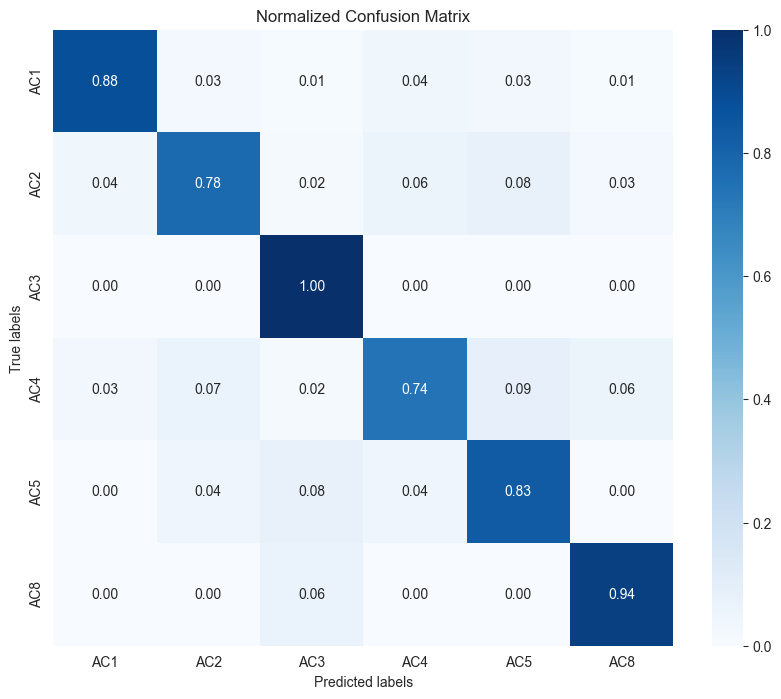

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by dividing each row (true condition) by the sum of the row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

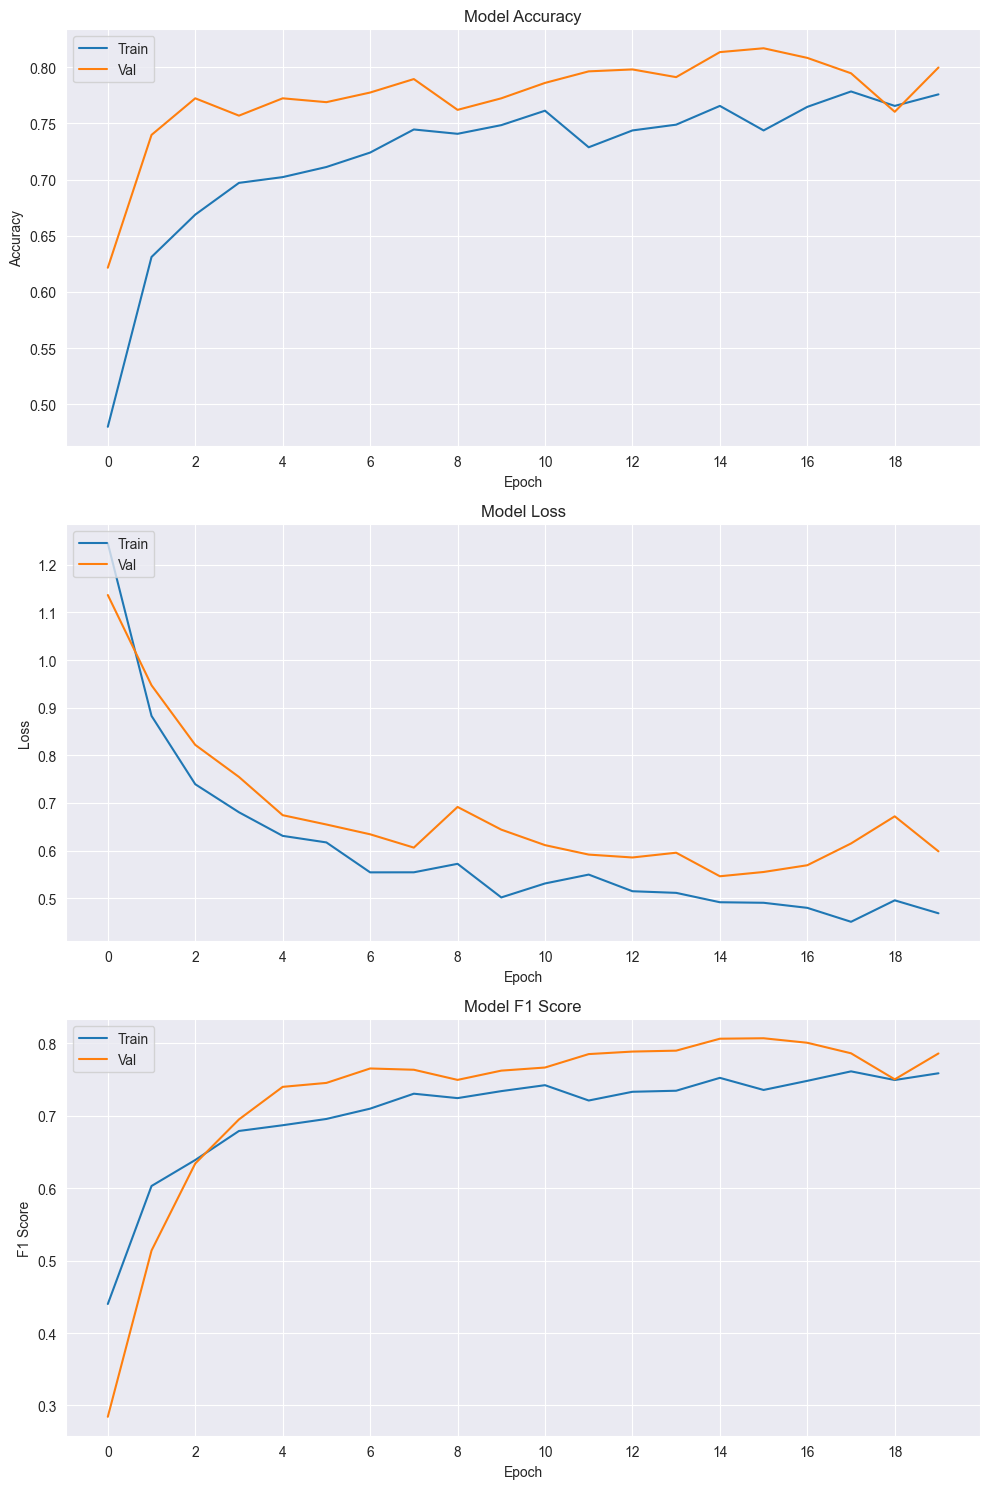

In [26]:

fig, axs = plt.subplots(3, figsize=(10, 15))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[0].set_xticks(range(0, len(history.history['accuracy']), max(1, len(history.history['accuracy']) // 10)))

# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
axs[1].set_xticks(range(0, len(history.history['loss']), max(1, len(history.history['loss']) // 10)))

# Plot training & validation F1 score values
axs[2].plot(history.history['f1'])
axs[2].plot(history.history['val_f1'])
axs[2].set_title('Model F1 Score')
axs[2].set_ylabel('F1 Score')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Val'], loc='upper left')
axs[2].set_xticks(range(0, len(history.history['f1']), max(1, len(history.history['f1']) // 10)))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

plt.show()

In [27]:
from tensorflow.keras.optimizers import Adam


def unfreeze_model(original_model):
    # Clone the original model's architecture
    # new_model = clone_model(original_model)
    new_model = original_model
    # Copy the weights from the original model to the new model
    new_model.set_weights(original_model.get_weights())

    # Unfreeze the top 10 layers, except for BatchNormalization layers
    for layer in new_model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # Compile the new modeled with modified optimization settings
    optimizer = Adam(learning_rate=1e-5)
    new_model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy', f1]  # ensure f1_metric is defined or imported
    )

    return new_model

# Example usage:
# Assuming `model` is your pre-trained model
# new_model = unfreeze_model(model)

early_stopping_unfreeze = EarlyStopping(
    monitor='f1',  # specify the F1 score for early stopping
    patience=4,
    mode='max',  #
    restore_best_weights=True
)
epochs = 10  # @param {type: "slider", min:4, max:10}
history_finetune = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/10


2024-12-09 09:42:21.302211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:21.302342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 5:43 - loss: 1.1557 - accuracy: 0.6250 - f1: 0.6333

2024-12-09 09:42:23.319520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:23.319576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.8286 - accuracy: 0.7500 - f1: 0.7528

2024-12-09 09:42:23.533079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:23.534201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:23.742985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:23.743519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 15s - loss: 0.7063 - accuracy: 0.7969 - f1: 0.7947

2024-12-09 09:42:23.980436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:23.980474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 15s - loss: 0.8352 - accuracy: 0.7500 - f1: 0.7425

2024-12-09 09:42:24.218730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:24.218775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 15s - loss: 0.7859 - accuracy: 0.7589 - f1: 0.7463

2024-12-09 09:42:24.475084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:24.475074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:24.673842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:24.673920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 15s - loss: 0.7676 - accuracy: 0.7617 - f1: 0.7432

2024-12-09 09:42:24.900882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:24.902238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 14s - loss: 0.7312 - accuracy: 0.7674 - f1: 0.7466

2024-12-09 09:42:25.128265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:25.128269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 14s - loss: 0.7246 - accuracy: 0.7670 - f1: 0.7503

2024-12-09 09:42:25.366707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:25.366859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:25.565349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:25.565370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 13s - loss: 0.6846 - accuracy: 0.7740 - f1: 0.7608

2024-12-09 09:42:25.756412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:25.756632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:25.921441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:25.921745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.6673 - accuracy: 0.7750 - f1: 0.7642

2024-12-09 09:42:26.081796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:26.082066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:26.249593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:26.249758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 12s - loss: 0.6664 - accuracy: 0.7812 - f1: 0.7720

2024-12-09 09:42:26.547435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:26.550264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 12s - loss: 0.6642 - accuracy: 0.7849 - f1: 0.7748

2024-12-09 09:42:26.783395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:26.790756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 12s - loss: 0.6738 - accuracy: 0.7812 - f1: 0.7700

2024-12-09 09:42:27.003394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:27.004131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 11s - loss: 0.6619 - accuracy: 0.7844 - f1: 0.7727

2024-12-09 09:42:27.220539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:27.220539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:27.426460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:27.426513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.6523 - accuracy: 0.7902 - f1: 0.7765

2024-12-09 09:42:27.637781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:27.637810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 11s - loss: 0.6426 - accuracy: 0.7912 - f1: 0.7787

2024-12-09 09:42:27.846879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:27.846875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 10s - loss: 0.6445 - accuracy: 0.7878 - f1: 0.7759

2024-12-09 09:42:28.061030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.061635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.238428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.238440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 10s - loss: 0.6713 - accuracy: 0.7788 - f1: 0.7679

2024-12-09 09:42:28.394328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.394399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.557357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.557752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.6619 - accuracy: 0.7790 - f1: 0.7692

2024-12-09 09:42:28.696167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.696226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.896760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:28.896786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.6603 - accuracy: 0.7780 - f1: 0.7687

2024-12-09 09:42:29.197707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:29.199965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 9s - loss: 0.6566 - accuracy: 0.7781 - f1: 0.7700

2024-12-09 09:42:29.497286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:29.497726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 9s - loss: 0.6650 - accuracy: 0.7752 - f1: 0.7659

2024-12-09 09:42:29.727524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:29.727793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 9s - loss: 0.6593 - accuracy: 0.7764 - f1: 0.7672

2024-12-09 09:42:29.976236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:29.976374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.6673 - accuracy: 0.7702 - f1: 0.7603

2024-12-09 09:42:30.219839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:30.219909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.6672 - accuracy: 0.7688 - f1: 0.7589

2024-12-09 09:42:30.429672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:30.430174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 0.6617 - accuracy: 0.7682 - f1: 0.7591

2024-12-09 09:42:30.639318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:30.639560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:30.832631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:30.833565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.6553 - accuracy: 0.7681 - f1: 0.7609

2024-12-09 09:42:31.053817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:31.053977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:31.233045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:31.233134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.6526 - accuracy: 0.7680 - f1: 0.7610

2024-12-09 09:42:31.433908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:31.435897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:31.619884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:31.620346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.6497 - accuracy: 0.7679 - f1: 0.7621

2024-12-09 09:42:31.828918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:31.829293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.013928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.013915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.6436 - accuracy: 0.7685 - f1: 0.7603

2024-12-09 09:42:32.218688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.218763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.405236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.405279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.6401 - accuracy: 0.7704 - f1: 0.7620

2024-12-09 09:42:32.619125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.619237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.819156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:32.819195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.6415 - accuracy: 0.7680 - f1: 0.7607

2024-12-09 09:42:33.072776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:33.079961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 0.6387 - accuracy: 0.7676 - f1: 0.7610

2024-12-09 09:42:33.444612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:33.446704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.6315 - accuracy: 0.7704 - f1: 0.7642

2024-12-09 09:42:33.720995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:33.723780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 5s - loss: 0.6370 - accuracy: 0.7706 - f1: 0.7648

2024-12-09 09:42:33.976889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:33.976887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.6359 - accuracy: 0.7692 - f1: 0.7643

2024-12-09 09:42:34.227146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:34.227153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:34.427125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:34.427908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.6324 - accuracy: 0.7695 - f1: 0.7651

2024-12-09 09:42:34.634173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:34.634284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 4s - loss: 0.6262 - accuracy: 0.7716 - f1: 0.7668

2024-12-09 09:42:34.853854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:34.854317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.018720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.018624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.6210 - accuracy: 0.7714 - f1: 0.7665

2024-12-09 09:42:35.181796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.182776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.348316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.348738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.6200 - accuracy: 0.7712 - f1: 0.7671

2024-12-09 09:42:35.546443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.546476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.728374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.728374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.6175 - accuracy: 0.7731 - f1: 0.7688

2024-12-09 09:42:35.909753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:35.909770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.084205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.084551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.6138 - accuracy: 0.7748 - f1: 0.7706

2024-12-09 09:42:36.274166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.274204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.453291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.453409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.6096 - accuracy: 0.7755 - f1: 0.7718

2024-12-09 09:42:36.641602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.641637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.832167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:36.832244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.6076 - accuracy: 0.7761 - f1: 0.7721

2024-12-09 09:42:37.000260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.000424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.176254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.176300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.6068 - accuracy: 0.7767 - f1: 0.7725

2024-12-09 09:42:37.360772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.361191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.561925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.562107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.6014 - accuracy: 0.7790 - f1: 0.7742

2024-12-09 09:42:37.771965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.771987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.951973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:37.951993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.7800 - f1: 0.7741

2024-12-09 09:42:38.152721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:38.152729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:38.335633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:38.335873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 26s 288ms/step - loss: 0.5978 - accuracy: 0.7796 - f1: 0.7636 - val_loss: 0.4458 - val_accuracy: 0.8390 - val_f1: 0.8422
Epoch 2/10


2024-12-09 09:42:44.369227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:44.369284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 45s - loss: 0.3869 - accuracy: 0.7812 - f1: 0.7719

2024-12-09 09:42:44.998054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:44.998600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.5444 - accuracy: 0.8021 - f1: 0.7932

2024-12-09 09:42:45.215646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:45.215871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:45.407846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:45.408154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 13s - loss: 0.5076 - accuracy: 0.8250 - f1: 0.8169

2024-12-09 09:42:45.583718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:45.583804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:45.770678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:45.770784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 12s - loss: 0.4949 - accuracy: 0.8259 - f1: 0.8193

2024-12-09 09:42:45.969660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:45.969767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.154713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.154840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 11s - loss: 0.5048 - accuracy: 0.8194 - f1: 0.8136

2024-12-09 09:42:46.303637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.304054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.435252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.435593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 10s - loss: 0.4921 - accuracy: 0.8239 - f1: 0.8190

2024-12-09 09:42:46.568453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.577715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.722165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.722172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 10s - loss: 0.4957 - accuracy: 0.8149 - f1: 0.8124

2024-12-09 09:42:46.878521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:46.878630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.030608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.030630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 9s - loss: 0.5025 - accuracy: 0.8125 - f1: 0.8091 

2024-12-09 09:42:47.154090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.155579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.312539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.312609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 9s - loss: 0.5063 - accuracy: 0.8088 - f1: 0.8031

2024-12-09 09:42:47.503558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.503667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.667268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.667277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 9s - loss: 0.5092 - accuracy: 0.8043 - f1: 0.7985

2024-12-09 09:42:47.819046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.819135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.947654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:47.952876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 8s - loss: 0.4981 - accuracy: 0.8095 - f1: 0.8030

2024-12-09 09:42:48.071112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.071236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.186781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.190764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 8s - loss: 0.4925 - accuracy: 0.8111 - f1: 0.8054

2024-12-09 09:42:48.329665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.331288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.461481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.461813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 7s - loss: 0.4916 - accuracy: 0.8125 - f1: 0.8072

2024-12-09 09:42:48.597608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.597709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.737561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.737565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 7s - loss: 0.4940 - accuracy: 0.8137 - f1: 0.8081

2024-12-09 09:42:48.869909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:48.869919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.040123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.040320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 6s - loss: 0.5053 - accuracy: 0.8103 - f1: 0.8050

2024-12-09 09:42:49.192044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.192060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.332611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.332720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 6s - loss: 0.5075 - accuracy: 0.8125 - f1: 0.8077

2024-12-09 09:42:49.477574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.477896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.636521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.636651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 6s - loss: 0.5046 - accuracy: 0.8106 - f1: 0.8061

2024-12-09 09:42:49.820490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:49.820710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.016932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.017576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 6s - loss: 0.5171 - accuracy: 0.8054 - f1: 0.7999

2024-12-09 09:42:50.206197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.206426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.376123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.376232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 5s - loss: 0.5385 - accuracy: 0.7965 - f1: 0.7898

2024-12-09 09:42:50.541226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.541324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.691394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.691563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 5s - loss: 0.5489 - accuracy: 0.7941 - f1: 0.7872

2024-12-09 09:42:50.825617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.825820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.948613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:50.948643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 5s - loss: 0.5431 - accuracy: 0.7973 - f1: 0.7901

2024-12-09 09:42:51.075303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.075344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.207658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.207814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 4s - loss: 0.5404 - accuracy: 0.8001 - f1: 0.7928

2024-12-09 09:42:51.328409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.328522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.451830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.451979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 4s - loss: 0.5380 - accuracy: 0.8021 - f1: 0.7949

2024-12-09 09:42:51.579997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.580601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.722159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.722933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 4s - loss: 0.5411 - accuracy: 0.7965 - f1: 0.7895

2024-12-09 09:42:51.910908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:51.910931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.101335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.101607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 3s - loss: 0.5374 - accuracy: 0.7978 - f1: 0.7900

2024-12-09 09:42:52.283013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.287538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.451590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.452562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 3s - loss: 0.5331 - accuracy: 0.8002 - f1: 0.7925

2024-12-09 09:42:52.632191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.632204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.815095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.815484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.5279 - accuracy: 0.8019 - f1: 0.7946

2024-12-09 09:42:52.975268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:52.975486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.141974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.142548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 2s - loss: 0.5237 - accuracy: 0.8028 - f1: 0.7965

2024-12-09 09:42:53.305679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.305939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.474809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.474809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 2s - loss: 0.5300 - accuracy: 0.8015 - f1: 0.7946

2024-12-09 09:42:53.685627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.685862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.860008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:53.861186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.5321 - accuracy: 0.8019 - f1: 0.7942

2024-12-09 09:42:54.054617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.054649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.241868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.242537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5309 - accuracy: 0.8028 - f1: 0.7957

2024-12-09 09:42:54.416911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.416956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 1s - loss: 0.5291 - accuracy: 0.8034 - f1: 0.7963

2024-12-09 09:42:54.620041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.620645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.822229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.822917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.5277 - accuracy: 0.8037 - f1: 0.7965

2024-12-09 09:42:54.984579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:54.984716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.144507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.144706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5279 - accuracy: 0.8035 - f1: 0.7963

2024-12-09 09:42:55.297297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.297376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.451320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.451344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 0s - loss: 0.5280 - accuracy: 0.8033 - f1: 0.7970

2024-12-09 09:42:55.606034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.606027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.769983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.769990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5249 - accuracy: 0.8049 - f1: 0.7987

2024-12-09 09:42:55.919567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:55.919611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:56.068453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:56.068534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.5200 - accuracy: 0.8069 - f1: 0.8008

2024-12-09 09:42:56.224331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:56.224442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:56.384367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:56.384370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.8083 - f1: 0.7911

2024-12-09 09:42:56.549635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:42:56.549670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 16s 208ms/step - loss: 0.5178 - accuracy: 0.8083 - f1: 0.7911 - val_loss: 0.4586 - val_accuracy: 0.8442 - val_f1: 0.8394
Epoch 3/10


2024-12-09 09:43:00.165431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:00.165470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 46s - loss: 0.4145 - accuracy: 0.8438 - f1: 0.8437

2024-12-09 09:43:00.821752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:00.822070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 15s - loss: 0.4796 - accuracy: 0.8229 - f1: 0.8238

2024-12-09 09:43:01.039956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.040577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.228239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.229237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 14s - loss: 0.4886 - accuracy: 0.8188 - f1: 0.8245

2024-12-09 09:43:01.422345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.422466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.623740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.623726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 13s - loss: 0.5150 - accuracy: 0.8036 - f1: 0.8140

2024-12-09 09:43:01.803513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.804595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.980025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:01.980343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 12s - loss: 0.5001 - accuracy: 0.8021 - f1: 0.8108

2024-12-09 09:43:02.186776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:02.187520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:02.378632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:02.378890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 12s - loss: 0.4903 - accuracy: 0.8031 - f1: 0.8136

2024-12-09 09:43:02.562948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:02.562996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.4952 - accuracy: 0.8099 - f1: 0.8154

2024-12-09 09:43:02.776523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:02.776551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:02.964596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:02.965265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 11s - loss: 0.4947 - accuracy: 0.8103 - f1: 0.8141

2024-12-09 09:43:03.148991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:03.149213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:03.349417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:03.349492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 11s - loss: 0.5002 - accuracy: 0.8125 - f1: 0.8175

2024-12-09 09:43:03.506377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:03.506402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:03.671447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:03.671774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 10s - loss: 0.5164 - accuracy: 0.8108 - f1: 0.8145

2024-12-09 09:43:03.862975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:03.863219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.038860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.040278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 10s - loss: 0.5351 - accuracy: 0.8031 - f1: 0.8062

2024-12-09 09:43:04.195002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.198628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.350463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.350781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 9s - loss: 0.5355 - accuracy: 0.8040 - f1: 0.8079

2024-12-09 09:43:04.512129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.512163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.655708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.656167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 8s - loss: 0.5244 - accuracy: 0.8073 - f1: 0.8120

2024-12-09 09:43:04.791341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.791400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.913979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:04.914261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 8s - loss: 0.5352 - accuracy: 0.8005 - f1: 0.8054

2024-12-09 09:43:05.094214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.095781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.310937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.310936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 8s - loss: 0.5519 - accuracy: 0.7969 - f1: 0.8001

2024-12-09 09:43:05.526335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.538699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.685011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.685345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 7s - loss: 0.5478 - accuracy: 0.8000 - f1: 0.8022

2024-12-09 09:43:05.823660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.825011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.970817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:05.970822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 7s - loss: 0.5505 - accuracy: 0.7994 - f1: 0.8010

2024-12-09 09:43:06.153880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:06.154109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 7s - loss: 0.5480 - accuracy: 0.7988 - f1: 0.8014

2024-12-09 09:43:06.365366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:06.365605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 7s - loss: 0.5452 - accuracy: 0.8002 - f1: 0.8026

2024-12-09 09:43:06.579712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:06.579806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 7s - loss: 0.5435 - accuracy: 0.8015 - f1: 0.8035

2024-12-09 09:43:06.794548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:06.794614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 7s - loss: 0.5483 - accuracy: 0.8000 - f1: 0.8023

2024-12-09 09:43:07.006720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:07.007537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 6s - loss: 0.5447 - accuracy: 0.8024 - f1: 0.8039

2024-12-09 09:43:07.217498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:07.217748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 6s - loss: 0.5517 - accuracy: 0.7985 - f1: 0.7997

2024-12-09 09:43:07.423500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:07.423501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 6s - loss: 0.5555 - accuracy: 0.7973 - f1: 0.7984

2024-12-09 09:43:07.628049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:07.629159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:07.809795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:07.810776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.5599 - accuracy: 0.7942 - f1: 0.7966

2024-12-09 09:43:07.973740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:07.973833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.129520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.131586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 5s - loss: 0.5578 - accuracy: 0.7951 - f1: 0.7977

2024-12-09 09:43:08.265582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.265579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.390589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.390736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.5565 - accuracy: 0.7951 - f1: 0.7969

2024-12-09 09:43:08.559520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.559651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.731943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:08.739816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.5553 - accuracy: 0.7962 - f1: 0.7965

2024-12-09 09:43:09.028210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:09.028554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.5508 - accuracy: 0.7972 - f1: 0.7968

2024-12-09 09:43:09.368364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:09.369401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 4s - loss: 0.5496 - accuracy: 0.7969 - f1: 0.7956

2024-12-09 09:43:09.606124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:09.606201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.5424 - accuracy: 0.7981 - f1: 0.7983

2024-12-09 09:43:09.868758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:09.868758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:10.060580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:10.060589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.5428 - accuracy: 0.7975 - f1: 0.7982

2024-12-09 09:43:10.360108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:10.360130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.5418 - accuracy: 0.7978 - f1: 0.7983

2024-12-09 09:43:10.572292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:10.573800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:10.767940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:10.768100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.5443 - accuracy: 0.7949 - f1: 0.7974

2024-12-09 09:43:10.965589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:10.965688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.151579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.153812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5471 - accuracy: 0.7933 - f1: 0.7966

2024-12-09 09:43:11.317476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.318832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.516690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.517113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.5457 - accuracy: 0.7945 - f1: 0.7973

2024-12-09 09:43:11.709880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.709882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.881990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:11.882028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5465 - accuracy: 0.7956 - f1: 0.7985

2024-12-09 09:43:12.096832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.096906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.259949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.259959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5464 - accuracy: 0.7941 - f1: 0.7975

2024-12-09 09:43:12.420438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.420440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.574385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.574510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5503 - accuracy: 0.7928 - f1: 0.7957

2024-12-09 09:43:12.723914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.724077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.880750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:12.881278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5497 - accuracy: 0.7924 - f1: 0.7955

2024-12-09 09:43:13.053748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.053811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.215504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.215514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.5504 - accuracy: 0.7921 - f1: 0.7951

2024-12-09 09:43:13.375653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.375794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.548972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.549009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5536 - accuracy: 0.7905 - f1: 0.7922

2024-12-09 09:43:13.715061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.715057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.908707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:13.908734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5472 - accuracy: 0.7932 - f1: 0.7951

2024-12-09 09:43:14.094157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:14.094190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:14.252837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:14.252930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 17s 230ms/step - loss: 0.5478 - accuracy: 0.7929 - f1: 0.7844 - val_loss: 0.4374 - val_accuracy: 0.8459 - val_f1: 0.8463
Epoch 4/10


2024-12-09 09:43:17.632406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:17.632496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 1:02 - loss: 0.4036 - accuracy: 0.8438 - f1: 0.8525

2024-12-09 09:43:18.462034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:18.463579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 16s - loss: 0.6334 - accuracy: 0.7604 - f1: 0.7419

2024-12-09 09:43:18.730113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:18.732302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 15s - loss: 0.5389 - accuracy: 0.8047 - f1: 0.7945

2024-12-09 09:43:18.940560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:18.950258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:19.133487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:19.133518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.5410 - accuracy: 0.8125 - f1: 0.8038

2024-12-09 09:43:19.337540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:19.337877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:19.532477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:19.532917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 14s - loss: 0.5256 - accuracy: 0.8259 - f1: 0.8134

2024-12-09 09:43:19.722754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:19.723003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.5539 - accuracy: 0.8090 - f1: 0.7988

2024-12-09 09:43:19.938200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:19.938367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.135126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.139253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 12s - loss: 0.5874 - accuracy: 0.7983 - f1: 0.7891

2024-12-09 09:43:20.323725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.324829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.521836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.521728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 12s - loss: 0.5840 - accuracy: 0.8077 - f1: 0.7938

2024-12-09 09:43:20.710453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.710567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.902731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:20.903021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.5832 - accuracy: 0.8042 - f1: 0.7929

2024-12-09 09:43:21.153565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:21.157230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:21.376048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:21.376669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.5724 - accuracy: 0.8107 - f1: 0.7999

2024-12-09 09:43:21.626068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:21.626187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:21.794015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:21.794078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.5478 - accuracy: 0.8174 - f1: 0.8073

2024-12-09 09:43:21.960481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:21.960498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:22.136659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:22.140469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 11s - loss: 0.5503 - accuracy: 0.8172 - f1: 0.8079

2024-12-09 09:43:22.399009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:22.403955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 10s - loss: 0.5391 - accuracy: 0.8196 - f1: 0.8111

2024-12-09 09:43:22.681578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:22.682093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:22.887621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:22.887836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.5379 - accuracy: 0.8179 - f1: 0.8103

2024-12-09 09:43:23.096639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:23.096653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 10s - loss: 0.5337 - accuracy: 0.8203 - f1: 0.8107

2024-12-09 09:43:23.308686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:23.308677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 10s - loss: 0.5515 - accuracy: 0.8138 - f1: 0.8032

2024-12-09 09:43:23.521731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:23.522063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.5387 - accuracy: 0.8183 - f1: 0.8069 

2024-12-09 09:43:23.742398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:23.743699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:23.945803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:23.945886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.5618 - accuracy: 0.8114 - f1: 0.8010

2024-12-09 09:43:24.163569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:24.164093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:24.338261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:24.338518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.5566 - accuracy: 0.8105 - f1: 0.8017

2024-12-09 09:43:24.505443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:24.506006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:24.667888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:24.668252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.5506 - accuracy: 0.8115 - f1: 0.8035

2024-12-09 09:43:24.872038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:24.872919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.5500 - accuracy: 0.8116 - f1: 0.8038

2024-12-09 09:43:25.123311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:25.124032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.5508 - accuracy: 0.8097 - f1: 0.8029

2024-12-09 09:43:25.373652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:25.379106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.5484 - accuracy: 0.8098 - f1: 0.8024

2024-12-09 09:43:25.605204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:25.606592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 0.5514 - accuracy: 0.8090 - f1: 0.8011

2024-12-09 09:43:25.841332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:25.841668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.5584 - accuracy: 0.8057 - f1: 0.7978

2024-12-09 09:43:26.067315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:26.069454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.5544 - accuracy: 0.8084 - f1: 0.8006

2024-12-09 09:43:26.290459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:26.290560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.5492 - accuracy: 0.8102 - f1: 0.8032

2024-12-09 09:43:26.511132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:26.517255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:26.706356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:26.708181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.5479 - accuracy: 0.8102 - f1: 0.8031

2024-12-09 09:43:26.905243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:26.905273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.5530 - accuracy: 0.8058 - f1: 0.7999

2024-12-09 09:43:27.156986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:27.157102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5517 - accuracy: 0.8075 - f1: 0.7997

2024-12-09 09:43:27.372739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:27.373044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:27.564269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:27.564710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.5530 - accuracy: 0.8056 - f1: 0.7982

2024-12-09 09:43:27.763631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:27.764016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.5531 - accuracy: 0.8072 - f1: 0.8006

2024-12-09 09:43:27.991228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:27.991291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.182613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.183005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.5497 - accuracy: 0.8080 - f1: 0.8025

2024-12-09 09:43:28.359603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.360703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.560927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.561056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.5450 - accuracy: 0.8082 - f1: 0.8036

2024-12-09 09:43:28.779827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.779831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.939739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:28.939916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 4s - loss: 0.5470 - accuracy: 0.8060 - f1: 0.8006

2024-12-09 09:43:29.106686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:29.106919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:29.277625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:29.277657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.5479 - accuracy: 0.8045 - f1: 0.7996

2024-12-09 09:43:29.483244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:29.485408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:29.674982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:29.679546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5519 - accuracy: 0.8048 - f1: 0.7993

2024-12-09 09:43:29.851421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:29.851442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.031713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.032287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 3s - loss: 0.5537 - accuracy: 0.8055 - f1: 0.7991

2024-12-09 09:43:30.254285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.257987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.5502 - accuracy: 0.8062 - f1: 0.8007

2024-12-09 09:43:30.483181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.483384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.651568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.651595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5495 - accuracy: 0.8065 - f1: 0.8006

2024-12-09 09:43:30.810292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.810384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.983308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:30.983320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5460 - accuracy: 0.8085 - f1: 0.8016

2024-12-09 09:43:31.158749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:31.158750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5396 - accuracy: 0.8106 - f1: 0.8033

2024-12-09 09:43:31.382749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:31.382816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:31.539072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:31.539211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5430 - accuracy: 0.8083 - f1: 0.8020

2024-12-09 09:43:31.693680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:31.693680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:31.845929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:31.845952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.5408 - accuracy: 0.8080 - f1: 0.8011

2024-12-09 09:43:32.017699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.017795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.213754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.215118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5377 - accuracy: 0.8085 - f1: 0.8017

2024-12-09 09:43:32.420445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.420523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.591640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.592392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5362 - accuracy: 0.8082 - f1: 0.8008

2024-12-09 09:43:32.750636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.750754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.898873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:32.898873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 18s 238ms/step - loss: 0.5370 - accuracy: 0.8079 - f1: 0.7900 - val_loss: 0.4378 - val_accuracy: 0.8527 - val_f1: 0.8485
Epoch 5/10


2024-12-09 09:43:35.824268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:35.824387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 15s - loss: 0.3042 - accuracy: 0.8906 - f1: 0.8976

2024-12-09 09:43:36.359576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:36.359602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 13s - loss: 0.4012 - accuracy: 0.8646 - f1: 0.8672

2024-12-09 09:43:36.564886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:36.565486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:36.718979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:36.719286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 11s - loss: 0.4811 - accuracy: 0.8438 - f1: 0.8369

2024-12-09 09:43:36.863194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:36.863207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:37.026242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:37.026680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 12s - loss: 0.4793 - accuracy: 0.8438 - f1: 0.8386

2024-12-09 09:43:37.287064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:37.288206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 12s - loss: 0.4389 - accuracy: 0.8594 - f1: 0.8566

2024-12-09 09:43:37.502914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:37.502996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 12s - loss: 0.5276 - accuracy: 0.8403 - f1: 0.8378

2024-12-09 09:43:37.708482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:37.710009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 12s - loss: 0.5434 - accuracy: 0.8250 - f1: 0.8218

2024-12-09 09:43:37.912088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:37.912259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:38.111055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:38.111117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.5378 - accuracy: 0.8307 - f1: 0.8255

2024-12-09 09:43:38.326345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:38.328665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:38.522991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:38.523643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 12s - loss: 0.5291 - accuracy: 0.8269 - f1: 0.8230

2024-12-09 09:43:38.721813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:38.721957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 11s - loss: 0.5336 - accuracy: 0.8188 - f1: 0.8167

2024-12-09 09:43:38.951930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:38.952484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:39.098653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:39.098811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.5504 - accuracy: 0.8162 - f1: 0.8163

2024-12-09 09:43:39.268396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:39.268854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 10s - loss: 0.5544 - accuracy: 0.8125 - f1: 0.8143

2024-12-09 09:43:39.471808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:39.472136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:39.639013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:39.643301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 10s - loss: 0.5505 - accuracy: 0.8156 - f1: 0.8179

2024-12-09 09:43:39.832635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:39.832691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:40.029588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:40.035129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 10s - loss: 0.5530 - accuracy: 0.8125 - f1: 0.8148

2024-12-09 09:43:40.268626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:40.268748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.5390 - accuracy: 0.8166 - f1: 0.8179

2024-12-09 09:43:40.508505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:40.508524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:40.707434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:40.707449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 9s - loss: 0.5655 - accuracy: 0.8075 - f1: 0.8101

2024-12-09 09:43:40.908443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:40.908550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 9s - loss: 0.5610 - accuracy: 0.8053 - f1: 0.8097

2024-12-09 09:43:41.111803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:41.111895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:41.307602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:41.308435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.5675 - accuracy: 0.8047 - f1: 0.8086

2024-12-09 09:43:41.521152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:41.521726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:41.702066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:41.702757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 8s - loss: 0.5629 - accuracy: 0.8039 - f1: 0.8089

2024-12-09 09:43:41.929155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:41.929180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 8s - loss: 0.5648 - accuracy: 0.8042 - f1: 0.8096

2024-12-09 09:43:42.214549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:42.215027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 8s - loss: 0.5613 - accuracy: 0.8047 - f1: 0.8099

2024-12-09 09:43:42.466688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:42.466759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:42.665783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:42.666462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.5586 - accuracy: 0.8040 - f1: 0.8092

2024-12-09 09:43:42.871520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:42.871568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.5517 - accuracy: 0.8051 - f1: 0.8111

2024-12-09 09:43:43.095803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:43.095834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.5570 - accuracy: 0.8047 - f1: 0.8099

2024-12-09 09:43:43.363379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:43.368727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:43.559739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:43.561712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.5559 - accuracy: 0.8066 - f1: 0.8117

2024-12-09 09:43:43.752269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:43.752355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 7s - loss: 0.5610 - accuracy: 0.8051 - f1: 0.8099

2024-12-09 09:43:43.976310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:43.976369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.5754 - accuracy: 0.8016 - f1: 0.8069

2024-12-09 09:43:44.194294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:44.195494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:44.381786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:44.381902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.5790 - accuracy: 0.7980 - f1: 0.8029

2024-12-09 09:43:44.573773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:44.574192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.5736 - accuracy: 0.7980 - f1: 0.8032

2024-12-09 09:43:44.791594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:44.791640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:44.973433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:44.973500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5744 - accuracy: 0.7962 - f1: 0.8018

2024-12-09 09:43:45.157221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:45.157209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 5s - loss: 0.5737 - accuracy: 0.7962 - f1: 0.8000

2024-12-09 09:43:45.381363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:45.381372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:45.571434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:45.571456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 5s - loss: 0.5650 - accuracy: 0.8008 - f1: 0.8042

2024-12-09 09:43:45.792932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:45.792952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:45.974370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:45.976024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.5557 - accuracy: 0.8050 - f1: 0.8072

2024-12-09 09:43:46.155262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:46.155441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:46.331572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:46.331604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.5526 - accuracy: 0.8053 - f1: 0.8079

2024-12-09 09:43:46.542454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:46.542847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:46.737784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:46.737800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5562 - accuracy: 0.8050 - f1: 0.8076

2024-12-09 09:43:46.941633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:46.941504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:47.139984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:47.140440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.5533 - accuracy: 0.8047 - f1: 0.8065

2024-12-09 09:43:47.448249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:47.449905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5533 - accuracy: 0.8048 - f1: 0.8071

2024-12-09 09:43:47.658337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:47.664548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:47.850393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:47.850632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 3s - loss: 0.5475 - accuracy: 0.8067 - f1: 0.8090

2024-12-09 09:43:48.092670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:48.094101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:48.286092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:48.286240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5404 - accuracy: 0.8094 - f1: 0.8113

2024-12-09 09:43:48.469063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:48.469243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:48.668532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:48.668514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5400 - accuracy: 0.8095 - f1: 0.8115

2024-12-09 09:43:48.838713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:48.838876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.016726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.016845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5398 - accuracy: 0.8087 - f1: 0.8106

2024-12-09 09:43:49.196619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.196626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.383838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.383860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5362 - accuracy: 0.8097 - f1: 0.8105

2024-12-09 09:43:49.571239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.571264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.748793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.749216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 1s - loss: 0.5309 - accuracy: 0.8120 - f1: 0.8128

2024-12-09 09:43:49.934687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:49.934732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.126297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.126292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5272 - accuracy: 0.8138 - f1: 0.8147

2024-12-09 09:43:50.290443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.290540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.465705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.465883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5280 - accuracy: 0.8134 - f1: 0.8125

2024-12-09 09:43:50.641726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.641726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.805171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:50.805186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 18s 238ms/step - loss: 0.5285 - accuracy: 0.8130 - f1: 0.8015 - val_loss: 0.4352 - val_accuracy: 0.8493 - val_f1: 0.8498
Epoch 6/10


2024-12-09 09:43:53.726547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:53.726623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 11s - loss: 0.3880 - accuracy: 0.8750 - f1: 0.8707

2024-12-09 09:43:54.208285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:54.208400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:54.365248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:54.365382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 11s - loss: 0.4081 - accuracy: 0.8542 - f1: 0.8646

2024-12-09 09:43:54.572862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:54.572904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 14s - loss: 0.4258 - accuracy: 0.8313 - f1: 0.8451

2024-12-09 09:43:54.818415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:54.818714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.033960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.036599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 14s - loss: 0.5029 - accuracy: 0.8170 - f1: 0.8290

2024-12-09 09:43:55.271056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.271674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.469565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.469719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 13s - loss: 0.5078 - accuracy: 0.8160 - f1: 0.8274

2024-12-09 09:43:55.671730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.671863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.872190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:55.872474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 13s - loss: 0.5359 - accuracy: 0.8097 - f1: 0.8159

2024-12-09 09:43:56.086468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:56.086552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:56.281078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:56.281312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.5311 - accuracy: 0.8125 - f1: 0.8178

2024-12-09 09:43:56.477165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:56.477440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.5294 - accuracy: 0.8125 - f1: 0.8128

2024-12-09 09:43:56.707224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:56.707208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:56.901618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:56.901738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 12s - loss: 0.5188 - accuracy: 0.8167 - f1: 0.8167

2024-12-09 09:43:57.091248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:57.091980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.5097 - accuracy: 0.8199 - f1: 0.8211

2024-12-09 09:43:57.323235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:57.323961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:57.521653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:57.521646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.5132 - accuracy: 0.8212 - f1: 0.8223

2024-12-09 09:43:57.806581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:57.809428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 11s - loss: 0.5203 - accuracy: 0.8191 - f1: 0.8208

2024-12-09 09:43:58.033592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:58.033669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 11s - loss: 0.5260 - accuracy: 0.8141 - f1: 0.8163

2024-12-09 09:43:58.267631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:58.267672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.5181 - accuracy: 0.8170 - f1: 0.8191

2024-12-09 09:43:58.528431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:58.528435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 10s - loss: 0.5314 - accuracy: 0.8152 - f1: 0.8175

2024-12-09 09:43:58.744650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:58.744923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:58.936516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:58.936954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 10s - loss: 0.5354 - accuracy: 0.8125 - f1: 0.8143

2024-12-09 09:43:59.160819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:59.161160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:59.341750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:59.341981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 10s - loss: 0.5406 - accuracy: 0.8101 - f1: 0.8123

2024-12-09 09:43:59.522087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:59.522095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.5336 - accuracy: 0.8125 - f1: 0.8146 

2024-12-09 09:43:59.749373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:59.749382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:59.936558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:43:59.936772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.5453 - accuracy: 0.8082 - f1: 0.8114

2024-12-09 09:44:00.122468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:00.122625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 9s - loss: 0.5366 - accuracy: 0.8085 - f1: 0.8138

2024-12-09 09:44:00.344449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:00.348855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:00.542034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:00.542152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.5346 - accuracy: 0.8078 - f1: 0.8137

2024-12-09 09:44:00.728246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:00.728278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:00.901300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:00.901295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 8s - loss: 0.5514 - accuracy: 0.8027 - f1: 0.8059

2024-12-09 09:44:01.107138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:01.107573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 7s - loss: 0.5518 - accuracy: 0.8030 - f1: 0.8061

2024-12-09 09:44:01.314666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:01.314788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:01.508117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:01.508362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.5493 - accuracy: 0.8049 - f1: 0.8080

2024-12-09 09:44:01.701418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:01.701535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.5510 - accuracy: 0.8045 - f1: 0.8073

2024-12-09 09:44:01.921188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:01.921206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:02.118740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:02.118980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.5497 - accuracy: 0.8047 - f1: 0.8079

2024-12-09 09:44:02.319313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:02.321595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 6s - loss: 0.5423 - accuracy: 0.8065 - f1: 0.8097

2024-12-09 09:44:02.554689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:02.555501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:02.734870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:02.736773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5443 - accuracy: 0.8075 - f1: 0.8107

2024-12-09 09:44:02.915165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:02.915162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.5434 - accuracy: 0.8076 - f1: 0.8110

2024-12-09 09:44:03.123262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:03.123371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:03.319544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:03.319638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.5397 - accuracy: 0.8065 - f1: 0.8107

2024-12-09 09:44:03.514676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:03.514812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:03.713625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:03.713611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.5355 - accuracy: 0.8068 - f1: 0.8115

2024-12-09 09:44:03.899556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:03.899525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 4s - loss: 0.5302 - accuracy: 0.8087 - f1: 0.8130

2024-12-09 09:44:04.104693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.105361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.287614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.288294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 4s - loss: 0.5236 - accuracy: 0.8125 - f1: 0.8161

2024-12-09 09:44:04.450551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.450814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.613880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.613888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5349 - accuracy: 0.8090 - f1: 0.8128

2024-12-09 09:44:04.796253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.796499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.970952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:04.971036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 3s - loss: 0.5389 - accuracy: 0.8080 - f1: 0.8113

2024-12-09 09:44:05.148412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:05.148427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:05.327460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:05.327831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 3s - loss: 0.5372 - accuracy: 0.8071 - f1: 0.8100

2024-12-09 09:44:05.505821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:05.505936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:05.672538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:05.672555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 2s - loss: 0.5356 - accuracy: 0.8073 - f1: 0.8104

2024-12-09 09:44:05.838018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:05.838271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.010502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.010517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5292 - accuracy: 0.8100 - f1: 0.8129

2024-12-09 09:44:06.186076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.186088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.337501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.337511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 2s - loss: 0.5274 - accuracy: 0.8110 - f1: 0.8135

2024-12-09 09:44:06.482551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.484250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.5293 - accuracy: 0.8091 - f1: 0.8116

2024-12-09 09:44:06.714564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.715004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5309 - accuracy: 0.8087 - f1: 0.8109

2024-12-09 09:44:06.931380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:06.931468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.122843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.122981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.5291 - accuracy: 0.8097 - f1: 0.8115

2024-12-09 09:44:07.313422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.313518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.498365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.498513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5285 - accuracy: 0.8098 - f1: 0.8119

2024-12-09 09:44:07.691383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.691423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.868145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:07.868145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.5231 - accuracy: 0.8125 - f1: 0.8147

2024-12-09 09:44:08.057774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:08.057800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:08.253311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:08.253321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8139 - f1: 0.8051

2024-12-09 09:44:08.425581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:08.425692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 17s 226ms/step - loss: 0.5208 - accuracy: 0.8139 - f1: 0.8051 - val_loss: 0.4436 - val_accuracy: 0.8459 - val_f1: 0.8479
Epoch 7/10


2024-12-09 09:44:10.734024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:10.734031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 41s - loss: 0.3833 - accuracy: 0.8125 - f1: 0.8333

2024-12-09 09:44:11.310141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:11.310588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/74 [>.............................] - ETA: 14s - loss: 0.5688 - accuracy: 0.8021 - f1: 0.8175

2024-12-09 09:44:11.528085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:11.530513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:11.713074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:11.713216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 13s - loss: 0.6093 - accuracy: 0.8000 - f1: 0.8077

2024-12-09 09:44:11.922681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:11.922693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.109760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.110395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 13s - loss: 0.5747 - accuracy: 0.8080 - f1: 0.8084

2024-12-09 09:44:12.305843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.305919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.480968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.481103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 11s - loss: 0.5328 - accuracy: 0.8229 - f1: 0.8213

2024-12-09 09:44:12.624498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.624522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.761842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.761931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 10s - loss: 0.5086 - accuracy: 0.8324 - f1: 0.8245

2024-12-09 09:44:12.894222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:12.895134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.024546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.029332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 10s - loss: 0.4972 - accuracy: 0.8389 - f1: 0.8340

2024-12-09 09:44:13.178296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.179216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.319517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.319795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 9s - loss: 0.5031 - accuracy: 0.8333 - f1: 0.8269

2024-12-09 09:44:13.447036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.447036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.590456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.590482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 9s - loss: 0.4827 - accuracy: 0.8364 - f1: 0.8323

2024-12-09 09:44:13.747297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.747408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.894794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:13.894802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 8s - loss: 0.4728 - accuracy: 0.8372 - f1: 0.8340

2024-12-09 09:44:14.054126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.057733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.223492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.223865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 8s - loss: 0.4617 - accuracy: 0.8408 - f1: 0.8399

2024-12-09 09:44:14.392356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.398678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.575223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.575363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 8s - loss: 0.4803 - accuracy: 0.8315 - f1: 0.8301

2024-12-09 09:44:14.732546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.733979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.874925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:14.874989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 7s - loss: 0.4795 - accuracy: 0.8275 - f1: 0.8259

2024-12-09 09:44:15.012016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.012029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.147651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.147778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 7s - loss: 0.4718 - accuracy: 0.8322 - f1: 0.8306

2024-12-09 09:44:15.279337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.279459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.418666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.418788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 7s - loss: 0.4747 - accuracy: 0.8287 - f1: 0.8274

2024-12-09 09:44:15.565417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.565488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.707364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.708092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 6s - loss: 0.4780 - accuracy: 0.8256 - f1: 0.8265

2024-12-09 09:44:15.848298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:15.851339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.021738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.024034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 6s - loss: 0.4756 - accuracy: 0.8248 - f1: 0.8270

2024-12-09 09:44:16.174510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.178981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.330061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.333763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 6s - loss: 0.4919 - accuracy: 0.8196 - f1: 0.8200

2024-12-09 09:44:16.476416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.477202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.602361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.602516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 5s - loss: 0.4934 - accuracy: 0.8201 - f1: 0.8219

2024-12-09 09:44:16.737517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.737543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.868962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:16.869044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 5s - loss: 0.4872 - accuracy: 0.8213 - f1: 0.8229

2024-12-09 09:44:17.002036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.002077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.140802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.140918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 5s - loss: 0.4953 - accuracy: 0.8186 - f1: 0.8201

2024-12-09 09:44:17.273540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.273693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.405982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.408244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 4s - loss: 0.5139 - accuracy: 0.8140 - f1: 0.8152

2024-12-09 09:44:17.557970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.558022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.727769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.727788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 4s - loss: 0.5123 - accuracy: 0.8153 - f1: 0.8150

2024-12-09 09:44:17.927249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:17.927272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.100453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.100587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 4s - loss: 0.5106 - accuracy: 0.8138 - f1: 0.8127

2024-12-09 09:44:18.263924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.267861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.441775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.441984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 3s - loss: 0.5290 - accuracy: 0.8087 - f1: 0.8072

2024-12-09 09:44:18.608470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.608676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.785525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.786431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 3s - loss: 0.5239 - accuracy: 0.8100 - f1: 0.8083

2024-12-09 09:44:18.962082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:18.963602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.117177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.118093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.5275 - accuracy: 0.8084 - f1: 0.8070

2024-12-09 09:44:19.240061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.240551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.351432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.351482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 2s - loss: 0.5323 - accuracy: 0.8057 - f1: 0.8042

2024-12-09 09:44:19.465022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.465747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.578136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.578449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 2s - loss: 0.5388 - accuracy: 0.8043 - f1: 0.8028

2024-12-09 09:44:19.690411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.691142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.802017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.802117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.5353 - accuracy: 0.8067 - f1: 0.8052

2024-12-09 09:44:19.917063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:19.917107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.028840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.028963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 1s - loss: 0.5293 - accuracy: 0.8074 - f1: 0.8071

2024-12-09 09:44:20.144967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.145414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.259434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.259434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 1s - loss: 0.5279 - accuracy: 0.8085 - f1: 0.8078

2024-12-09 09:44:20.373477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.374679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.485212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.485238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5293 - accuracy: 0.8082 - f1: 0.8078

2024-12-09 09:44:20.594376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.594598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.702862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.702888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5251 - accuracy: 0.8102 - f1: 0.8094

2024-12-09 09:44:20.814544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.814615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.923797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:20.923796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.5203 - accuracy: 0.8125 - f1: 0.8119

2024-12-09 09:44:21.033462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.033470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.146575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.146658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5209 - accuracy: 0.8112 - f1: 0.8107

2024-12-09 09:44:21.257862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.257956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.368175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.368330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5172 - accuracy: 0.8112 - f1: 0.8106

2024-12-09 09:44:21.525694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.525699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.683196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:21.684467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 13s 169ms/step - loss: 0.5173 - accuracy: 0.8113 - f1: 0.7997 - val_loss: 0.4338 - val_accuracy: 0.8527 - val_f1: 0.8520
Epoch 8/10


2024-12-09 09:44:23.619325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:23.619340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 10s - loss: 0.3749 - accuracy: 0.8438 - f1: 0.8689

2024-12-09 09:44:23.978223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:23.978223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.112038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.114637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 9s - loss: 0.4068 - accuracy: 0.8359 - f1: 0.8411

2024-12-09 09:44:24.257867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.258189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.379850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.379874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 8s - loss: 0.3966 - accuracy: 0.8385 - f1: 0.8390

2024-12-09 09:44:24.505204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.505288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.623234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.623243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 8s - loss: 0.4172 - accuracy: 0.8477 - f1: 0.8435

2024-12-09 09:44:24.757515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.757558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.879291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:24.880398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 8s - loss: 0.4198 - accuracy: 0.8375 - f1: 0.8388

2024-12-09 09:44:25.007783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.010241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.135955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.136138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 7s - loss: 0.4490 - accuracy: 0.8307 - f1: 0.8309

2024-12-09 09:44:25.261181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.262608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.386040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.387373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 7s - loss: 0.4883 - accuracy: 0.8214 - f1: 0.8224

2024-12-09 09:44:25.516298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.516323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.646391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.646497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 7s - loss: 0.4828 - accuracy: 0.8184 - f1: 0.8224

2024-12-09 09:44:25.772721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.773990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.893299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:25.893990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 7s - loss: 0.4830 - accuracy: 0.8177 - f1: 0.8217

2024-12-09 09:44:26.021920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.022152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.146501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.146598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 6s - loss: 0.4934 - accuracy: 0.8172 - f1: 0.8221

2024-12-09 09:44:26.270161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.270190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.390009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.390723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 6s - loss: 0.4948 - accuracy: 0.8168 - f1: 0.8218

2024-12-09 09:44:26.526435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.526589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.650414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.650477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 6s - loss: 0.4951 - accuracy: 0.8164 - f1: 0.8208

2024-12-09 09:44:26.771788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.773376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.891637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:26.894388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 6s - loss: 0.4872 - accuracy: 0.8185 - f1: 0.8239

2024-12-09 09:44:27.014585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.015112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.137292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.137358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 5s - loss: 0.4835 - accuracy: 0.8225 - f1: 0.8279

2024-12-09 09:44:27.259337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.261266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.384479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.384685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 5s - loss: 0.4868 - accuracy: 0.8198 - f1: 0.8237

2024-12-09 09:44:27.507078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.507149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.627577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.627640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 5s - loss: 0.5018 - accuracy: 0.8184 - f1: 0.8208

2024-12-09 09:44:27.750949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.751060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.875649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:27.875729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 5s - loss: 0.4992 - accuracy: 0.8180 - f1: 0.8209

2024-12-09 09:44:28.014228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.014501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.141495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.141549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 4s - loss: 0.5118 - accuracy: 0.8151 - f1: 0.8169

2024-12-09 09:44:28.267980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.268046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.384195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.384235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 4s - loss: 0.5183 - accuracy: 0.8141 - f1: 0.8165

2024-12-09 09:44:28.523084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.531198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.708296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.716652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 4s - loss: 0.5216 - accuracy: 0.8141 - f1: 0.8166

2024-12-09 09:44:28.926643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:28.926796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.118497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.119621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/74 [================>.............] - ETA: 4s - loss: 0.5229 - accuracy: 0.8125 - f1: 0.8149

2024-12-09 09:44:29.278544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.278661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.430416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.432657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 4s - loss: 0.5207 - accuracy: 0.8139 - f1: 0.8151

2024-12-09 09:44:29.570298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.570801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.735661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.736201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 3s - loss: 0.5212 - accuracy: 0.8159 - f1: 0.8160

2024-12-09 09:44:29.884723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:29.884768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.010743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.011065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 3s - loss: 0.5225 - accuracy: 0.8177 - f1: 0.8187

2024-12-09 09:44:30.137796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.140894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.266707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.267694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 3s - loss: 0.5162 - accuracy: 0.8181 - f1: 0.8203

2024-12-09 09:44:30.399319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.400127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.519850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.520072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 2s - loss: 0.5130 - accuracy: 0.8185 - f1: 0.8193

2024-12-09 09:44:30.639496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.640262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.757443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.757680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 2s - loss: 0.5090 - accuracy: 0.8212 - f1: 0.8205

2024-12-09 09:44:30.875504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.875537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.997332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:30.997797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 2s - loss: 0.5107 - accuracy: 0.8214 - f1: 0.8206

2024-12-09 09:44:31.114772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.114806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.240748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.240860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 2s - loss: 0.5071 - accuracy: 0.8233 - f1: 0.8226

2024-12-09 09:44:31.359371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.359429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.480060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.480079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 1s - loss: 0.5119 - accuracy: 0.8208 - f1: 0.8203

2024-12-09 09:44:31.596629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.596718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.709616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.709622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 1s - loss: 0.5097 - accuracy: 0.8231 - f1: 0.8220

2024-12-09 09:44:31.838616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:31.838680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.025930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.025978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 1s - loss: 0.5069 - accuracy: 0.8228 - f1: 0.8217

2024-12-09 09:44:32.208403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.208524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.386715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.386802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5058 - accuracy: 0.8239 - f1: 0.8222

2024-12-09 09:44:32.560961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.560982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.743423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.743475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 0s - loss: 0.5039 - accuracy: 0.8244 - f1: 0.8224

2024-12-09 09:44:32.940204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:32.940204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:33.136018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:33.136168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5032 - accuracy: 0.8237 - f1: 0.8222

2024-12-09 09:44:33.323681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:33.323827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5044 - accuracy: 0.8226 - f1: 0.8214

2024-12-09 09:44:33.524504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:33.524530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:33.689205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:33.689243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5082 - accuracy: 0.8215 - f1: 0.8200

2024-12-09 09:44:33.836833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:33.836903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:34.009299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:34.009305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 14s 180ms/step - loss: 0.5088 - accuracy: 0.8211 - f1: 0.8089 - val_loss: 0.4181 - val_accuracy: 0.8596 - val_f1: 0.8560
Epoch 9/10


2024-12-09 09:44:37.161740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:37.162417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/74 [..............................] - ETA: 47s - loss: 0.3884 - accuracy: 0.9062 - f1: 0.8525

2024-12-09 09:44:37.830843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:37.842671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 21s - loss: 0.3309 - accuracy: 0.9375 - f1: 0.9024

2024-12-09 09:44:38.105613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:38.105883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 16s - loss: 0.3566 - accuracy: 0.8984 - f1: 0.8867

2024-12-09 09:44:38.328402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:38.328695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:38.510971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:38.511605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.3985 - accuracy: 0.8646 - f1: 0.8568

2024-12-09 09:44:38.702887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:38.702992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:38.878473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:38.878735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 13s - loss: 0.4725 - accuracy: 0.8398 - f1: 0.8269

2024-12-09 09:44:39.047260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.047260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.236329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.236577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 12s - loss: 0.4731 - accuracy: 0.8281 - f1: 0.8237

2024-12-09 09:44:39.423113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.423151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.603565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.603565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 12s - loss: 0.4715 - accuracy: 0.8307 - f1: 0.8250

2024-12-09 09:44:39.809305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.809563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.999623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:39.999644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 12s - loss: 0.4835 - accuracy: 0.8326 - f1: 0.8261

2024-12-09 09:44:40.208873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:40.208930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:40.410712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:40.410717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/74 [=====>........................] - ETA: 11s - loss: 0.4847 - accuracy: 0.8320 - f1: 0.8269

2024-12-09 09:44:40.621005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:40.621601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 11s - loss: 0.4945 - accuracy: 0.8290 - f1: 0.8257

2024-12-09 09:44:40.835118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:40.835381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.035940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 11s - loss: 0.4900 - accuracy: 0.8316 - f1: 0.8264

2024-12-09 09:44:41.036227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.237459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.237517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/74 [=======>......................] - ETA: 10s - loss: 0.5058 - accuracy: 0.8266 - f1: 0.8209

2024-12-09 09:44:41.425389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.425390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.597792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.598375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 10s - loss: 0.5090 - accuracy: 0.8253 - f1: 0.8191

2024-12-09 09:44:41.789368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.794388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.988922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:41.989005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 9s - loss: 0.5070 - accuracy: 0.8242 - f1: 0.8175 

2024-12-09 09:44:42.198105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:42.198355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:42.394286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:42.394357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 9s - loss: 0.5043 - accuracy: 0.8245 - f1: 0.8198

2024-12-09 09:44:42.598108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:42.598631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:42.797805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:42.798015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/74 [=========>....................] - ETA: 9s - loss: 0.5108 - accuracy: 0.8206 - f1: 0.8170

2024-12-09 09:44:42.984691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:42.984672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 9s - loss: 0.5110 - accuracy: 0.8214 - f1: 0.8184

2024-12-09 09:44:43.205617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:43.206125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 9s - loss: 0.5023 - accuracy: 0.8265 - f1: 0.8235

2024-12-09 09:44:43.429655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:43.430987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/74 [===========>..................] - ETA: 8s - loss: 0.5051 - accuracy: 0.8216 - f1: 0.8192

2024-12-09 09:44:43.643099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:43.643217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:43.845306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:43.845392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/74 [============>.................] - ETA: 8s - loss: 0.4997 - accuracy: 0.8239 - f1: 0.8223

2024-12-09 09:44:44.036357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.036333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.226812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.226995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/74 [=============>................] - ETA: 7s - loss: 0.5011 - accuracy: 0.8214 - f1: 0.8195

2024-12-09 09:44:44.418638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.422118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.614011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.614678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 7s - loss: 0.4991 - accuracy: 0.8226 - f1: 0.8218

2024-12-09 09:44:44.803303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.804473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.998991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:44.999978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 6s - loss: 0.4972 - accuracy: 0.8245 - f1: 0.8236

2024-12-09 09:44:45.185836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:45.186467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:45.366972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:45.367079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 6s - loss: 0.5050 - accuracy: 0.8201 - f1: 0.8188

2024-12-09 09:44:45.566962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:45.567465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:45.753156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:45.753289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.5068 - accuracy: 0.8190 - f1: 0.8175

2024-12-09 09:44:45.943985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:45.945275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.142990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.143079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 5s - loss: 0.5146 - accuracy: 0.8174 - f1: 0.8150

2024-12-09 09:44:46.352412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.352520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.482099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.482413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 5s - loss: 0.5132 - accuracy: 0.8185 - f1: 0.8170

2024-12-09 09:44:46.634577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.634597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.773416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.773450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 4s - loss: 0.5079 - accuracy: 0.8195 - f1: 0.8182

2024-12-09 09:44:46.899726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:46.899906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.027035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.027445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 4s - loss: 0.5140 - accuracy: 0.8162 - f1: 0.8154

2024-12-09 09:44:47.152010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.152010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.270519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.271131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/74 [====================>.........] - ETA: 3s - loss: 0.5092 - accuracy: 0.8190 - f1: 0.8176

2024-12-09 09:44:47.388805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.389884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.508942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.508959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/74 [=====================>........] - ETA: 3s - loss: 0.5055 - accuracy: 0.8210 - f1: 0.8194

2024-12-09 09:44:47.628642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.629336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.748104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.748118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/74 [======================>.......] - ETA: 3s - loss: 0.5064 - accuracy: 0.8196 - f1: 0.8181

2024-12-09 09:44:47.872311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.872343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.988826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:47.988844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/74 [======================>.......] - ETA: 2s - loss: 0.5073 - accuracy: 0.8178 - f1: 0.8165

2024-12-09 09:44:48.113342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.113486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.237644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.237758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/74 [=======================>......] - ETA: 2s - loss: 0.5039 - accuracy: 0.8186 - f1: 0.8167

2024-12-09 09:44:48.351427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.351736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.462196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.462211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/74 [========================>.....] - ETA: 1s - loss: 0.5019 - accuracy: 0.8194 - f1: 0.8171

2024-12-09 09:44:48.581822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.581831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.726971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.727197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 1s - loss: 0.5019 - accuracy: 0.8192 - f1: 0.8167

2024-12-09 09:44:48.897635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:48.898095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.047635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.047731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5008 - accuracy: 0.8200 - f1: 0.8163

2024-12-09 09:44:49.168218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.168367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.292405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.292561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


69/74 [==========================>...] - ETA: 0s - loss: 0.4960 - accuracy: 0.8220 - f1: 0.8184

2024-12-09 09:44:49.411495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.411537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.528279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.528360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.4963 - accuracy: 0.8213 - f1: 0.8181

2024-12-09 09:44:49.646210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.646213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.793986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.794001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.4949 - accuracy: 0.8215 - f1: 0.8186

2024-12-09 09:44:49.971104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:49.971254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:50.163795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:50.163854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 16s 207ms/step - loss: 0.4957 - accuracy: 0.8211 - f1: 0.8076 - val_loss: 0.4344 - val_accuracy: 0.8545 - val_f1: 0.8510
Epoch 10/10


2024-12-09 09:44:52.897807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:52.897807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/74 [..............................] - ETA: 11s - loss: 0.4363 - accuracy: 0.8438 - f1: 0.8413

2024-12-09 09:44:53.425738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:53.428190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:53.564661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:53.565183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/74 [>.............................] - ETA: 9s - loss: 0.4688 - accuracy: 0.8516 - f1: 0.8571 

2024-12-09 09:44:53.688254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:53.689849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:53.830378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:53.833342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/74 [=>............................] - ETA: 9s - loss: 0.5061 - accuracy: 0.8438 - f1: 0.8406

2024-12-09 09:44:53.979693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:53.984110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/74 [=>............................] - ETA: 14s - loss: 0.5164 - accuracy: 0.8333 - f1: 0.8371

2024-12-09 09:44:54.459120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:54.463148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/74 [=>............................] - ETA: 14s - loss: 0.5010 - accuracy: 0.8393 - f1: 0.8445

2024-12-09 09:44:54.709016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:54.709055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/74 [==>...........................] - ETA: 14s - loss: 0.5198 - accuracy: 0.8281 - f1: 0.8347

2024-12-09 09:44:54.936091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:54.936295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/74 [==>...........................] - ETA: 14s - loss: 0.5119 - accuracy: 0.8264 - f1: 0.8316

2024-12-09 09:44:55.150562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:55.151301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/74 [===>..........................] - ETA: 13s - loss: 0.5013 - accuracy: 0.8344 - f1: 0.8337

2024-12-09 09:44:55.375544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:55.377083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/74 [===>..........................] - ETA: 13s - loss: 0.5062 - accuracy: 0.8295 - f1: 0.8301

2024-12-09 09:44:55.594813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:55.596400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/74 [===>..........................] - ETA: 13s - loss: 0.4963 - accuracy: 0.8307 - f1: 0.8308

2024-12-09 09:44:55.826032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:55.827440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/74 [====>.........................] - ETA: 13s - loss: 0.5183 - accuracy: 0.8245 - f1: 0.8216

2024-12-09 09:44:56.064495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:56.064721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/74 [====>.........................] - ETA: 13s - loss: 0.5087 - accuracy: 0.8304 - f1: 0.8251

2024-12-09 09:44:56.308619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:56.308783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/74 [=====>........................] - ETA: 13s - loss: 0.5187 - accuracy: 0.8292 - f1: 0.8218

2024-12-09 09:44:56.526524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:56.530584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/74 [=====>........................] - ETA: 12s - loss: 0.5211 - accuracy: 0.8290 - f1: 0.8227

2024-12-09 09:44:56.754111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:56.754179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/74 [======>.......................] - ETA: 12s - loss: 0.5147 - accuracy: 0.8299 - f1: 0.8236

2024-12-09 09:44:56.963356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:56.970106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/74 [======>.......................] - ETA: 12s - loss: 0.5284 - accuracy: 0.8273 - f1: 0.8220

2024-12-09 09:44:57.189184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:57.189222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:57.381749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:57.381896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/74 [=======>......................] - ETA: 11s - loss: 0.5332 - accuracy: 0.8274 - f1: 0.8244

2024-12-09 09:44:57.580587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:57.580752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:57.777517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:57.778269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/74 [=======>......................] - ETA: 11s - loss: 0.5335 - accuracy: 0.8267 - f1: 0.8239

2024-12-09 09:44:57.994330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:57.995289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/74 [========>.....................] - ETA: 11s - loss: 0.5314 - accuracy: 0.8274 - f1: 0.8247

2024-12-09 09:44:58.237279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:58.237298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/74 [========>.....................] - ETA: 11s - loss: 0.5236 - accuracy: 0.8294 - f1: 0.8259

2024-12-09 09:44:58.565295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:58.568381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/74 [=========>....................] - ETA: 11s - loss: 0.5162 - accuracy: 0.8288 - f1: 0.8259

2024-12-09 09:44:58.887811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:58.889284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/74 [=========>....................] - ETA: 11s - loss: 0.5112 - accuracy: 0.8305 - f1: 0.8271

2024-12-09 09:44:59.149979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:59.150025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/74 [==========>...................] - ETA: 10s - loss: 0.5102 - accuracy: 0.8326 - f1: 0.8302

2024-12-09 09:44:59.375424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:59.375949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/74 [==========>...................] - ETA: 10s - loss: 0.5063 - accuracy: 0.8308 - f1: 0.8282

2024-12-09 09:44:59.595281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:59.595723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:44:59.802351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/74 [===========>..................] - ETA: 10s - loss: 0.5057 - accuracy: 0.8302 - f1: 0.8271

2024-12-09 09:44:59.803255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.007335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.007541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/74 [===========>..................] - ETA: 9s - loss: 0.5081 - accuracy: 0.8301 - f1: 0.8284

2024-12-09 09:45:00.199673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.200810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.401028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.401049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/74 [============>.................] - ETA: 8s - loss: 0.5081 - accuracy: 0.8309 - f1: 0.8304

2024-12-09 09:45:00.594558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.595961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.780903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.780917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/74 [=============>................] - ETA: 8s - loss: 0.5097 - accuracy: 0.8273 - f1: 0.8274

2024-12-09 09:45:00.998209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:00.998188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:01.223018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:01.223321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/74 [==============>...............] - ETA: 8s - loss: 0.5086 - accuracy: 0.8269 - f1: 0.8265

2024-12-09 09:45:01.479288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:01.479791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/74 [==============>...............] - ETA: 8s - loss: 0.5100 - accuracy: 0.8273 - f1: 0.8255

2024-12-09 09:45:01.735584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:01.738262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/74 [==============>...............] - ETA: 7s - loss: 0.5223 - accuracy: 0.8221 - f1: 0.8196

2024-12-09 09:45:01.987945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:01.988596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/74 [===============>..............] - ETA: 7s - loss: 0.5192 - accuracy: 0.8234 - f1: 0.8201

2024-12-09 09:45:02.221874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:02.222800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/74 [===============>..............] - ETA: 7s - loss: 0.5267 - accuracy: 0.8201 - f1: 0.8174

2024-12-09 09:45:02.446032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:02.446062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/74 [================>.............] - ETA: 6s - loss: 0.5363 - accuracy: 0.8176 - f1: 0.8152

2024-12-09 09:45:02.659589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:02.659753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:02.877018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:02.877276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/74 [================>.............] - ETA: 6s - loss: 0.5398 - accuracy: 0.8161 - f1: 0.8139

2024-12-09 09:45:03.141663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:03.143913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/74 [=================>............] - ETA: 6s - loss: 0.5329 - accuracy: 0.8188 - f1: 0.8163

2024-12-09 09:45:03.407407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:03.410764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/74 [=================>............] - ETA: 6s - loss: 0.5337 - accuracy: 0.8200 - f1: 0.8168

2024-12-09 09:45:03.803028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:03.808768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/74 [==================>...........] - ETA: 6s - loss: 0.5335 - accuracy: 0.8198 - f1: 0.8170

2024-12-09 09:45:04.076683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:04.076678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/74 [==================>...........] - ETA: 6s - loss: 0.5299 - accuracy: 0.8203 - f1: 0.8178

2024-12-09 09:45:04.421812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:04.421865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/74 [==================>...........] - ETA: 5s - loss: 0.5324 - accuracy: 0.8202 - f1: 0.8175

2024-12-09 09:45:04.666617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:04.666897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/74 [===================>..........] - ETA: 5s - loss: 0.5293 - accuracy: 0.8200 - f1: 0.8172

2024-12-09 09:45:04.902373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:04.904056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/74 [===================>..........] - ETA: 5s - loss: 0.5250 - accuracy: 0.8223 - f1: 0.8192

2024-12-09 09:45:05.131988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:05.133338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/74 [====================>.........] - ETA: 5s - loss: 0.5298 - accuracy: 0.8203 - f1: 0.8177

2024-12-09 09:45:05.368521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:05.368625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/74 [====================>.........] - ETA: 4s - loss: 0.5290 - accuracy: 0.8189 - f1: 0.8165

2024-12-09 09:45:05.613825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:05.614045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:05.834966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:05.835913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/74 [=====================>........] - ETA: 4s - loss: 0.5310 - accuracy: 0.8186 - f1: 0.8162

2024-12-09 09:45:06.078978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:06.078984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:06.290315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:06.290765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/74 [======================>.......] - ETA: 3s - loss: 0.5347 - accuracy: 0.8173 - f1: 0.8138

2024-12-09 09:45:06.505417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:06.507858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:06.719760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:06.719813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/74 [=======================>......] - ETA: 3s - loss: 0.5335 - accuracy: 0.8177 - f1: 0.8135

2024-12-09 09:45:06.969804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:06.969804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:07.174690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:07.175454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/74 [========================>.....] - ETA: 2s - loss: 0.5335 - accuracy: 0.8170 - f1: 0.8134

2024-12-09 09:45:07.395048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:07.395048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:07.592867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:07.600225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


64/74 [========================>.....] - ETA: 2s - loss: 0.5323 - accuracy: 0.8169 - f1: 0.8125

2024-12-09 09:45:07.819214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:07.819211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:08.023770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:08.023743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


65/74 [=========================>....] - ETA: 2s - loss: 0.5296 - accuracy: 0.8173 - f1: 0.8129

2024-12-09 09:45:08.243833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:08.243886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


66/74 [=========================>....] - ETA: 1s - loss: 0.5308 - accuracy: 0.8177 - f1: 0.8135

2024-12-09 09:45:08.496927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:08.497273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


67/74 [==========================>...] - ETA: 1s - loss: 0.5306 - accuracy: 0.8162 - f1: 0.8128

2024-12-09 09:45:08.758750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:08.758763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


68/74 [==========================>...] - ETA: 1s - loss: 0.5300 - accuracy: 0.8166 - f1: 0.8134

2024-12-09 09:45:09.004720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:09.006190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


70/74 [===========================>..] - ETA: 0s - loss: 0.5272 - accuracy: 0.8174 - f1: 0.8137

2024-12-09 09:45:09.255029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:09.255116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


71/74 [===========================>..] - ETA: 0s - loss: 0.5241 - accuracy: 0.8187 - f1: 0.8150

2024-12-09 09:45:09.461573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:09.461588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


72/74 [============================>.] - ETA: 0s - loss: 0.5252 - accuracy: 0.8177 - f1: 0.8137

2024-12-09 09:45:09.683328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:09.683349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


73/74 [============================>.] - ETA: 0s - loss: 0.5231 - accuracy: 0.8185 - f1: 0.8144

2024-12-09 09:45:09.890980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:09.891155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:10.075247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-09 09:45:10.075273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


74/74 [==============================] - 21s 277ms/step - loss: 0.5237 - accuracy: 0.8181 - f1: 0.8034 - val_loss: 0.4455 - val_accuracy: 0.8493 - val_f1: 0.8601


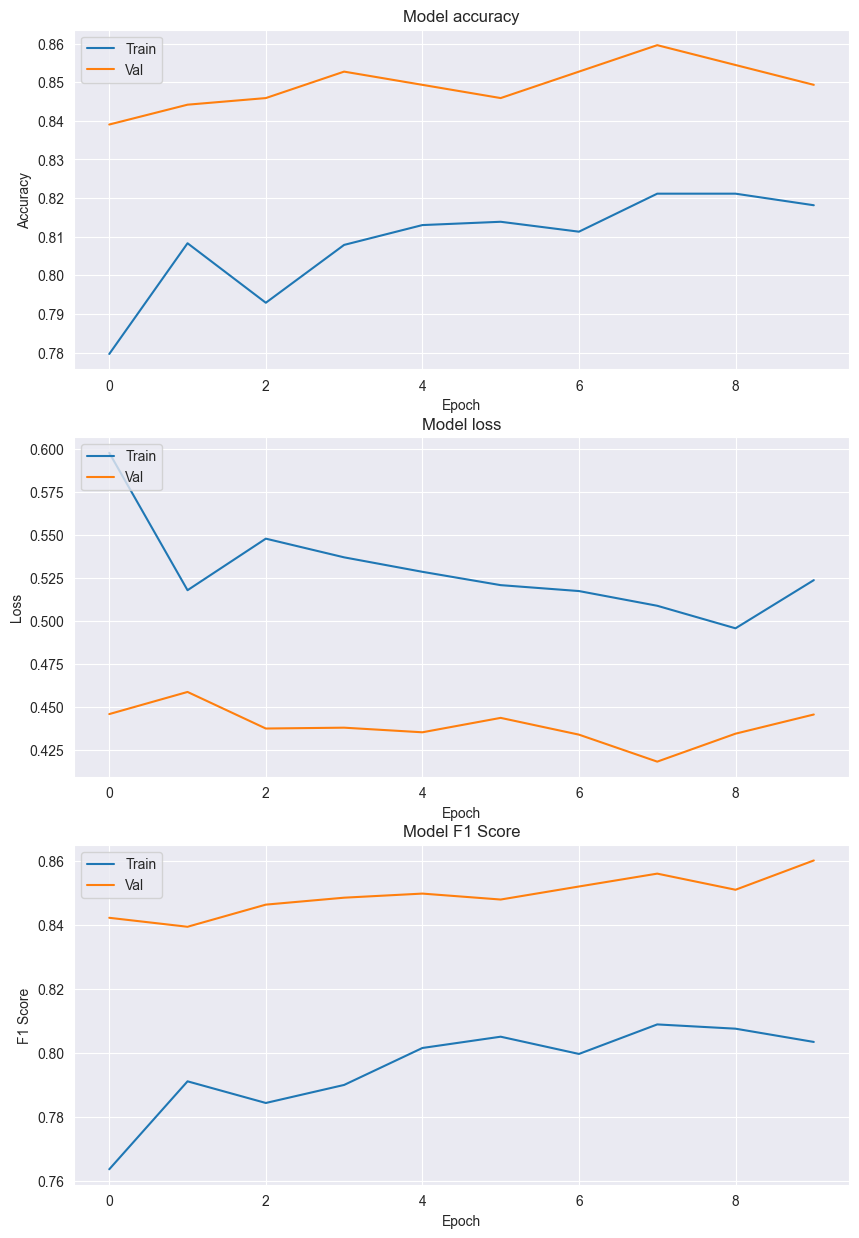

In [28]:
fig, axs = plt.subplots(3, figsize=(10, 15))

# Plot training & validation accuracy values
axs[0].plot(history_finetune.history['accuracy'])
axs[0].plot(history_finetune.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history_finetune.history['loss'])
axs[1].plot(history_finetune.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
# Plot training & validation F1 score values
axs[2].plot(history_finetune.history['f1'])
axs[2].plot(history_finetune.history['val_f1'])
axs[2].set_title('Model F1 Score')
axs[2].set_ylabel('F1 Score')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Val'], loc='upper left')

In [29]:
predictions = []
y_true = []

# Iterate over the validation dataset to collect true labels and predictions
for images, labels in val_ds:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to integer labels

# Convert lists to numpy arrays
y_pred = np.array(predictions)
y_true = np.array(y_true)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 0s 351ms/step
              precision    recall  f1-score   support

         AC1       0.88      0.87      0.88       118
         AC2       0.86      0.80      0.83       117
         AC3       0.60      1.00      0.75         9
         AC4       0.88      0.85      0.87       234
         AC5       0.76      0.82      0.79        90
         AC8       0.84      1.00      0.91        16

    accuracy                           0.85       584
   macro avg       0.80      0.89      0.84       584
weighted avg       0.85      0.85      0.85       584

